# Exploratory data analysis

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


In [ ]:
from archive.code.loadin import load_auction_data, load_forecasts
from archive.code.utils import find_loc_null, get_sample_with_missing_values, calculate_VIF, calculate_explained_variance, find_low_variance_features
from archive.code.preprocessing import Imputer, plot_imputations, evaluate_imputations, test_imputations, STL_decompose_data, preprocess_data
from archive.code.feature_engineering import pre_engineer_timeseries, make_new_price_indicators, transform_data_to_PCA, generate_lag_timeseries, generate_close_timeseries
from archive.code.train_regressor import timeseries_train_test_split, compare_models, make_XGB_objective

## Load in Auction Data

In [315]:
df1=pd.read_csv('../data/raw/auction_data.csv', delimiter=';')
df2=pd.read_csv('../data/raw/system_prices.csv', delimiter=';')

duplicated day because of daylight savings

In [316]:
df1[df1['Date (WET)']=='[31/10/2021 01:00]']

Date (WET) price_first_auction price_second_auction  \
7273  [31/10/2021 01:00]                 134                  160   
7274  [31/10/2021 01:00]               118.3                99.83   

     traded_volume_first_auction traded_volume_second_auction  \
7273                      3186.8                       6260.8   
7274                      3195.3                       6249.8   

     price_reference_forecast_first_auction  
7273                                  93.33  
7274                                 -38.47

In [317]:
df2[df2['Date (WET)']=='[31/10/2021 01:00]']

Date (WET) reference_forecast_system_price_low  \
7273  [31/10/2021 01:00]                               73.49   
7274  [31/10/2021 01:00]                               80.02   

     reference_forecast_system_price_high system_price  
7273                               168.67          170  
7274                               161.99       132.95

In [318]:
auction_data, reference_target_forecasts=load_auction_data(['../data/raw/auction_data.csv', '../data/raw/system_prices.csv'])
display(auction_data.head())

price_first_auction  price_second_auction  \
date                                                             
2021-01-01 00:00:00                 68.0                 65.73   
2021-01-01 01:00:00                 62.7                 64.96   
2021-01-01 02:00:00                 56.0                 60.47   
2021-01-01 03:00:00                 50.1                 52.50   
2021-01-01 04:00:00                 50.0                 48.98   

                     traded_volume_first_auction  \
date                                               
2021-01-01 00:00:00                       2923.7   
2021-01-01 01:00:00                       2825.0   
2021-01-01 02:00:00                       2611.4   
2021-01-01 03:00:00                       2669.3   
2021-01-01 04:00:00                       2741.4   

                     traded_volume_second_auction  system_price  
date                                                             
2021-01-01 00:00:00                        5102.4         73.15  
2021-01-01 01:00:00                        4771.5         71.95  
2021-01-01 02:00:00                        4176.2         54.56  
2021-01-01 03:00:00                        3755.9         70.73  
2021-01-01 04:00:00                        4047.5         54.98

## First look and plot

In [319]:
auction_data.describe()

price_first_auction  price_second_auction  traded_volume_first_auction  \
count         14878.000000          14878.000000                 14878.000000   
mean            157.856348            157.366823                  3988.228794   
std             112.806604            114.772445                  1071.437145   
min             -24.900000            -50.000000                   991.800000   
25%              77.862500             78.032500                  3203.800000   
50%             138.350000            137.150000                  3941.300000   
75%             201.500000            200.047500                  4672.275000   
max            1860.000000           2500.010000                  8459.600000   

       traded_volume_second_auction  system_price  
count                  14876.000000  14834.000000  
mean                    9769.885063    152.034917  
std                     2768.401968    145.319843  
min                     3329.200000    -90.320000  
25%                     7536.000000     73.512500  
50%                     9796.700000    123.715000  
75%                    11799.725000    203.000000  
max                    18419.100000   4037.800000

In [320]:
auction_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14880 entries, 2021-01-01 00:00:00 to 2022-09-12 23:00:00
Freq: h
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price_first_auction           14878 non-null  float64
 1   price_second_auction          14878 non-null  float64
 2   traded_volume_first_auction   14878 non-null  float64
 3   traded_volume_second_auction  14876 non-null  float64
 4   system_price                  14834 non-null  float64
dtypes: float64(5)
memory usage: 697.5 KB


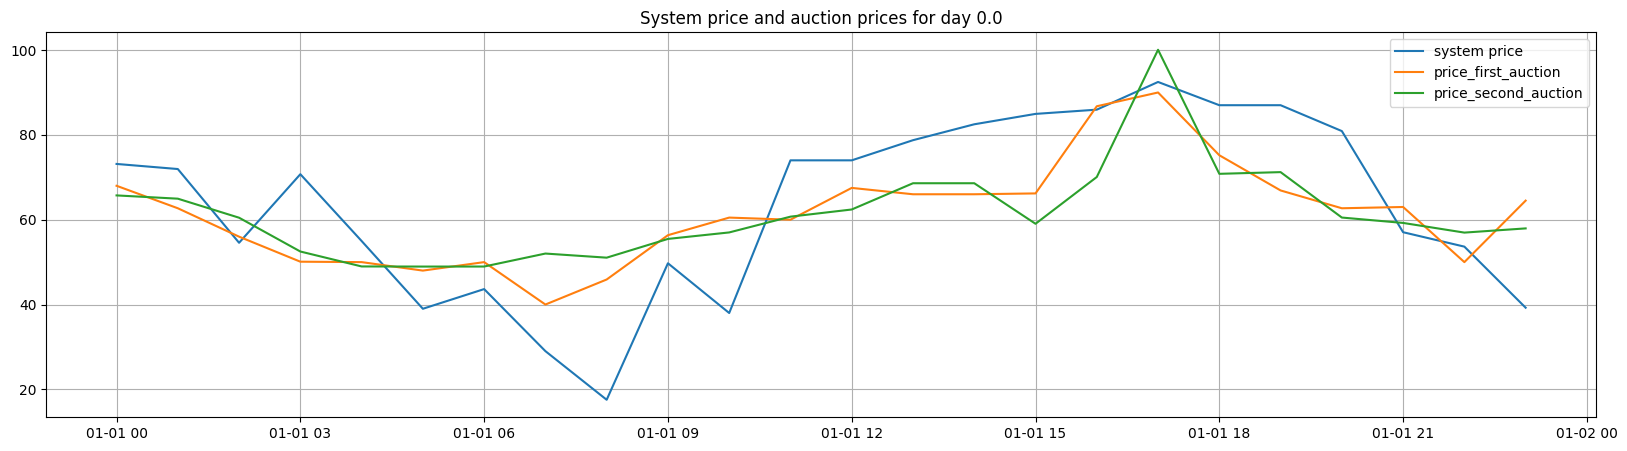

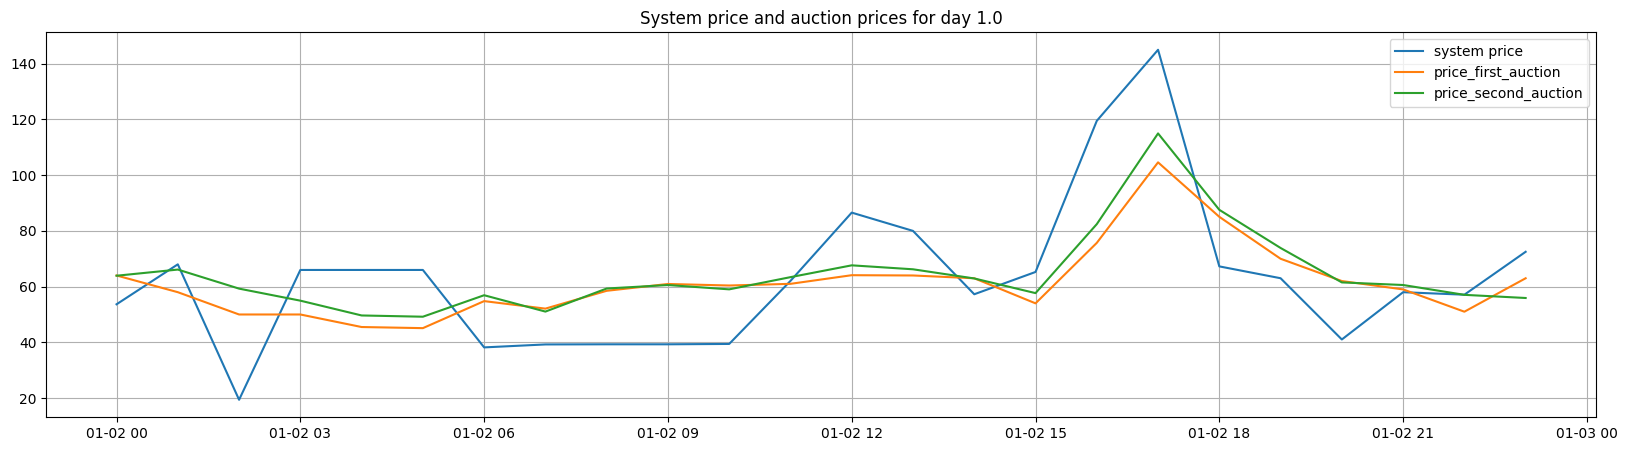

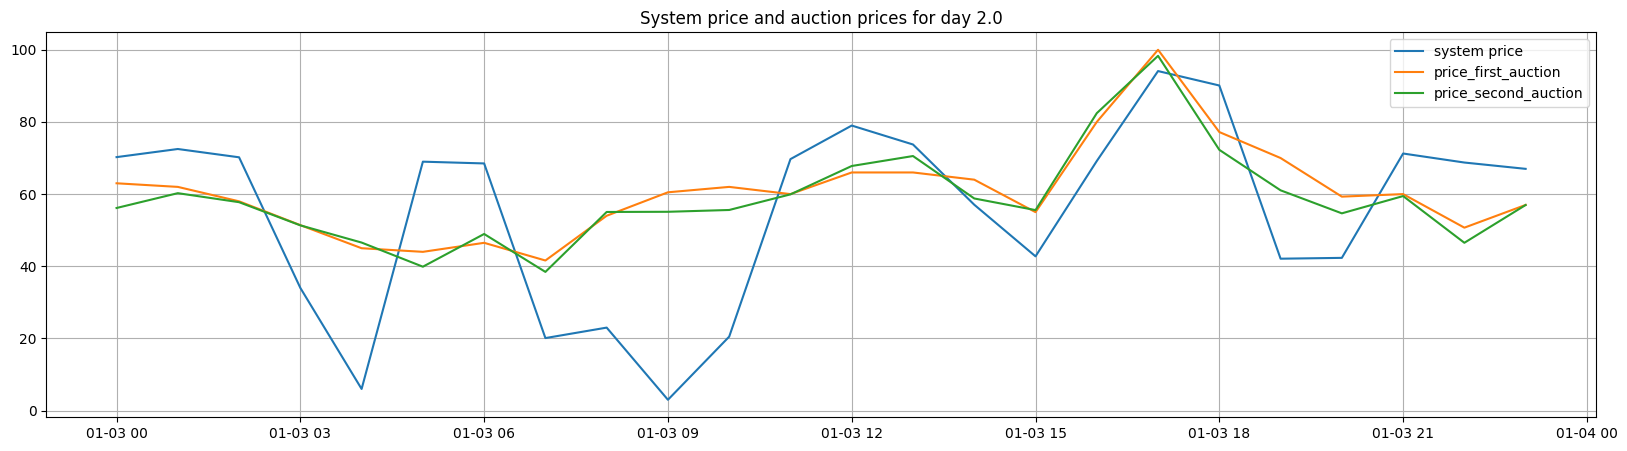

In [321]:
# plot the system price and the auction prices for a few days
days=3
for i in range(0, days*24, 24):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(auction_data['system_price'].iloc[i:i+24], label='system price')
    plt.plot(auction_data['price_first_auction'].iloc[i:i+24], label='price_first_auction')
    plt.plot(auction_data['price_second_auction'].iloc[i:i+24], label='price_second_auction')
    plt.legend(loc='best')
    plt.title(f'System price and auction prices for day {i/24}')

plot all prices and trade volumes for 2021 2022

Text(0.5, 1.0, 'System price and auction prices')

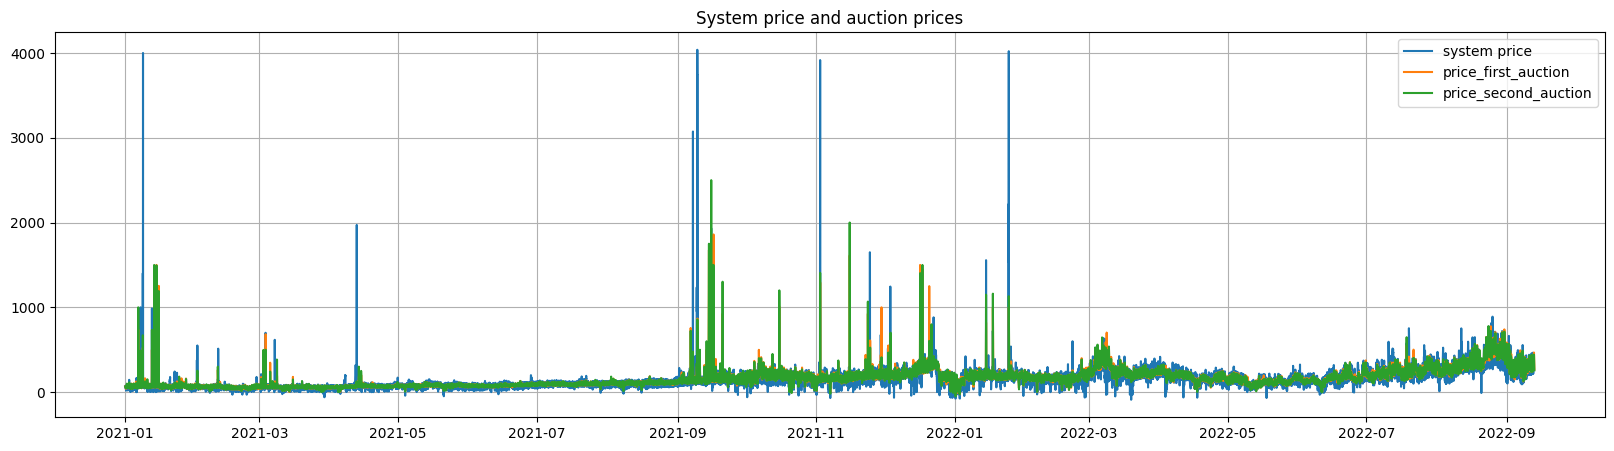

In [322]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['system_price'], label='system price')
plt.plot(auction_data['price_first_auction'], label='price_first_auction')
plt.plot(auction_data['price_second_auction'], label='price_second_auction')
plt.legend(loc='best')
plt.title(f'System price and auction prices')

Text(0.5, 1.0, 'Traded volumes')

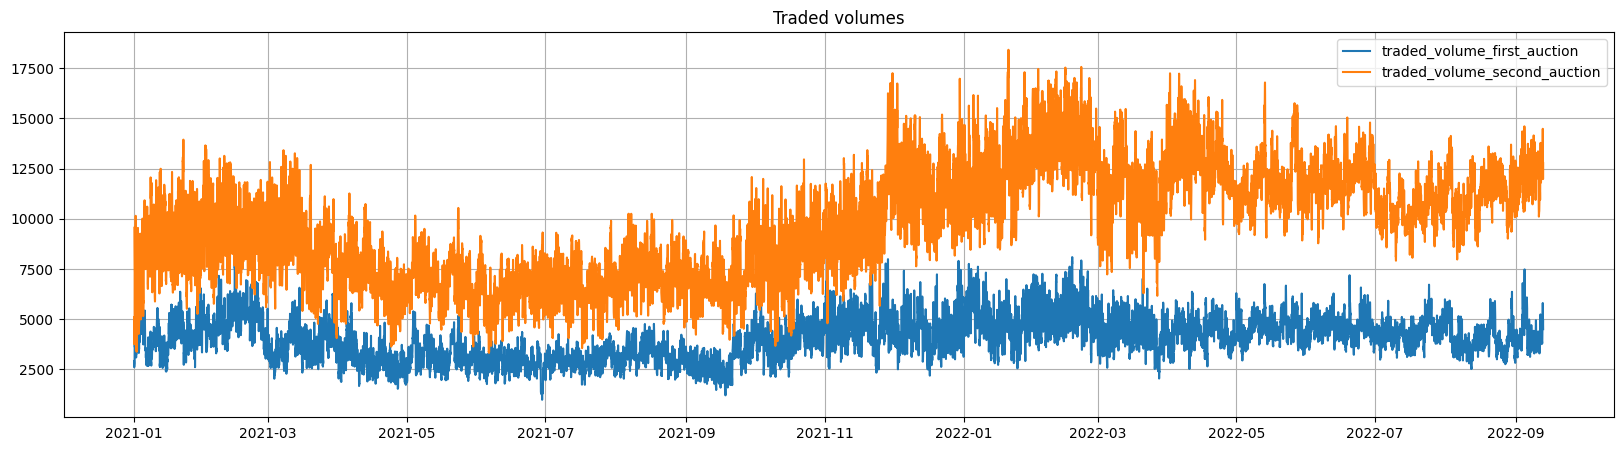

In [323]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['traded_volume_first_auction'], label='traded_volume_first_auction')
plt.plot(auction_data['traded_volume_second_auction'], label='traded_volume_second_auction')
plt.legend(loc='best')
plt.title(f'Traded volumes')

Clear 24 hour cycle for auction prices reflecting the daily cycle of solar and demand. Clear correspondence i.e. very strong correlation between two auctions we will be interested in predicting the first auction and then the price difference between auctions.

The second auction has consistently more volume traded. Perhaps as we are close to delivery the volume traded is greater since confidence in generation and demand requirements is higher.

System price exhibits much weaker correlation with the auction prices and a weaker daily cycle. Has much mre volatility. Important to note that the balancing system has much less volume than the day-ahead markets FIND DATA FOR THIS.

## Missing Values and Testing Imputation

find location of null values

In [324]:
find_loc_null(auction_data)

[(600, 'system_price'),
 (601, 'system_price'),
 (602, 'system_price'),
 (603, 'system_price'),
 (604, 'system_price'),
 (605, 'system_price'),
 (606, 'system_price'),
 (607, 'system_price'),
 (608, 'system_price'),
 (609, 'system_price'),
 (610, 'system_price'),
 (611, 'system_price'),
 (612, 'system_price'),
 (613, 'system_price'),
 (614, 'system_price'),
 (615, 'system_price'),
 (616, 'system_price'),
 (617, 'system_price'),
 (618, 'system_price'),
 (619, 'system_price'),
 (620, 'system_price'),
 (621, 'system_price'),
 (622, 'system_price'),
 (658, 'system_price'),
 (659, 'system_price'),
 (660, 'system_price'),
 (661, 'system_price'),
 (662, 'system_price'),
 (663, 'system_price'),
 (664, 'system_price'),
 (665, 'system_price'),
 (666, 'system_price'),
 (667, 'system_price'),
 (668, 'system_price'),
 (669, 'system_price'),
 (670, 'system_price'),
 (2065, 'price_first_auction'),
 (2065, 'price_second_auction'),
 (2065, 'traded_volume_first_auction'),
 (2065, 'traded_volume_second_a

most null values are consequtive entries with a 24 hour window that are missing so we must interpolate. The data exhibits a strong 24 hour cycle. We will try imputing using a rolling mean taken periodically i.e. from the same hour period from a number of past/future days. Similarly we will try a more sophisticated method using an STL decomposition and finally also using an ARIMA model.

In [325]:
sample, sample_missing, dates_missing = get_sample_with_missing_values(auction_data, '2021-01-01', '2021-01-10', 'system_price')

Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00


In [326]:
methods=[('periodic_rolling_mean', {'window_start': 1, 'window_end': 1, 'period': 24}), 
         ('periodic_rolling_mean', {'window_start': 2, 'window_end': 2, 'period': 24}),
         ('periodic_rolling_mean', {'window_start': 3, 'window_end': 3, 'period': 24}),
         ('periodic_rolling_mean', {'window_start': 1, 'window_end': 0, 'period': 24}),
         ('STL_decomposition', {'period': 24, 'iterations':1}),
         ('STL_decomposition', {'period': 24, 'iterations':2}),
         ('STL_ARIMA', {'period':24, 'ARIMA_order':(1,0,1)}),
         ('STL_ARIMA', {'period':24, 'ARIMA_order':(2,0,2)})]

In [327]:
sample_imputed_dict={}
for method, kwargs in methods:
    imputer = Imputer(method, **kwargs)
    sample_imputed_dict[method+'_'+str(list(kwargs.values()))]=imputer.impute(sample_missing, 'system_price')

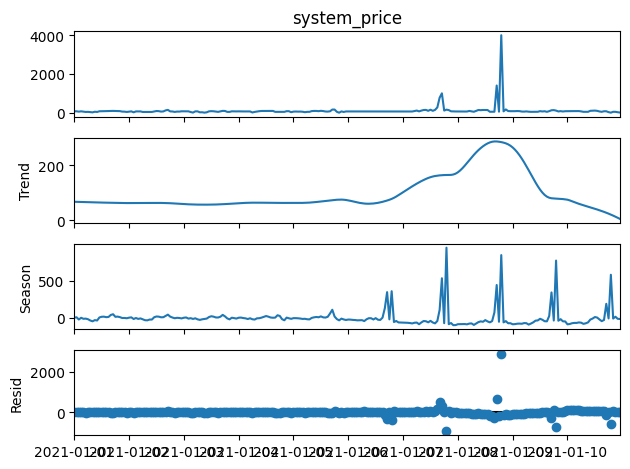

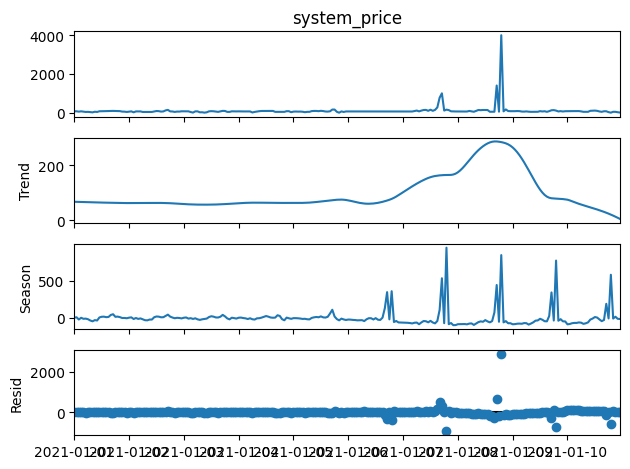

In [328]:
decomposed=STL_decompose_data(sample_missing, 'system_price', 24)
decomposed.plot()

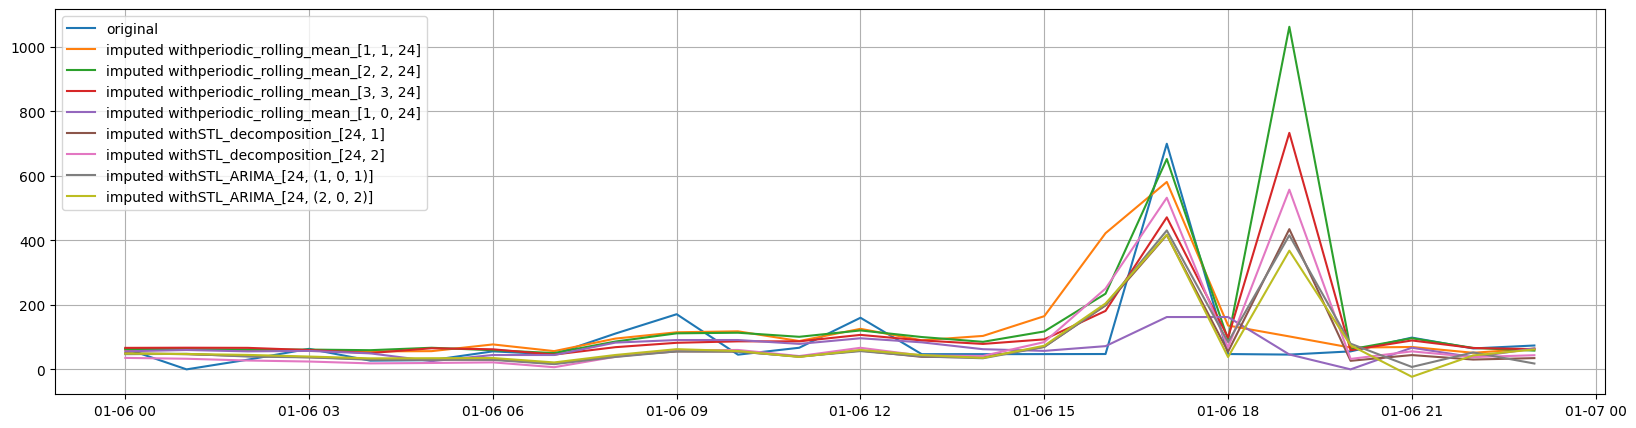

In [329]:
plot_imputations(sample, sample_imputed_dict, dates_missing)

In [330]:
evaluate_imputations(sample, sample_imputed_dict, dates_missing)

RMSE
Method                                      
periodic_rolling_mean_[1, 1, 24]   91.891327
STL_ARIMA_[24, (2, 0, 2)]         103.289566
STL_ARIMA_[24, (1, 0, 1)]         108.301242
STL_decomposition_[24, 1]         110.927997
periodic_rolling_mean_[1, 0, 24]  116.805354
STL_decomposition_[24, 2]         124.196947
periodic_rolling_mean_[3, 3, 24]  154.452542
periodic_rolling_mean_[2, 2, 24]  214.145973

In [331]:
sample_dates=[('2021-01-01', '2021-01-10'), ('2021-07-01', '2021-07-10'), ('2022-01-01', '2022-01-10'), ('2022-07-01', '2022-07-10')]
price_columns=['system_price', 'price_first_auction', 'price_second_auction', 'traded_volume_first_auction', 'traded_volume_second_auction']

test_imputations(auction_data, price_columns, sample_dates, methods)

Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00
Missing values from 2021-01-06 00:00:00 to 2021-01-06 23:00:00
Missing values from 2021-07-06 00:00:00 to 2021-07-06 23:00:00
Missing values from 2022-01-06 00:00:00 to 2022-01-06 23:00:00
Missing values from 2022-07-06 00:00:00 to 2022-07-06 23:00:00


/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'system_price':                                        RMSE
 Method                                     
 STL_decomposition_[24, 1]         70.275586
 STL_ARIMA_[24, (2, 0, 2)]         72.374598
 STL_ARIMA_[24, (1, 0, 1)]         72.885710
 STL_decomposition_[24, 2]         73.023864
 periodic_rolling_mean_[1, 1, 24]  78.069714
 periodic_rolling_mean_[3, 3, 24]  78.502193
 periodic_rolling_mean_[1, 0, 24]  96.397207
 periodic_rolling_mean_[2, 2, 24]  96.795183,
 'price_first_auction':                                        RMSE
 Method                                     
 STL_decomposition_[24, 2]         44.984945
 STL_decomposition_[24, 1]         47.304912
 periodic_rolling_mean_[2, 2, 24]  50.196233
 periodic_rolling_mean_[1, 1, 24]  54.759958
 periodic_rolling_mean_[3, 3, 24]  57.961668
 STL_ARIMA_[24, (1, 0, 1)]         58.197821
 STL_ARIMA_[24, (2, 0, 2)]         58.576749
 periodic_rolling_mean_[1, 0, 24]  68.442860,
 'price_second_auction':                                   

best performing imputation on the price data (what we are interested in) is the STL decomposition (possibly with 2 iterations). The only column with actually missing values is system_price for which the best perfoming imputation is STL ceposition with 1 iteration. So thats what we will use.

In [332]:
auction_data=preprocess_data(auction_data)

## Spreads

we may wish to focus on the spreads since it is likely that the first auction coul dbe skipped and instead used as a indicator for that days price level.

In [333]:
auction_data.loc[:,'auction_price_spread']=auction_data['price_second_auction']-auction_data['price_first_auction']
auction_data.loc[:,'system_price_spread']=auction_data['system_price']-auction_data['price_first_auction']

Text(0.5, 1.0, 'auction price and spreads')

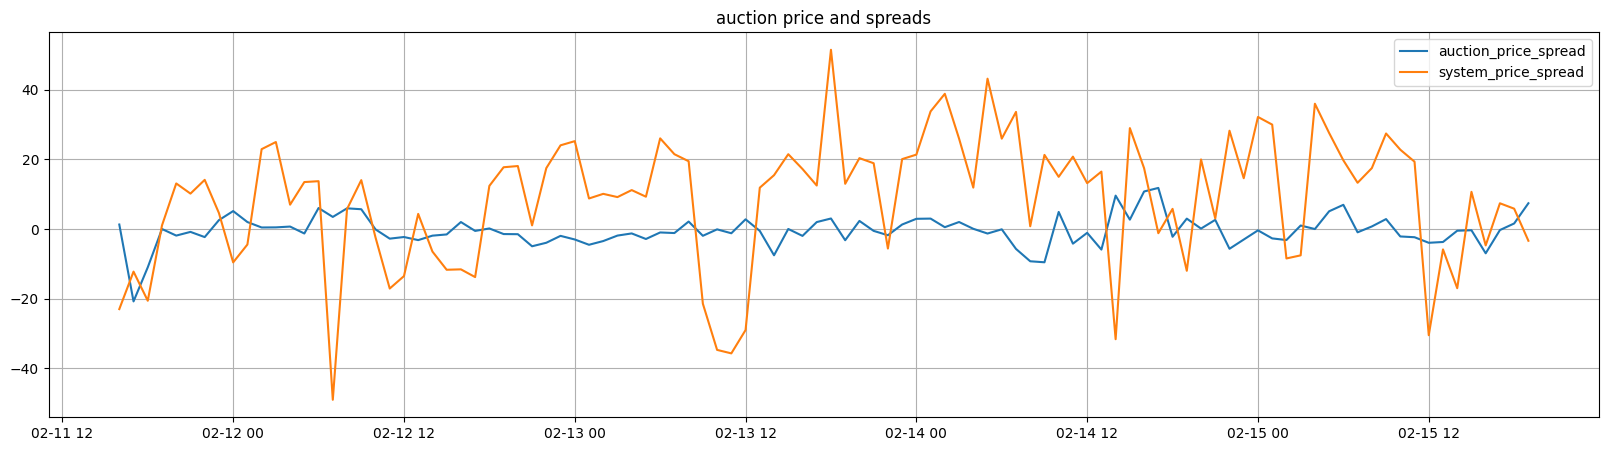

In [334]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['auction_price_spread'][1000:1100], label='auction_price_spread')
plt.plot(auction_data['system_price_spread'][1000:1100], label='system_price_spread')
plt.legend(loc='best')
plt.title(f'auction price and spreads')

spreads are mean reverting and generally much smaller that the prices themeselves. Some very large spikes.

In [335]:
bigmoves=auction_data[auction_data['system_price_spread'].abs()>200]

## Signals from Energy Fundamental Forecasts and their Correlations

In [336]:
forecasts =load_forecasts('../data/raw/forecast_features.csv')
forecasts=preprocess_data(forecasts)

In [337]:
find_loc_null(forecasts)

[]

we look at the correlations within out features

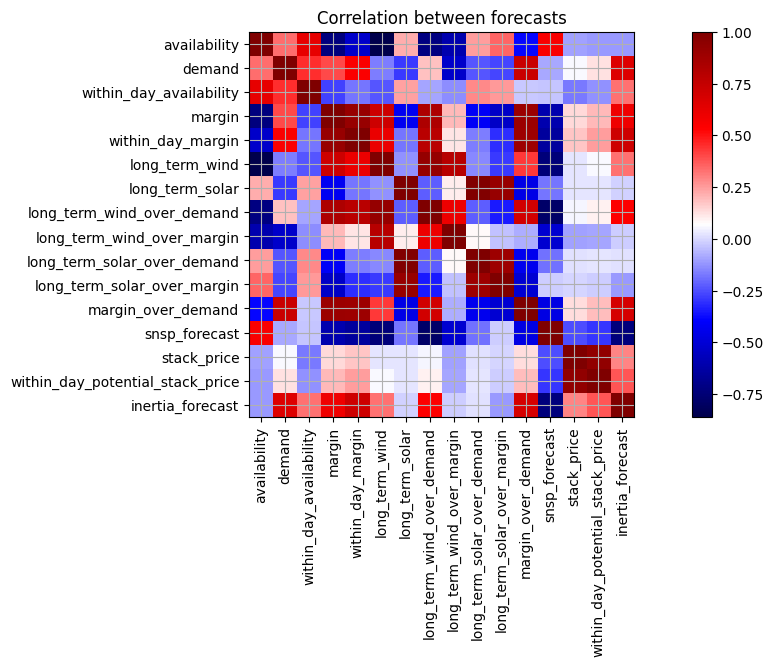

In [338]:
# heat map of correlation between features
plt.figure(figsize=(15,5))
plt.grid()
plt.title('Correlation between forecasts')
plt.imshow(forecasts.corr(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(forecasts.columns)), forecasts.columns, rotation=90)
plt.yticks(range(len(forecasts.columns)), forecasts.columns)
plt.show()

As expected there are strong correlations within the features. Clearly the derived features (e.f. wind over demand) will be correlated to the fundamental features (widn and demand). The price indicators are only weakly correlated with the energy features but are strongly correlated with each other.

Lets look at how correlated the various features are with the auction and system prices.

In [339]:
combined_data = pd.concat([forecasts, auction_data], axis=1)

In [340]:
combined_data_prep=preprocess_data(combined_data)

In [341]:
find_loc_null(combined_data)

[]

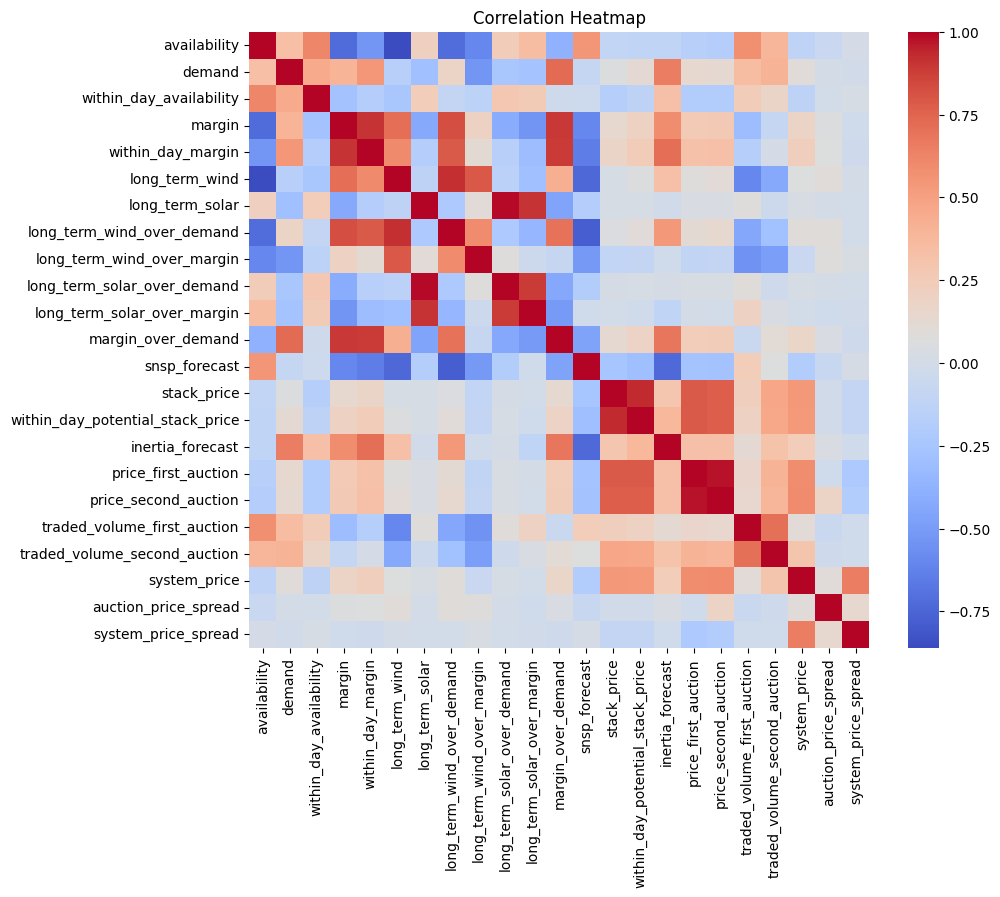

In [342]:
correlation_matrix = combined_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

some light correlations between energy fundamentals and auciton prices and spreads.

In [343]:
combined_bigmoves=combined_data.loc[bigmoves.index]

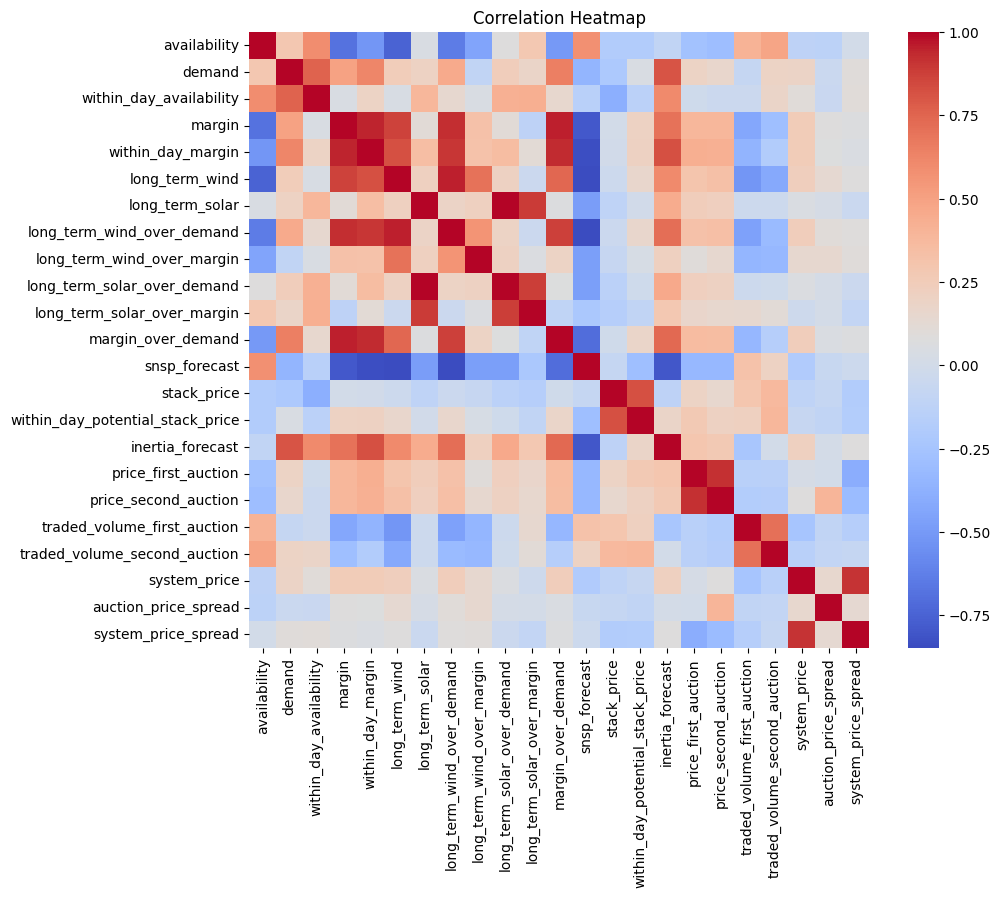

In [344]:
correlation_matrix_bigmoves = combined_bigmoves.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_bigmoves, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Lets build some more custom price indicators

## Price Indicator Engineering

In [33]:
auction_data[auction_data['price_first_auction']<0]['price_first_auction'].min()

np.float64(-24.9)

We see that a lot of the prices are highly skewed towards larger values. We would define the log-prices but unfortunately there are times when prices are negatvie so we cannot define log prices immediately, instead we define log prices after shiofting the timeseries by a positive value e.g. 100 for all prices.

spreads are mean reverting over a shoirter scale! Unlike prices which can trend. Spreads also have a much weaker daily cycle.

Finally standardise all timeseries.

first from the auciton data timeseries we build a lagged 24 hour timeseries

In [34]:
price_data, coeffs=pre_engineer_timeseries(auction_data)


In [35]:
coeffs

mean         std
col                               
price1      157.848524  112.804623
price2      157.359473  114.770582
price3      151.901235  145.256654
log_price1    5.481051    0.362057
log_price2    5.478114    0.364371
log_price3    5.436039    0.414497
spread1      -0.489051   23.870942
spread2      -5.947289  120.629952

price1 = price of auction 1

price2 = price of auction 2

price 3 = system price

spread1 = auction 2 - auction 1

spread2 = system - auction 1

In [36]:
price_data

price1    price2    price3   spread1   spread2  \
date                                                                    
2021-01-01 00:00:00 -0.796497 -0.798371 -0.542152 -0.074607  0.091994   
2021-01-01 01:00:00 -0.843481 -0.805080 -0.550414  0.115163  0.125983   
2021-01-01 02:00:00 -0.902875 -0.844201 -0.670133  0.207744  0.037365   
2021-01-01 03:00:00 -0.955178 -0.913644 -0.558813  0.121028  0.220321   
2021-01-01 04:00:00 -0.956065 -0.944314 -0.667241 -0.022242  0.090585   
...                       ...       ...       ...       ...       ...   
2022-09-12 19:00:00  2.728181  2.441745  1.145641 -1.152487 -1.171679   
2022-09-12 20:00:00  2.306213  2.039639  1.430001 -1.091744 -0.434671   
2022-09-12 21:00:00  1.780525  1.611306  1.177308 -0.666959 -0.247365   
2022-09-12 22:00:00  1.267248  1.031366  1.739422 -1.029744  0.909486   
2022-09-12 23:00:00  0.957864  0.870262  1.562421 -0.342297  0.985663   

                     log_price1  log_price2  log_price3  price1_lag24  \
date                                                                    
2021-01-01 00:00:00   -0.986275   -1.009283   -0.680055           NaN   
2021-01-01 01:00:00   -1.074814   -1.022064   -0.696833           NaN   
2021-01-01 02:00:00   -1.190961   -1.097800   -0.954064           NaN   
2021-01-01 03:00:00   -1.297448   -1.237609   -0.714012           NaN   
2021-01-01 04:00:00   -1.299289   -1.301699   -0.947517           NaN   
...                         ...         ...         ...           ...   
2022-09-12 19:00:00    2.366579    2.220268    1.448000      2.345662   
2022-09-12 20:00:00    2.123766    1.973940    1.675181      2.026969   
2022-09-12 21:00:00    1.787966    1.684690    1.474384      1.481779   
2022-09-12 22:00:00    1.415279    1.237083    1.900269      1.036761   
2022-09-12 23:00:00    1.163654    1.098590    1.774091      1.167962   

                     price2_lag24  ...  spread1_lag168  spread2_lag168  \
date                               ...                                   
2021-01-01 00:00:00           NaN  ...             NaN             NaN   
2021-01-01 01:00:00           NaN  ...             NaN             NaN   
2021-01-01 02:00:00           NaN  ...             NaN             NaN   
2021-01-01 03:00:00           NaN  ...             NaN             NaN   
2021-01-01 04:00:00           NaN  ...             NaN             NaN   
...                           ...  ...             ...             ...   
2022-09-12 19:00:00      2.419091  ...        0.550001        0.782122   
2022-09-12 20:00:00      2.277940  ...        0.020906        0.974860   
2022-09-12 21:00:00      1.952160  ...       -0.442419        1.182354   
2022-09-12 22:00:00      1.329875  ...       -0.082986       -0.439797   
2022-09-12 23:00:00      1.286745  ...       -1.787569       -1.079771   

                     price1_close  price2_close  price3_close  \
date                                                            
2021-01-01 00:00:00           NaN           NaN           NaN   
2021-01-01 01:00:00           NaN           NaN           NaN   
2021-01-01 02:00:00           NaN           NaN           NaN   
2021-01-01 03:00:00           NaN           NaN           NaN   
2021-01-01 04:00:00           NaN           NaN           NaN   
...                           ...           ...           ...   
2022-09-12 19:00:00      1.167962      1.286745      0.851588   
2022-09-12 20:00:00      1.167962      1.286745      0.851588   
2022-09-12 21:00:00      1.167962      1.286745      0.851588   
2022-09-12 22:00:00      1.167962      1.286745      0.851588   
2022-09-12 23:00:00      1.167962      1.286745      0.851588   

                     log_price1_close  log_price2_close  log_price3_close  \
date                                                                        
2021-01-01 00:00:00               NaN               NaN               NaN   
2021-01-01 01:00:00               NaN               NaN               NaN   
2021-0

Text(0.5, 1.0, 'auction price and spreads')

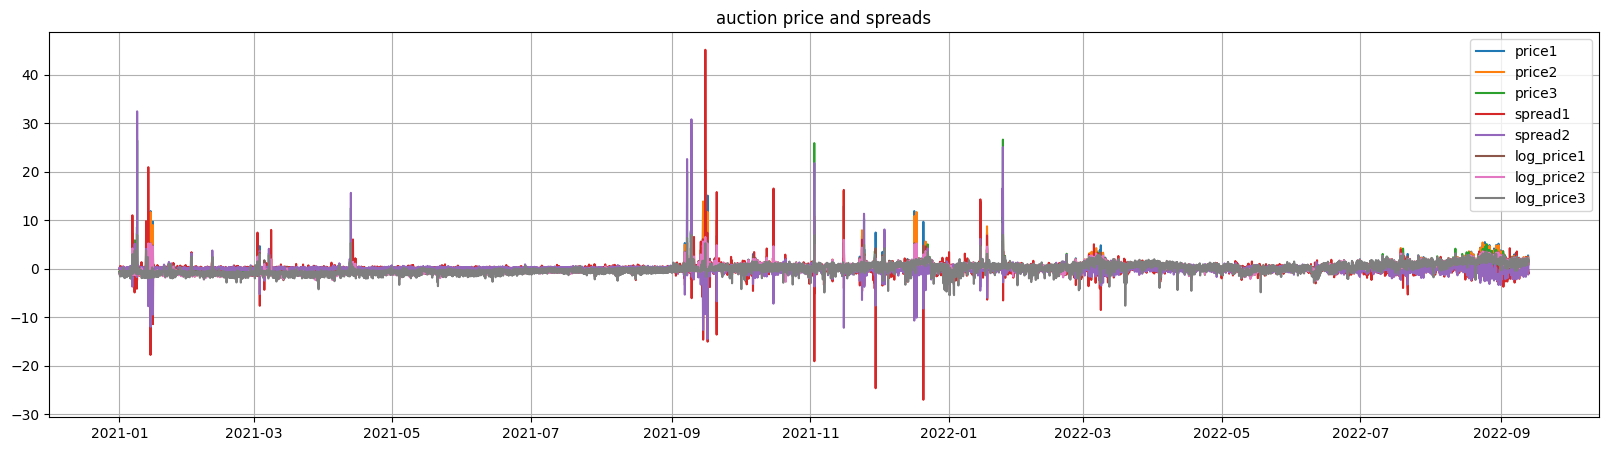

In [37]:
plt.figure(figsize=(20,5))
plt.grid()
for col in price_data.columns:
    if col in ['price1', 'price2', 'price3', 'log_price1', 'log_price2', 'log_price3', 'spread1', 'spread2']:
        plt.plot(price_data[col], label=col)
plt.legend(loc='best')
plt.title(f'auction price and spreads')

We wish to define metrics which measure trend, oscillators and momentum. We define these metrics on the log prices identically, treating such log prices as its own timeseries signal. We will train separate models on the log-prices versus the spreads anyway. 

add indicators all in one go, we will describe these individually below

indicators: 

TREND: Percentage Price Change Moving Average, Average True Range, Moving Average Deviation, Average Directional Movement Index, 

OSCILLATOR: Percentage Range, Relative Strength Index, Moving Average Convergence/Divergence

MOMENTUM: Price Momentum

In [38]:
indicator_methods=[('PCMA_24', 'calculate_PCMA', {'window': 24}),
                   ('PCMA_7', 'calculate_PCMA', {'window': 7*24}),
                   ('ATR_24', 'calculate_ATR', {'window': 24, 'lag': 24}),
                   ('ATR_7', 'calculate_ATR', {'window': 24, 'lag': 7*24}),
                   ('MAD_24', 'calculate_MAD', {'window': 24}),
                   ('MAD_7', 'calculate_MAD', {'window': 7*24}),
                   ('RSTDEV_24', 'calculate_RSTDEV', {'window': 24}),
                   ('RSTDEV_7', 'calculate_RSTDEV', {'window': 7*24}),
                   ('ZSCORE_24', 'calculate_ZSCORE', {'window': 24}),
                   ('ZSCORE_7', 'calculate_ZSCORE', {'window': 7*24}),
                   ('ADX_24', 'calculate_ADX', {'window': 24}),
                   ('ADX_7', 'calculate_ADX', {'window': 7*24}),
                   ('PR_24', 'calculate_PR', {'window': 24}),
                   ('PR_7', 'calculate_PR', {'window': 7*24}),
                   ('RSI_24', 'calculate_RSI', {'window': 24}),
                   ('RSI_7', 'calculate_RSI', {'window': 7*24}),
                   ('MACD_24', 'calculate_MACD', {'window_smaller': 12, 'window_larger': 24}),
                   ('MACD_7', 'calculate_MACD', {'window_smaller': 7*12, 'window_larger': 7*24}),
                   ('MOM_1h', 'calculate_MOM', {'lag':1}),
                   ('MOM_3h', 'calculate_MOM', {'lag':3}),
                   ('MOM_6h', 'calculate_MOM', {'lag':6}),
                      
]           

In [39]:
timeseries=['price1_lag24', 'price2_lag24', 'price2_lag24', 'log_price1_lag24', 'log_price2_lag24', 'log_price3_lag24', 'spread1_lag24', 'spread2_lag24']
price_data=make_new_price_indicators(price_data, timeseries, indicator_methods)

In [40]:
price_data.columns

Index(['price1', 'price2', 'price3', 'spread1', 'spread2', 'log_price1',
       'log_price2', 'log_price3', 'price1_lag24', 'price2_lag24',
       ...
       'spread2_lag24_ADX_7', 'spread2_lag24_PR_24', 'spread2_lag24_PR_7',
       'spread2_lag24_RSI_24', 'spread2_lag24_RSI_7', 'spread2_lag24_MACD_24',
       'spread2_lag24_MACD_7', 'spread2_lag24_MOM_1h', 'spread2_lag24_MOM_3h',
       'spread2_lag24_MOM_6h'],
      dtype='object', length=187)

### Trend Indicators

Trend indicators measure whether prices are rising or falling on average. In our case there is a strong daily cycle dictaing hourly behaviour, so we test whether prices are rising/falling between days i.e. deviating from this behaviour.

1. We first define a 24 hour rolling average percentage price change. We call it a Percentage Price Change Moving Average (PPCMA_24).

Measures the average rising or falling of prices.

Text(0.5, 1.0, 'PCMA for auction_price_difference')

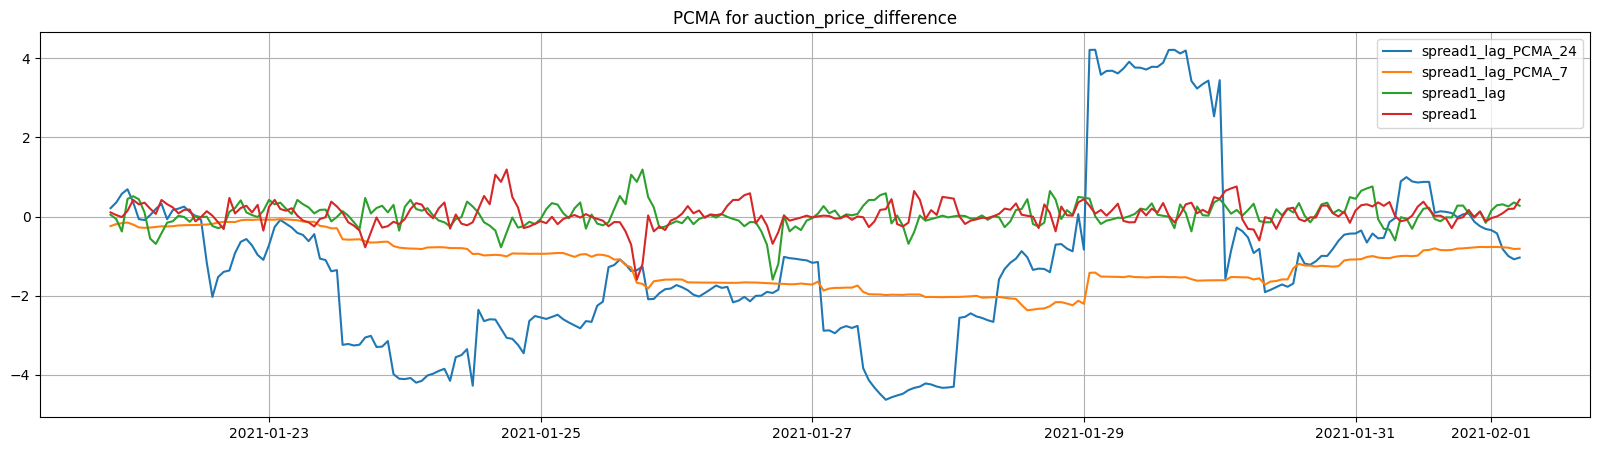

In [41]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(price_data['spread1_lag24_PCMA_24'].iloc[500:750], label='spread1_lag_PCMA_24')
plt.plot(price_data['spread1_lag24_PCMA_7'].iloc[500:750], label='spread1_lag_PCMA_7')
plt.plot(price_data['spread1_lag24'].iloc[500:750], label='spread1_lag')
plt.plot(price_data['spread1'].iloc[500:750], label='spread1')
plt.legend(loc='best')
plt.title(f'PCMA for auction_price_difference')

2. We also define a Moving Average Deviation (MAD): A trend energy market indicator that uses Price Moving Average (PMA) to calculate the deviation rate of the current electricity price from PMA. The moving average deviation is calculated using a rolling 24-hour window.

Positive MAD means the price is breaking out above of its averages.

3. Average Directional Movement Index (ADX): A trend energy market indicator measuring the strength of the trend, grouping the two directional movement indexes depending on whether price change, calculated as current electricity price minus previous 24-hour price, is grouped as a Price Up (positive) change or Price Down (negative) change. The two indexes are combined and smoothed with a moving average.

Another trend/oscilator is the Z score whihc measures the distance from the rolling mean in units of the STDEV

### Volatility Indicators

4. We now define a volatility metric which looks are the maximum price changes within 24 hours.

We define the Average True Range (ATR): A trend energy market indicator measuring price volatility. Over a 24-hour window, there are three different values calculated: (a) highest price minus lowest price; (b) highest price minus a 24-hour lagged electricity price; and (c) lowest price minus a 24-hour lagged electricity price. The maximum of these three values is selected for each trading hour and averaged over a rolling 24-hour window. 

High ATR means high volatility.

Text(0.5, 1.0, 'ATR for first auction log price')

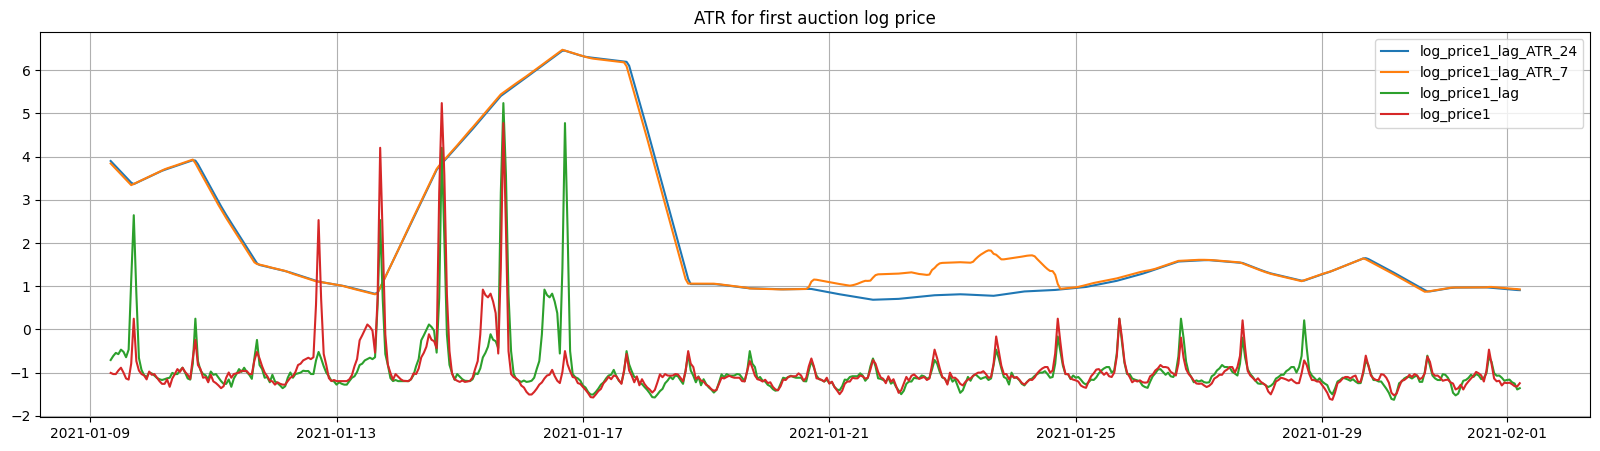

In [42]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(price_data['log_price1_lag24_ATR_24'].iloc[200:750], label='log_price1_lag_ATR_24')
plt.plot(price_data['log_price1_lag24_ATR_7'].iloc[200:750], label='log_price1_lag_ATR_7')
plt.plot(price_data['log_price1_lag24'].iloc[200:750], label='log_price1_lag')
plt.plot(price_data['log_price1'].iloc[200:750], label='log_price1')
plt.legend(loc='best')
plt.title(f'ATR for first auction log price')

Another volatility indicator is the rolling STDEV

### Oscilator indicators

5. Percentage Range (PR): An oscillator energy market indicator that finds a relationship between current electricity price and the highest/lowest prices. This indicator oscillates between 0 and 100, with a value tending towards 100 signifying that the current electricity price is closer to the lowest price and a value towards 0 signifying that the current electricity price is tending towards the highest price. The percentage range is calculated over a 24-hour window.

6. Relative Strength Index (RSI): An oscillator energy market indicator that compares recent price gains to recent price losses. This indicator oscillates between 0 and 100, with a value close to 100 signifying that the majority of electricity price units within the period are Price Up and a value close to 0 signifying that the majority of electricity price units are Price Down. Price Up is the average of the previous 24 h when price difference increased, and Price Down is the average of the previous 24 h when price difference decreased.

7. Moving Average Convergence/Divergence (MACD): An oscillator energy market indicator that takes into consideration the strength, direction, and duration of the trend as well as price momentum. It compares moving averages of previous price values with rolling window of two different sizes e.g. 12 and 24 for the 24-hour model.

### Momentum Indicators

Finally, we define a momentum indicator of short term price gains.

8. Momentum (MOM): A momentum energy market indicator that evaluates the power of the market by examining the current electricity price with the previous trading value (1 h before). 

This may not be very useful since the prices exhibit a 24 hour cycle and bids and offers are placed in each auction for 24 hours simulaneously so no one in the market is looking at hour by hour price changes. Still this momentum measure should help the model learn the 24 hour cycle and breakouts from it.

May be useful for system_price which involves real time balancing and so can have high or low momentum hour by hour based on NESO decision making to balance the health of the grid.

### Correlations and IVF

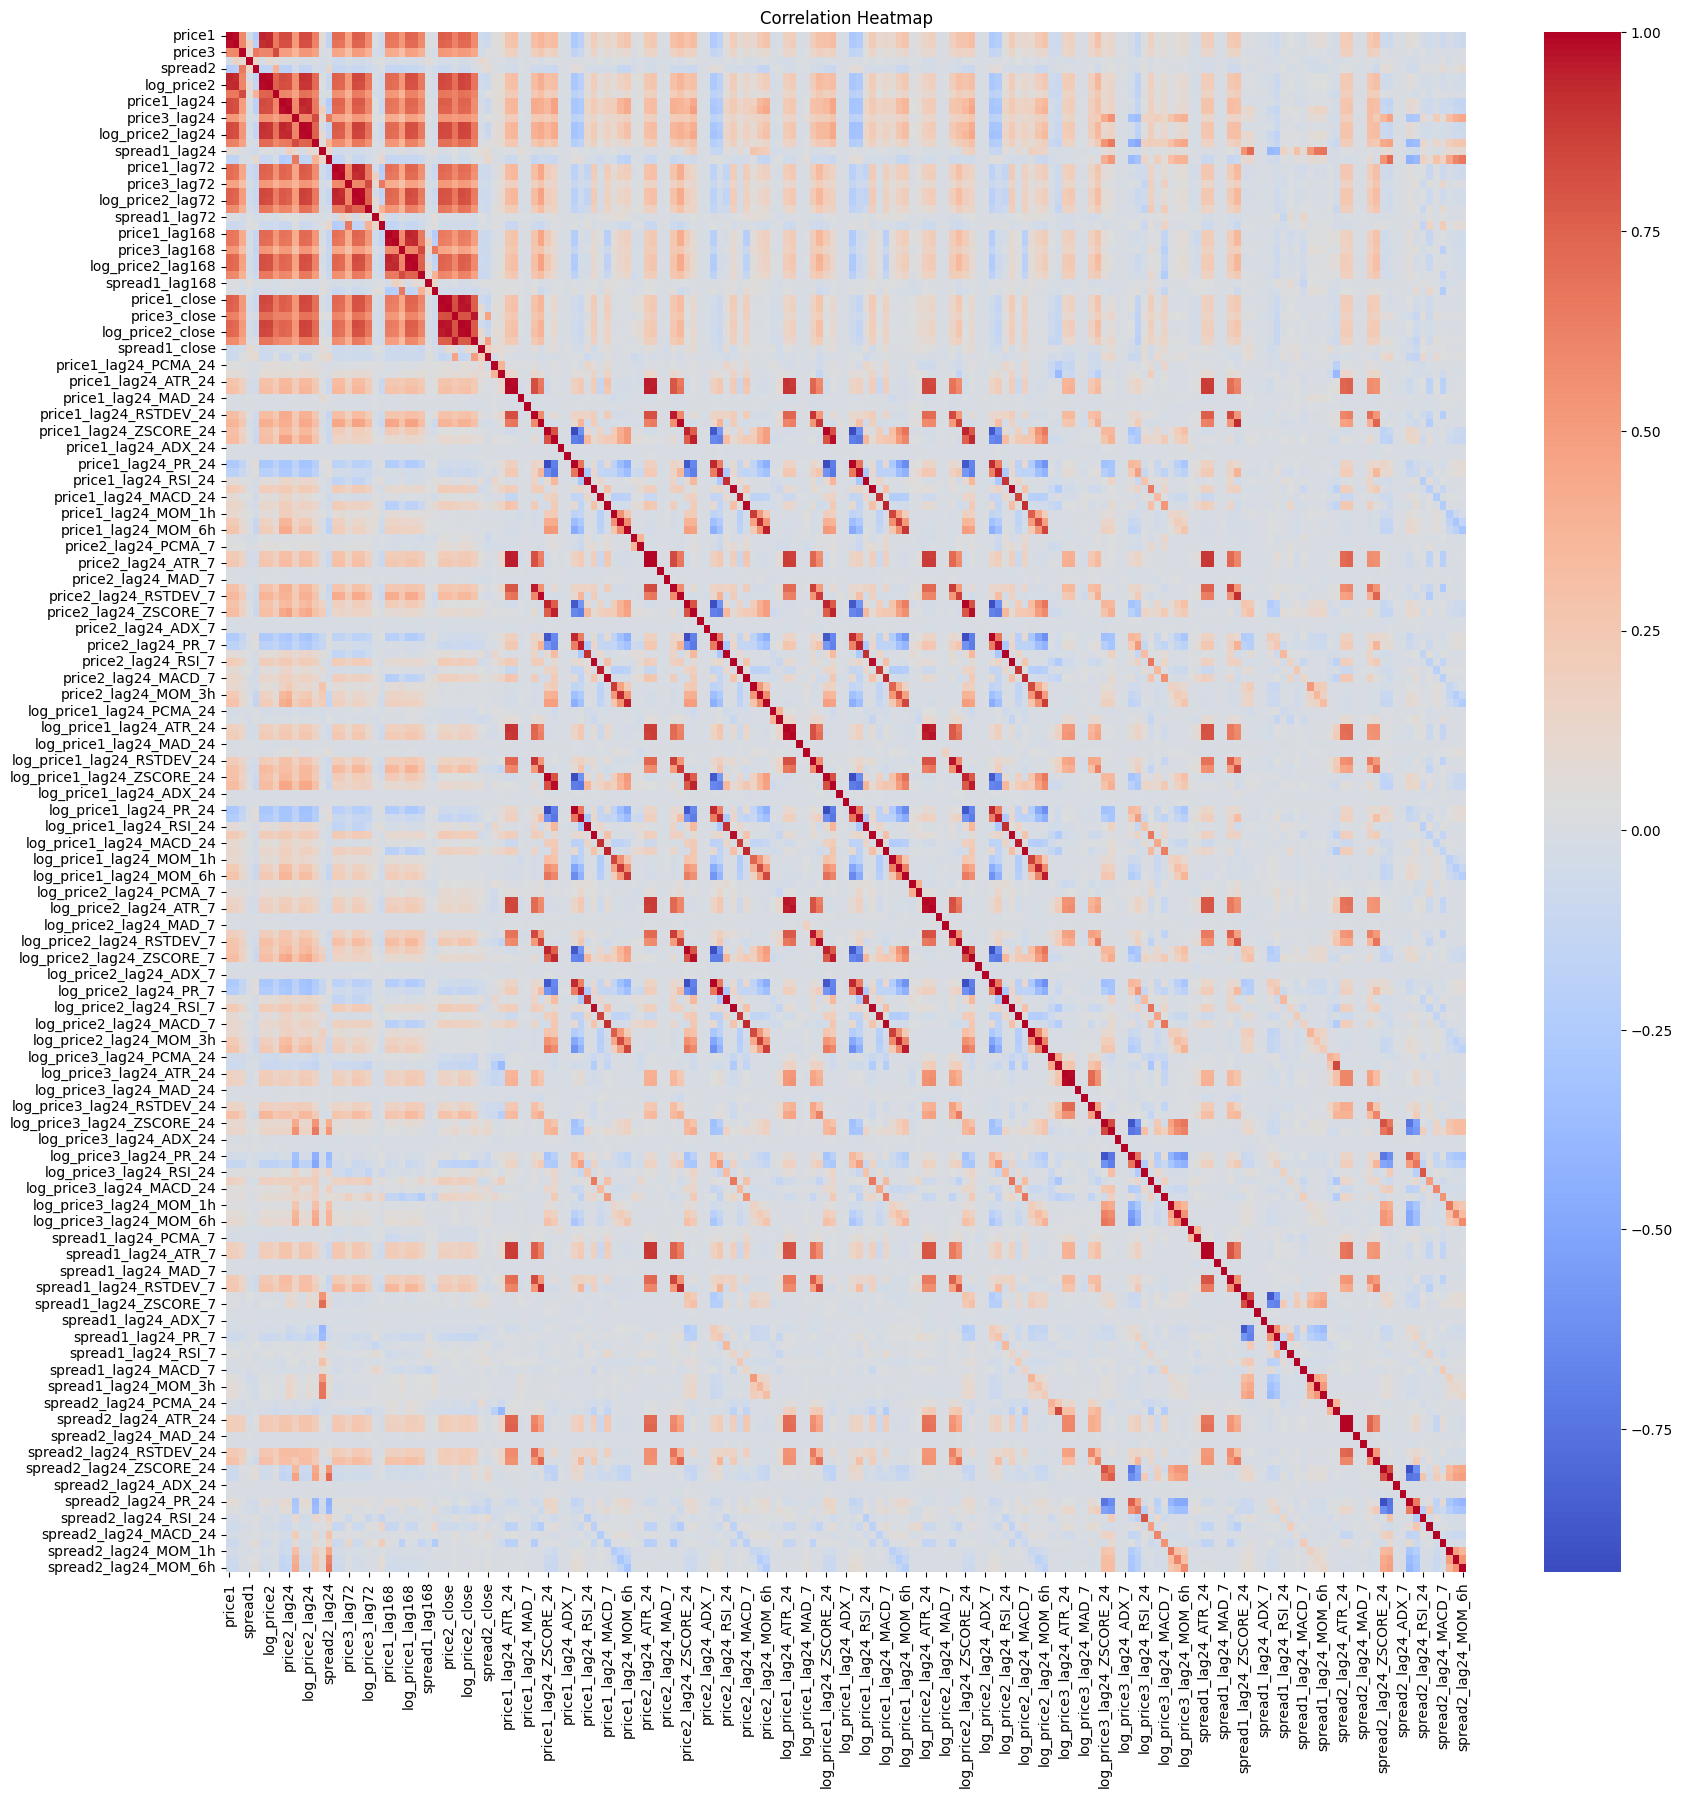

In [43]:
correlation_matrix = price_data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

VIF can show degree of multi-collinearity

In [44]:
calculate_VIF(forecasts)


features   vif_Factor
0                             demand  5607.169460
1            within_day_availability  5366.571569
3                  within_day_margin   786.606041
4                     long_term_wind   678.770287
2                             margin   520.397589
14                  inertia_forecast   256.430542
10                margin_over_demand   249.383061
6         long_term_wind_over_demand   192.680869
5                    long_term_solar   185.749117
11                     snsp_forecast   139.390639
8        long_term_solar_over_demand   107.846634
7         long_term_wind_over_margin    60.187363
12                       stack_price    38.634528
13  within_day_potential_stack_price    37.804729
9        long_term_solar_over_margin    12.129539

## PCA

In [45]:
combined=pd.concat([price_data, forecasts], axis=1).dropna(axis=0, how='any')
combined.columns

Index(['price1', 'price2', 'price3', 'spread1', 'spread2', 'log_price1',
       'log_price2', 'log_price3', 'price1_lag24', 'price2_lag24',
       ...
       'long_term_solar', 'long_term_wind_over_demand',
       'long_term_wind_over_margin', 'long_term_solar_over_demand',
       'long_term_solar_over_margin', 'margin_over_demand', 'snsp_forecast',
       'stack_price', 'within_day_potential_stack_price', 'inertia_forecast'],
      dtype='object', length=203)

In [46]:
X = combined.drop(columns=['price1', 'price2', 'price3', 'log_price1', 'log_price2', 'log_price3', 'spread1', 'spread2'])
y = combined[['price1', 'price2', 'price3','log_price1', 'log_price2', 'log_price3', 'spread1', 'spread2']]
explained_variance, principal_compoents = calculate_explained_variance(X)
print(principal_compoents.head())

     price1_lag24  price2_lag24  price3_lag24  log_price1_lag24  \
PC1      0.165229      0.164029      0.115051          0.171800   
PC2     -0.050204     -0.054171     -0.042350         -0.045857   
PC3      0.071418      0.065120      0.060554          0.092980   
PC4     -0.040828     -0.027009      0.170623         -0.021340   
PC5     -0.023071     -0.017764      0.007221         -0.033737   

     log_price2_lag24  log_price3_lag24  spread1_lag24  spread2_lag24  \
PC1          0.171126          0.134584       0.004603      -0.018871   
PC2         -0.050490         -0.044945      -0.022746      -0.003319   
PC3          0.089744          0.090389      -0.026490       0.005100   
PC4         -0.011436          0.177846       0.065500       0.248417   
PC5         -0.027396          0.001307       0.024684       0.031150   

     price1_lag72  price2_lag72  ...  long_term_solar  \
PC1      0.149399      0.146980  ...         0.015778   
PC2     -0.008990     -0.010417  ...        

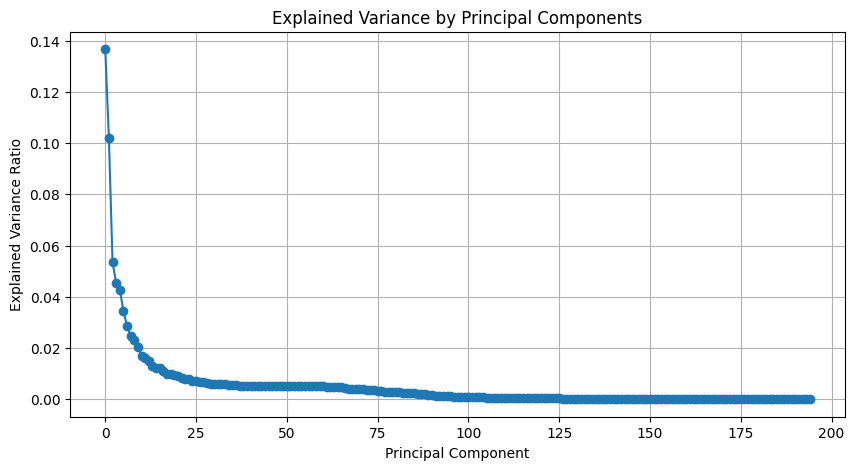

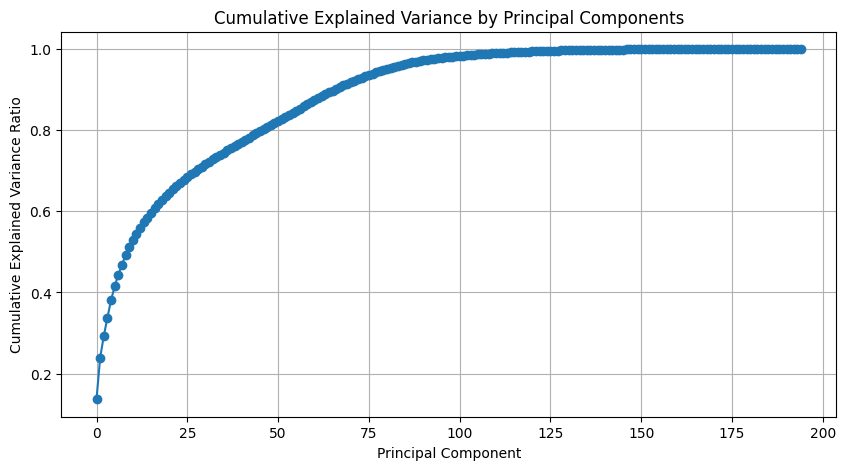

In [47]:
# calculate portion of explained variance
plt.figure(figsize=(10, 5))
plt.plot(explained_variance, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()
    
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()

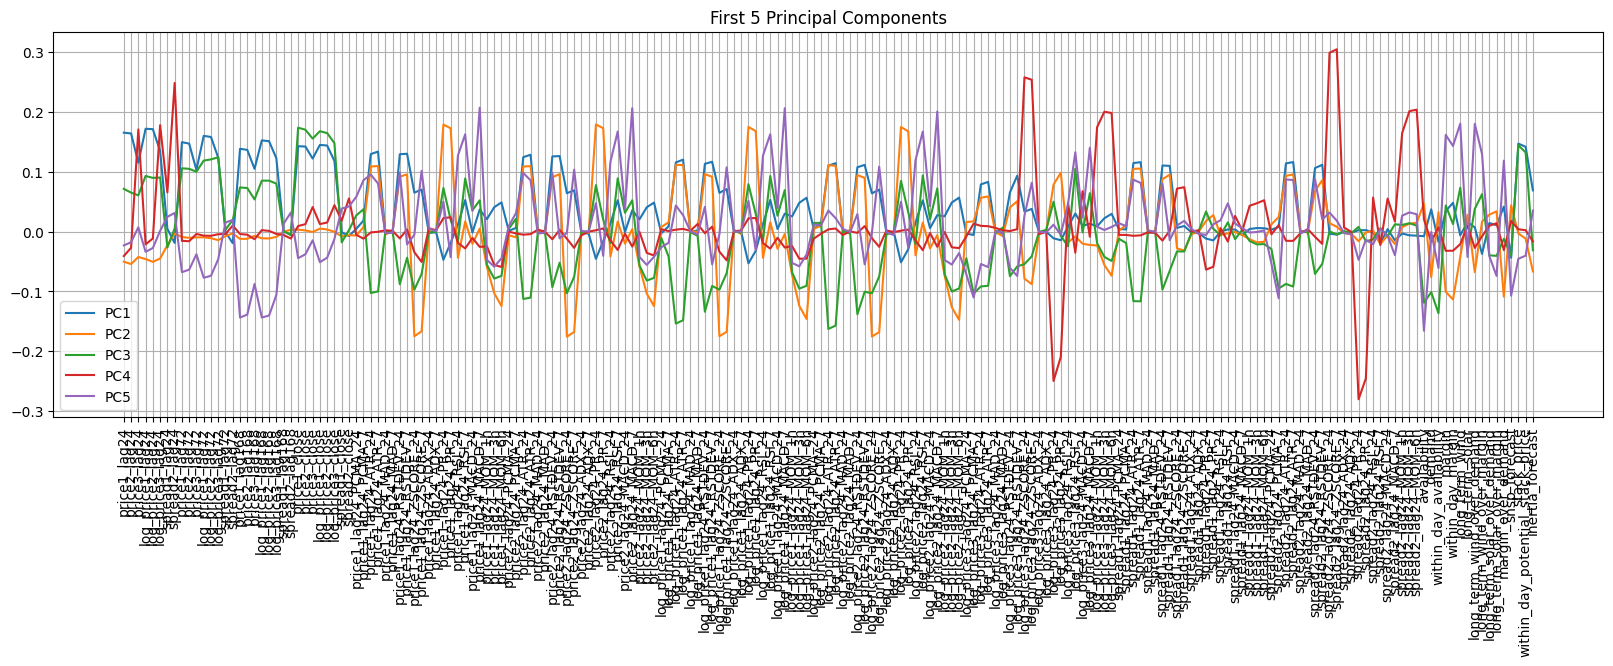

In [48]:
# plot the first 5 principal components
plt.figure(figsize=(20, 5))
plt.grid()
for i in range(5):
    plt.plot(principal_compoents.iloc[i], label=f'PC{i+1}')
#set x axis labels
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.title('First 5 Principal Components')
plt.show()


In [49]:
low_variance_features=find_low_variance_features(principal_compoents, podium=10, threshold=0.1)
low_variance_features
    

['spread1_lag72',
 'spread2_lag72',
 'spread1_lag168',
 'spread2_lag168',
 'spread1_close',
 'spread2_close',
 'price1_lag24_PCMA_24',
 'price1_lag24_PCMA_7',
 'price1_lag24_MAD_24',
 'price1_lag24_MAD_7',
 'price1_lag24_ZSCORE_24',
 'price1_lag24_ADX_24',
 'price1_lag24_ADX_7',
 'price1_lag24_MOM_6h',
 'price2_lag24_PCMA_24',
 'price2_lag24_PCMA_7',
 'price2_lag24_MAD_24',
 'price2_lag24_MAD_7',
 'price2_lag24_ZSCORE_24',
 'price2_lag24_ADX_24',
 'price2_lag24_ADX_7',
 'price2_lag24_MOM_6h',
 'log_price1_lag24_PCMA_24',
 'log_price1_lag24_PCMA_7',
 'log_price1_lag24_MAD_24',
 'log_price1_lag24_MAD_7',
 'log_price1_lag24_ZSCORE_24',
 'log_price1_lag24_ADX_24',
 'log_price1_lag24_ADX_7',
 'log_price1_lag24_MOM_6h',
 'log_price2_lag24_PCMA_24',
 'log_price2_lag24_PCMA_7',
 'log_price2_lag24_MAD_24',
 'log_price2_lag24_MAD_7',
 'log_price2_lag24_ZSCORE_24',
 'log_price2_lag24_ADX_24',
 'log_price2_lag24_ADX_7',
 'log_price2_lag24_MOM_3h',
 'log_price2_lag24_MOM_6h',
 'log_price3_lag24_PCM

We opt to not drop features directly since even though some features have low variance, e.g. indicators of the spreads, they may provide crucial signals to predict the targets.

Instead we keep the first 40 principal components, this keeps 80% of the variance.

In [50]:
X_post_auction1 = combined.drop(columns=['price2', 'price3','log_price2', 'log_price3', 'spread1', 'spread2'])
y_post_auction1 = combined[['price2', 'price3','log_price2', 'log_price3', 'spread1', 'spread2']]

In [51]:
X_pca=transform_data_to_PCA(X, 20)
X_pca.head()

PC1        PC2        PC3       PC4        PC5  \
date                                                                       
2021-01-15 23:00:00  6.693340  21.827317  -8.666115  0.707546  12.258357   
2021-01-16 00:00:00  8.325423  18.465415 -11.006249  2.103011  10.455194   
2021-01-16 01:00:00  9.224199  16.095217 -12.751692 -0.761856   9.163886   
2021-01-16 02:00:00  9.277878  15.700865 -13.329377 -1.713668   8.688999   
2021-01-16 03:00:00  9.611229  15.125485 -13.724284  0.265783   8.525413   

                          PC6       PC7       PC8       PC9      PC10  \
date                                                                    
2021-01-15 23:00:00  8.838213  1.406186  1.773125 -4.982014  1.299155   
2021-01-16 00:00:00  6.005748 -0.838555  0.702939 -4.907844  1.650054   
2021-01-16 01:00:00  3.769242 -1.482743 -0.043277 -4.786165  1.381284   
2021-01-16 02:00:00  3.106977 -1.826432 -0.270821 -4.672656  1.135297   
2021-01-16 03:00:00  2.661419 -2.077703 -1.214522 -4.513788  1.297734   

                         PC11      PC12      PC13      PC14      PC15  \
date                                                                    
2021-01-15 23:00:00  4.222947  1.380521 -2.789529 -9.255962  1.453264   
2021-01-16 00:00:00  2.605904  0.268018 -2.714287 -7.833458  0.966006   
2021-01-16 01:00:00  1.449829 -1.066698 -2.459895 -5.743822  0.367084   
2021-01-16 02:00:00  0.770728 -1.564403 -2.506181 -5.285902  0.316226   
2021-01-16 03:00:00  0.258999 -1.577067 -2.588497 -5.362800  0.269177   

                          PC16      PC17      PC18      PC19      PC20  
date                                                                    
2021-01-15 23:00:00 -10.864181 -8.635424 -3.767713 -6.386039  1.304935  
2021-01-16 00:00:00  -6.496852 -5.418747 -0.835399 -1.752005 -0.034653  
2021-01-16 01:00:00  -2.901909 -2.338313  1.646603  1.039841 -1.204117  
2021-01-16 02:00:00  -1.680461 -1.399623  2.111107  1.788237 -1.301734  
2021-01-16 03:00:00  -1.264926 -0.833452  2.458616  2.097856 -1.459962

In [52]:
X_pa1_pca=transform_data_to_PCA(X_post_auction1, 20)
X_pa1_pca.head()

PC1        PC2        PC3       PC4        PC5  \
date                                                                       
2021-01-15 23:00:00  5.268767  22.238030  -9.025100  0.741952  11.976684   
2021-01-16 00:00:00  6.891152  18.980722 -11.490241  2.102262  10.142070   
2021-01-16 01:00:00  7.802894  16.669407 -13.261265 -0.789382   8.866441   
2021-01-16 02:00:00  7.834225  16.287446 -13.840669 -1.751095   8.396255   
2021-01-16 03:00:00  8.150258  15.736230 -14.290642  0.224706   8.209615   

                          PC6       PC7       PC8       PC9      PC10  \
date                                                                    
2021-01-15 23:00:00  8.931959  1.449679  1.787454 -4.968239  1.297317   
2021-01-16 00:00:00  6.087296 -0.797895  0.725036 -4.891070  1.652488   
2021-01-16 01:00:00  3.843609 -1.443879 -0.020576 -4.768271  1.385195   
2021-01-16 02:00:00  3.178288 -1.788853 -0.247944 -4.655049  1.139774   
2021-01-16 03:00:00  2.731216 -2.043124 -1.190346 -4.494429  1.303820   

                         PC11      PC12      PC13      PC14      PC15  \
date                                                                    
2021-01-15 23:00:00  4.236307  1.273113 -2.789880 -9.364835 -9.637543   
2021-01-16 00:00:00  2.614263  0.209043 -2.716439 -7.889118 -5.732661   
2021-01-16 01:00:00  1.445446 -1.088820 -2.461022 -5.757104 -2.451728   
2021-01-16 02:00:00  0.760642 -1.569542 -2.506906 -5.284276 -1.407420   
2021-01-16 03:00:00  0.249627 -1.572190 -2.589997 -5.357227 -1.039579   

                         PC16      PC17      PC18      PC19      PC20  
date                                                                   
2021-01-15 23:00:00 -4.235014 -8.971035 -4.094252 -6.340574  1.412453  
2021-01-16 00:00:00 -2.432214 -5.694639 -0.937342 -1.787578  0.086287  
2021-01-16 01:00:00 -1.125805 -2.545126  1.683496  0.947724 -1.101313  
2021-01-16 02:00:00 -0.549597 -1.581578  2.185341  1.690233 -1.212765  
2021-01-16 03:00:00 -0.379616 -1.013355  2.550378  1.998734 -1.382266

## Price Forecasting

In [75]:
cv_folds=timeseries_train_test_split(X_pca, y, 5)

Fold 0:
  Train: index=[   0    1    2 ... 2418 2419 2420]
  Test:  index=[2421 2422 2423 ... 4838 4839 4840]
Fold 1:
  Train: index=[   0    1    2 ... 4838 4839 4840]
  Test:  index=[4841 4842 4843 ... 7258 7259 7260]
Fold 2:
  Train: index=[   0    1    2 ... 7258 7259 7260]
  Test:  index=[7261 7262 7263 ... 9678 9679 9680]
Fold 3:
  Train: index=[   0    1    2 ... 9678 9679 9680]
  Test:  index=[ 9681  9682  9683 ... 12098 12099 12100]
Fold 4:
  Train: index=[    0     1     2 ... 12098 12099 12100]
  Test:  index=[12101 12102 12103 ... 14518 14519 14520]


In [76]:
model_config=[('XGBoost', {}),
              ('RandomForest', {}),
              ('LinearRegression', {}),
              ('Lasso', {}),
              ('MLPRegressor', {})
]

trained_models_price1, evals_price1=compare_models(model_config, cv_folds, 'log_price1')

Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: RandomForest
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: LinearRegression
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: Lasso
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: MLPRegressor
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:


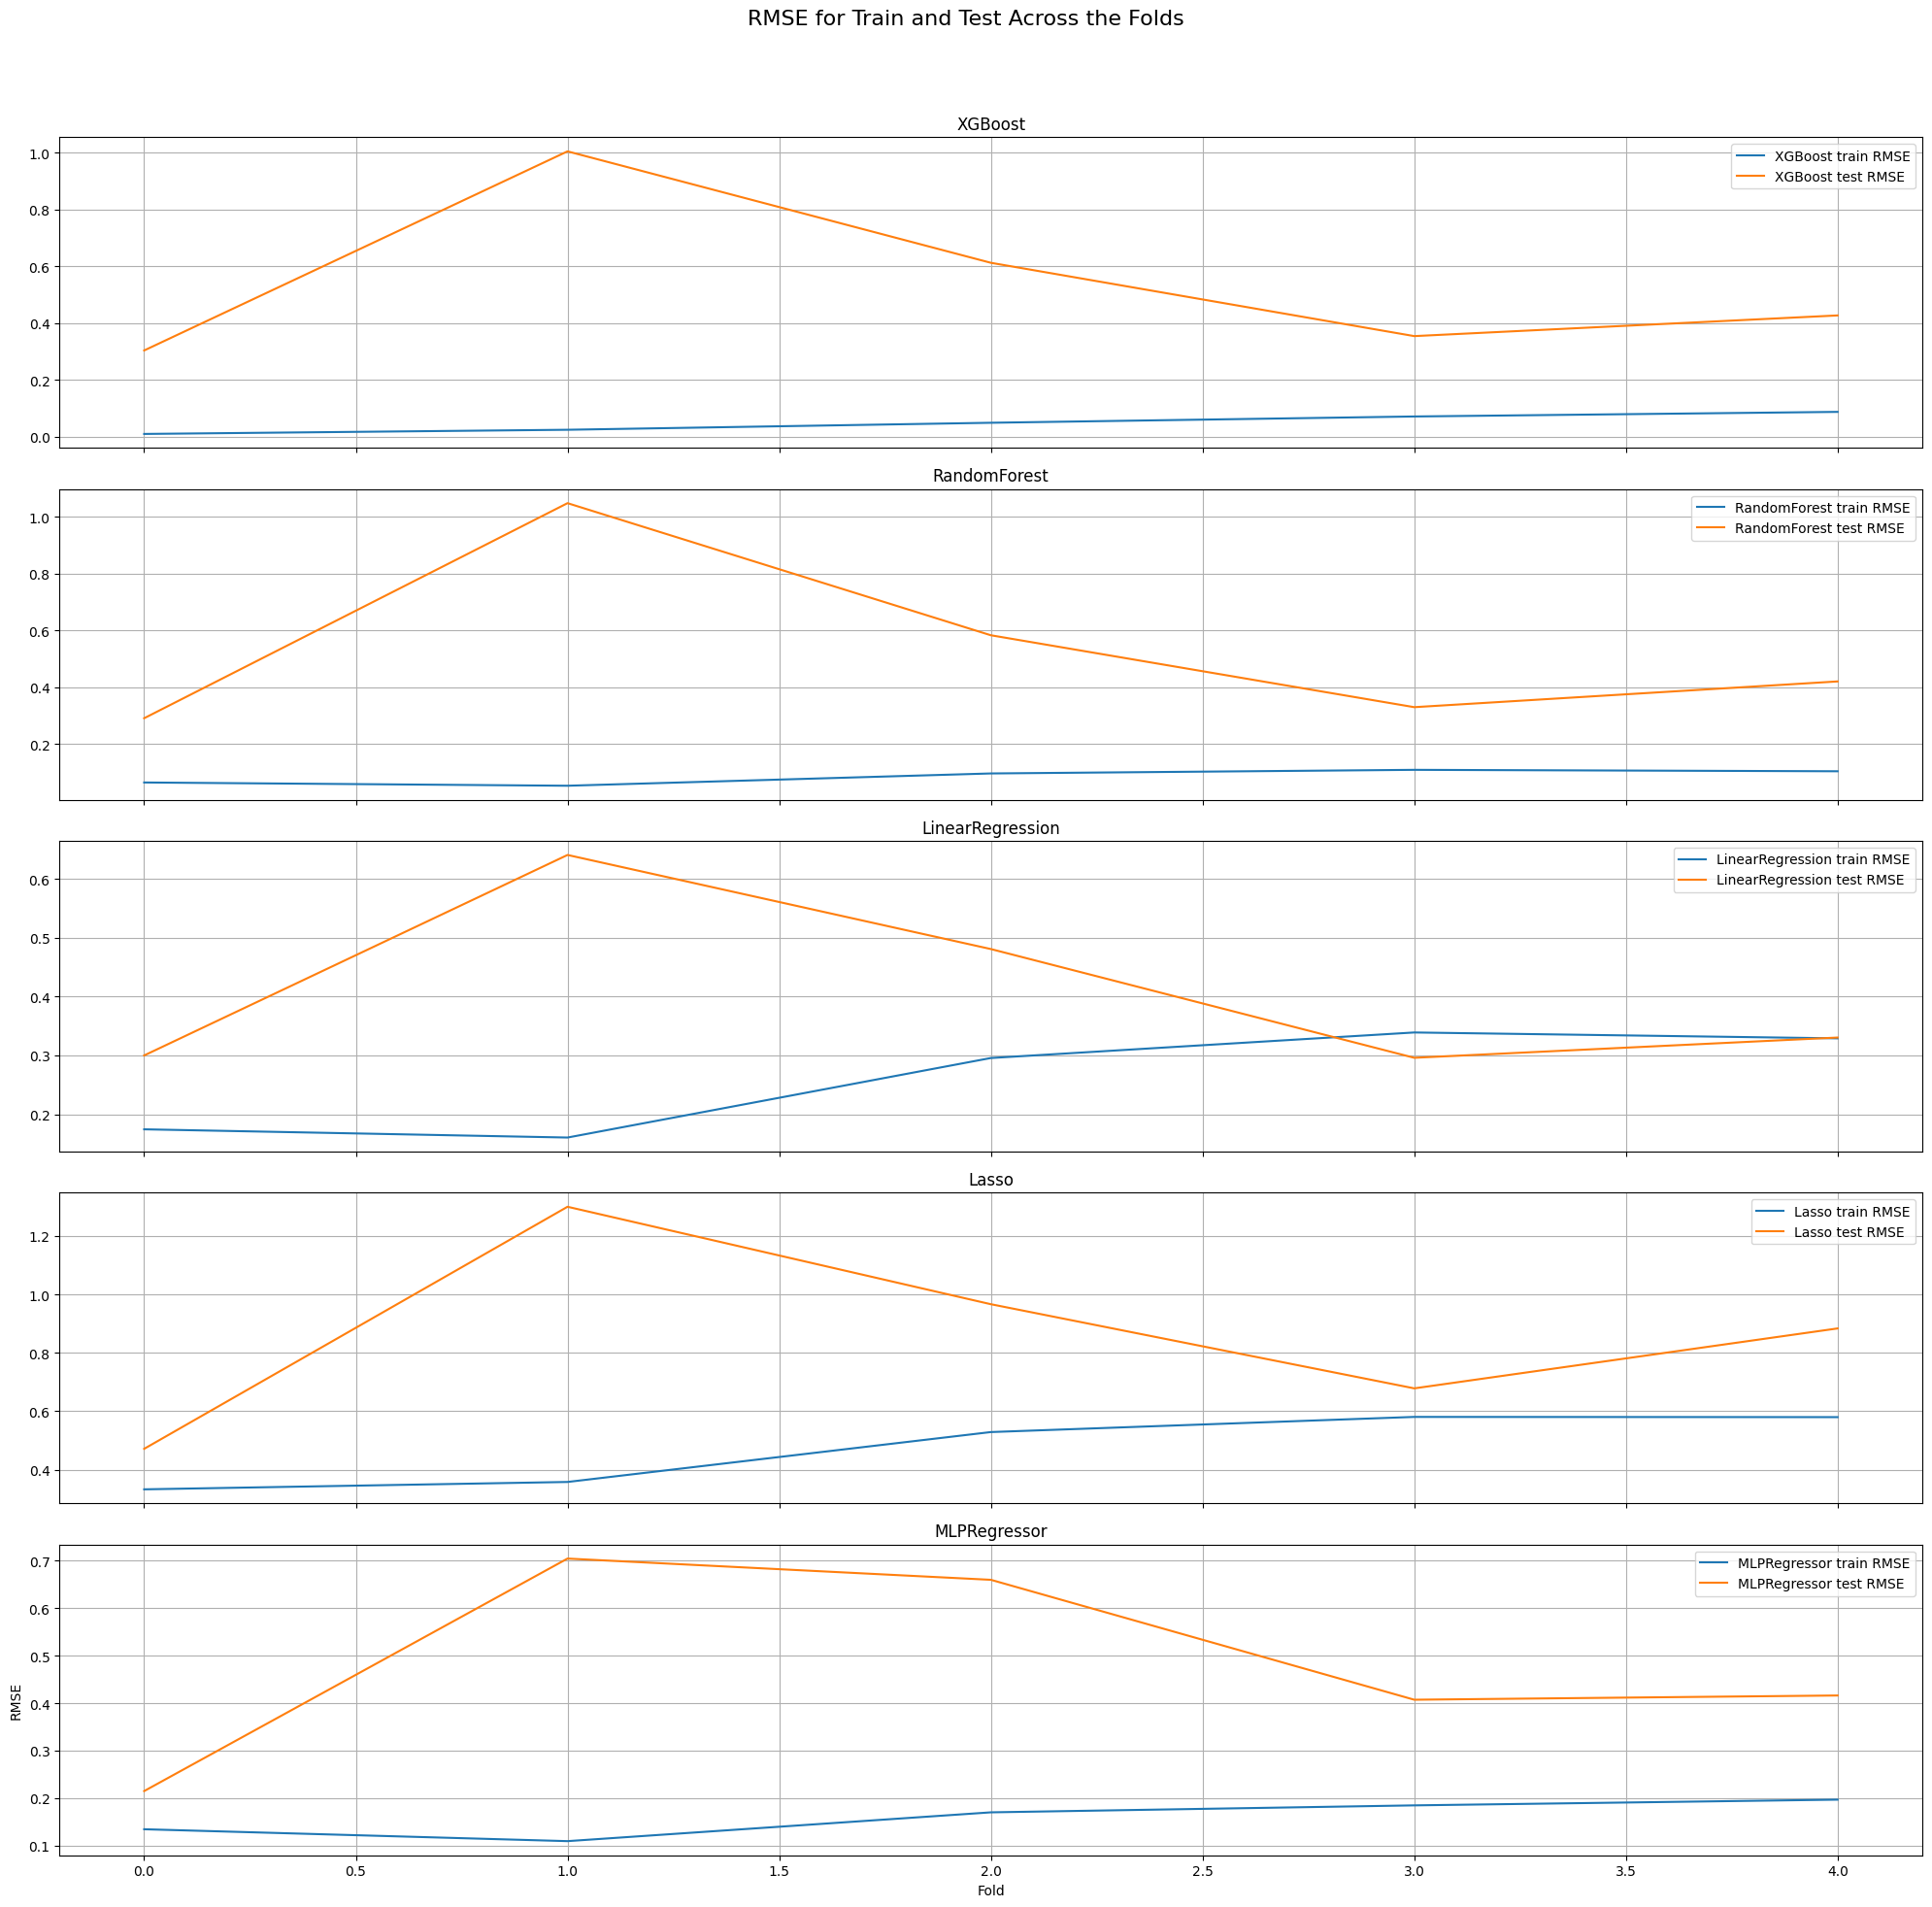

In [77]:
# plot the RMSE for train and test across the folds on separate graphs
fig, axes = plt.subplots(5, 1, figsize=(20, 20), sharex=True)
fig.suptitle('RMSE for Train and Test Across the Folds', fontsize=16)

# Train RMSE
for i, (model_name, df) in enumerate(evals_price1.items()):
    axes[i].plot(df['RMSE_train'], label=f'{model_name} train RMSE')
    axes[i].plot(df['RMSE_test'], label=f'{model_name} test RMSE')
    axes[i].set_title(model_name)
    axes[i].grid()
    axes[i].legend(loc='best')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

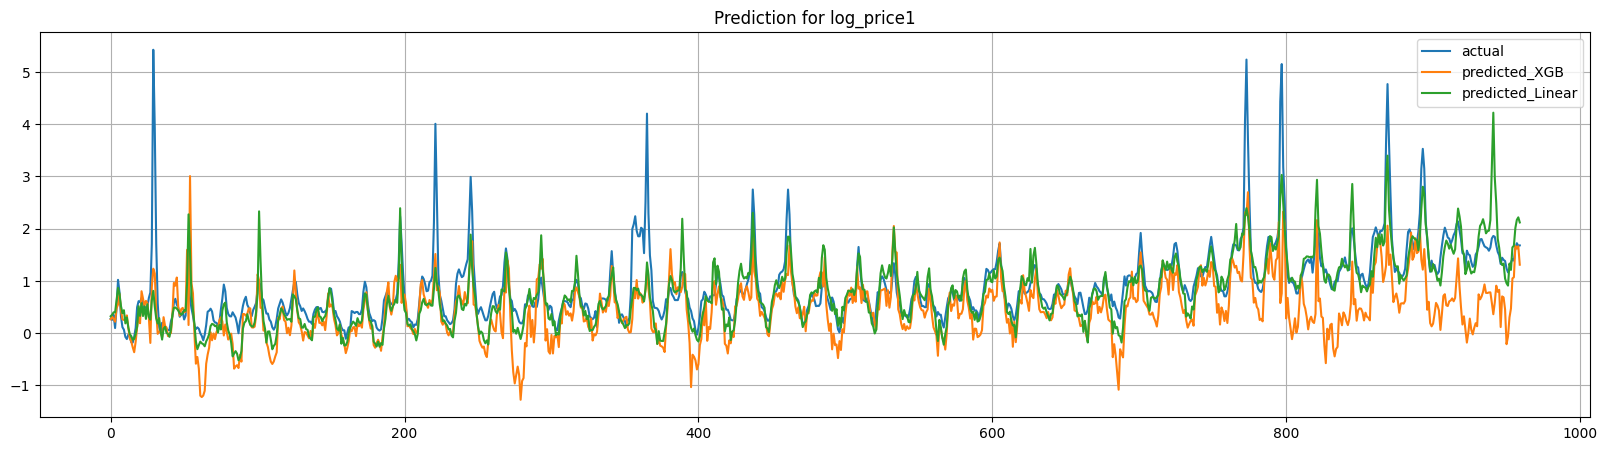

In [78]:
X_test=cv_folds[2][2]
y_test=cv_folds[2][3]['log_price1']
y_pred_XGB=trained_models_price1['XGBoost'][2].predict(X_test)
y_pred_linear=trained_models_price1['LinearRegression'][2].predict(X_test)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test.values)[0:960], label='actual')
plt.plot(y_pred_XGB[0:960], label='predicted_XGB')
plt.plot(y_pred_linear[0:960], label='predicted_Linear')
plt.legend(loc='best')
plt.title('Prediction for log_price1')
plt.show()

Lin reg seems to perform best out of the box and is best when trained on all the data, otherwise it overfits and learns the randomness of the training data.

 The other models are over fitting even when trained on the full timeseries we can see this since the accuracy on training data is much lower than on the test data! Lets test on spreads.

 However even when not overfitting the lin reg model doesnt peform much better than the overfitted models.

 We hence keep it as a baseline and instead try to regularise the XGboost model, since it is quick to train.

 lets test on the spreads!


In [79]:
model_config=[('XGBoost', {}),
              ('LinearRegression', {}),
]

trained_models_spread, evals_spread=compare_models(model_config, cv_folds, 'spread1')

Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: LinearRegression
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:


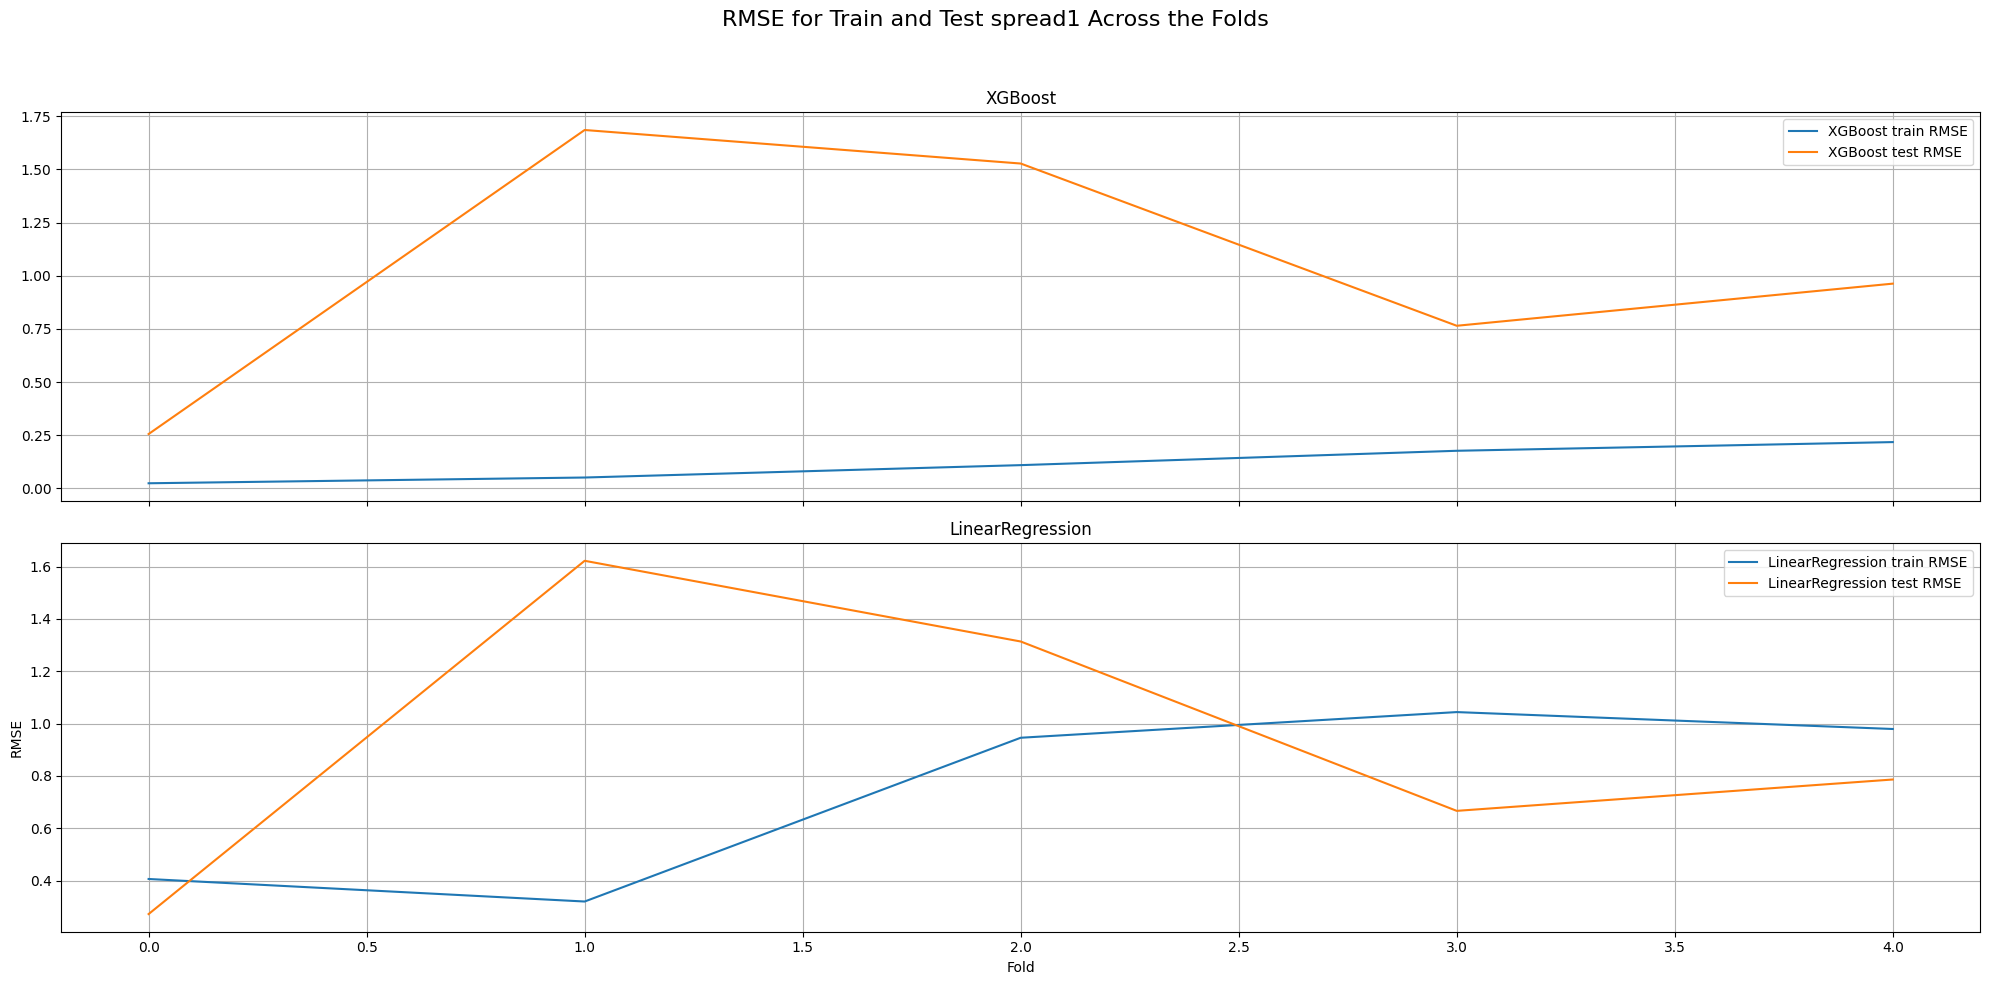

In [80]:
# plot the RMSE for train and test across the folds on separate graphs
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
fig.suptitle('RMSE for Train and Test spread1 Across the Folds', fontsize=16)

# Train RMSE
for i, (model_name, df) in enumerate(evals_spread.items()):
    axes[i].plot(df['RMSE_train'], label=f'{model_name} train RMSE')
    axes[i].plot(df['RMSE_test'], label=f'{model_name} test RMSE')
    axes[i].set_title(model_name)
    axes[i].grid()
    axes[i].legend(loc='best')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

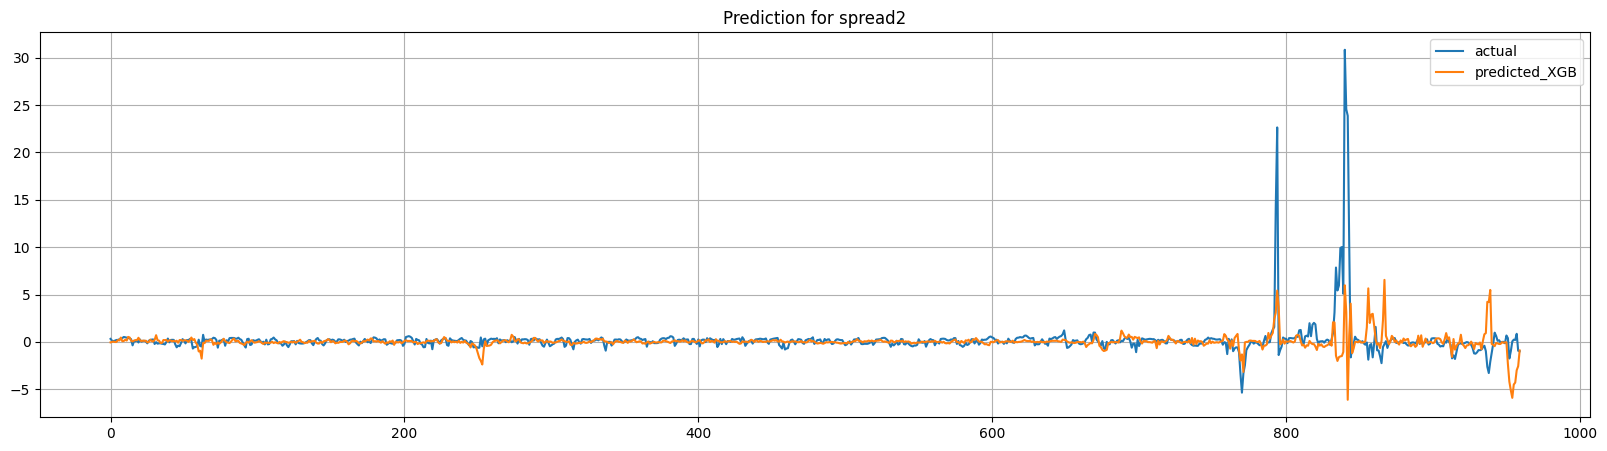

In [81]:
X_test=cv_folds[1][2]
y_test=cv_folds[1][3]
y_pred_XGB=trained_models_spread['XGBoost'][2].predict(X_test)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['spread2'].values)[0:960], label='actual')
plt.plot(y_pred_XGB[0:960], label='predicted_XGB')
plt.legend(loc='best')
plt.title('Prediction for spread2')
plt.show()

MODELS NOT ABLE TO LEARN SPREADS DIRECTLY. Focus on learning prices. Try with all features and use regularisation.

In [82]:
cv_folds_all=timeseries_train_test_split(X, y, 5)

Fold 0:
  Train: index=[   0    1    2 ... 2418 2419 2420]
  Test:  index=[2421 2422 2423 ... 4838 4839 4840]
Fold 1:
  Train: index=[   0    1    2 ... 4838 4839 4840]
  Test:  index=[4841 4842 4843 ... 7258 7259 7260]
Fold 2:
  Train: index=[   0    1    2 ... 7258 7259 7260]
  Test:  index=[7261 7262 7263 ... 9678 9679 9680]
Fold 3:
  Train: index=[   0    1    2 ... 9678 9679 9680]
  Test:  index=[ 9681  9682  9683 ... 12098 12099 12100]
Fold 4:
  Train: index=[    0     1     2 ... 12098 12099 12100]
  Test:  index=[12101 12102 12103 ... 14518 14519 14520]


In [83]:
model_config=[('XGBoost', {'learning_rate' :0.005,
                            'n_estimators':2000,   # increase since learning is slower
                            'max_depth': 3, 
                            'min_child_weight': 3, 
                            'gamma': 0.1, 
                            'subsample': 0.7, 
                            'colsample_bytree': 0.7, 
                            'reg_alpha': 0.5, 
                            'reg_lambda': 2}),
                            ('LinearRegression', {})]

trained_models_price1, evals_price1=compare_models(model_config, cv_folds, 'price1')
trained_models_price2, evals_price2=compare_models(model_config, cv_folds, 'price2')

Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: LinearRegression
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: LinearRegression
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:


Text(0.5, 1.0, 'XGBoost RMSE for price2 train and test across the folds')

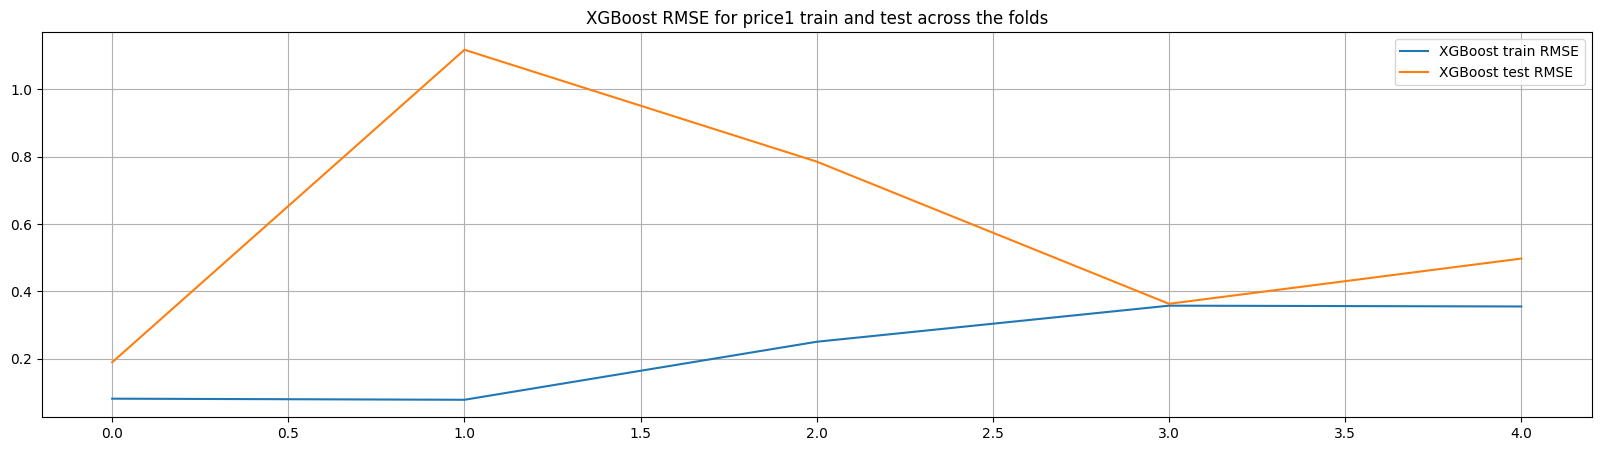

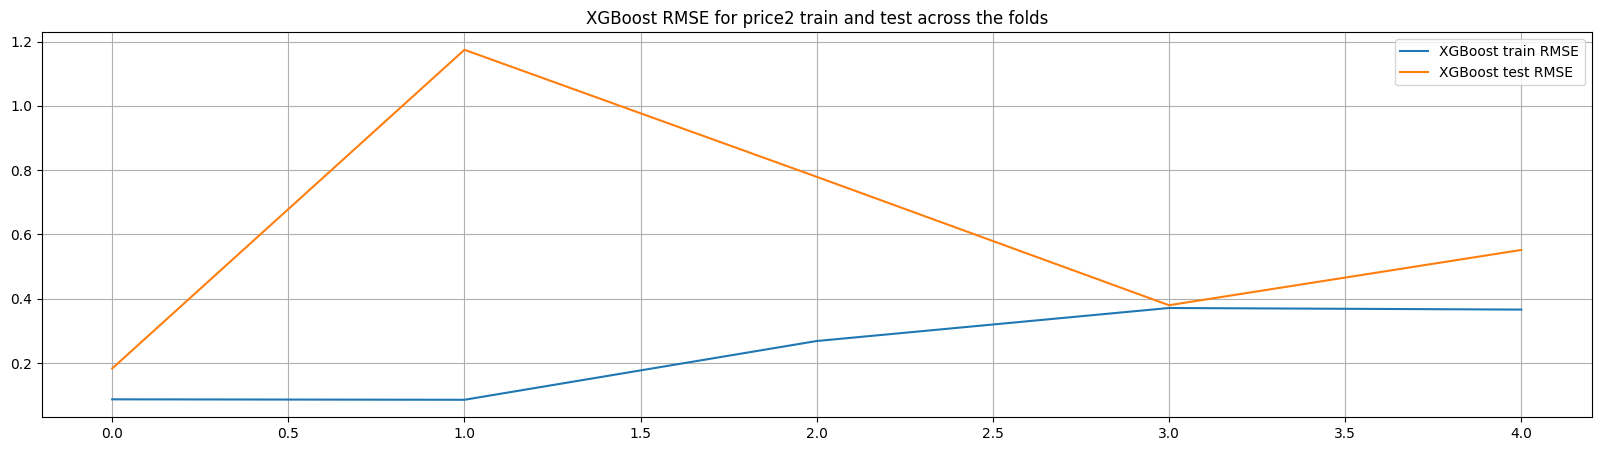

In [84]:
# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_price1['XGBoost']['RMSE_train'], label='XGBoost train RMSE')
plt.plot(evals_price1['XGBoost']['RMSE_test'], label='XGBoost test RMSE')
plt.legend(loc='best')
plt.title('XGBoost RMSE for price1 train and test across the folds')

# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_price2['XGBoost']['RMSE_train'], label='XGBoost train RMSE')
plt.plot(evals_price2['XGBoost']['RMSE_test'], label='XGBoost test RMSE')
plt.legend(loc='best')
plt.title('XGBoost RMSE for price2 train and test across the folds')

Text(0.5, 1.0, 'LinearRegression RMSE for price2 train and test across the folds')

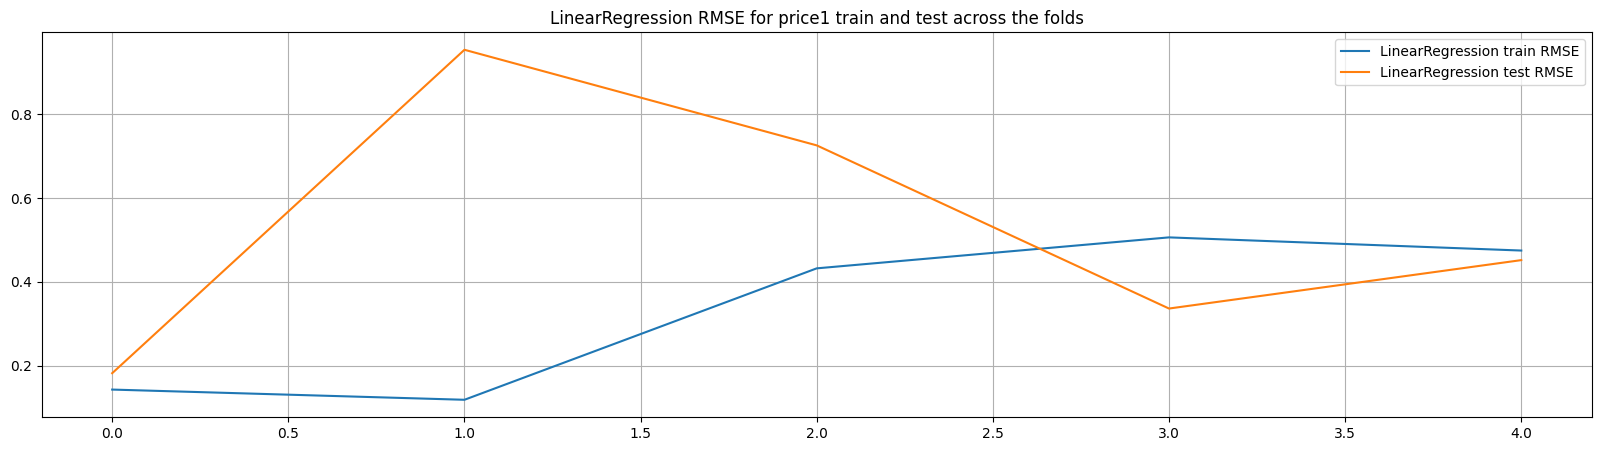

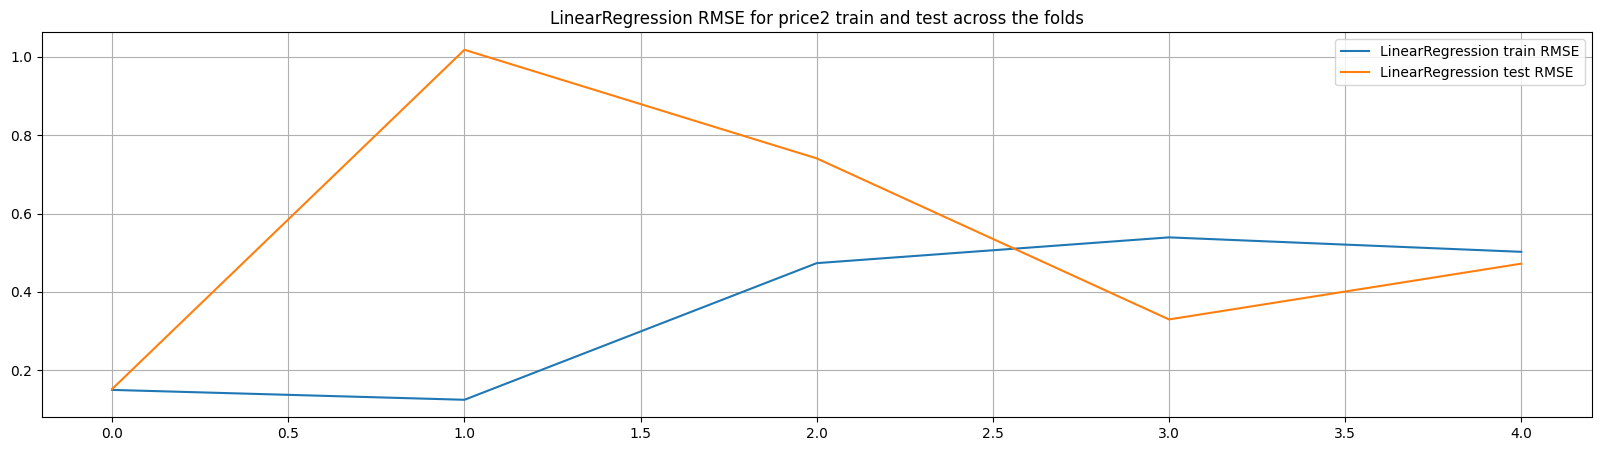

In [85]:
# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_price1['LinearRegression']['RMSE_train'], label='LinearRegression train RMSE')
plt.plot(evals_price1['LinearRegression']['RMSE_test'], label='LinearRegression test RMSE')
plt.legend(loc='best')
plt.title('LinearRegression RMSE for price1 train and test across the folds')

# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_price2['LinearRegression']['RMSE_train'], label='LinearRegression train RMSE')
plt.plot(evals_price2['LinearRegression']['RMSE_test'], label='LinearRegression test RMSE')
plt.legend(loc='best')
plt.title('LinearRegression RMSE for price2 train and test across the folds')

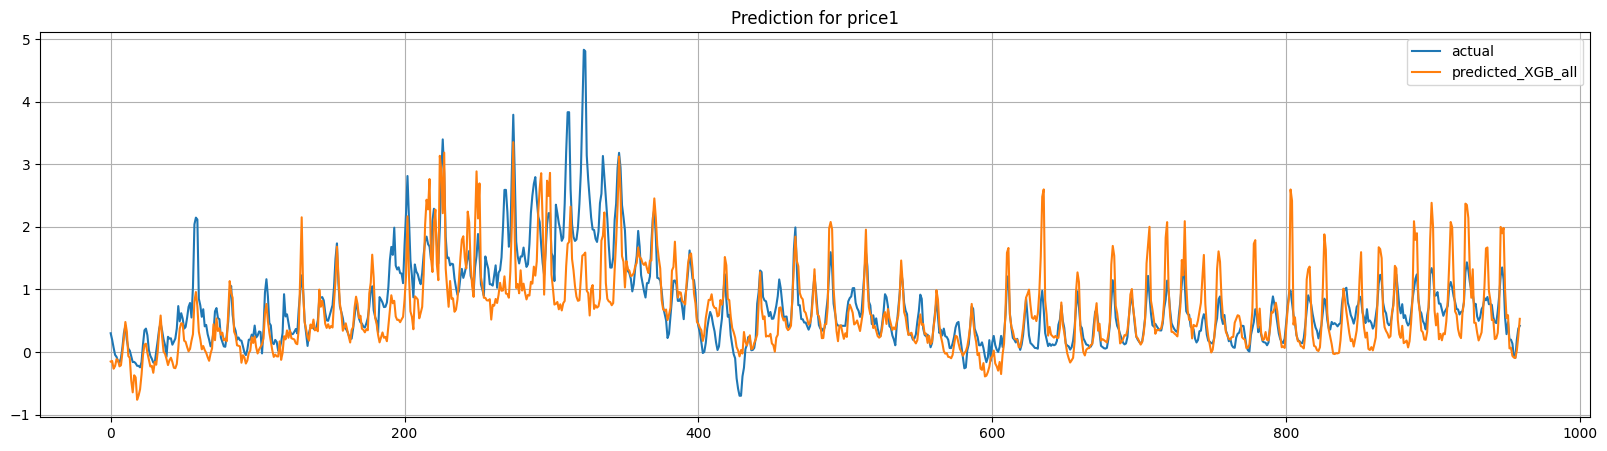

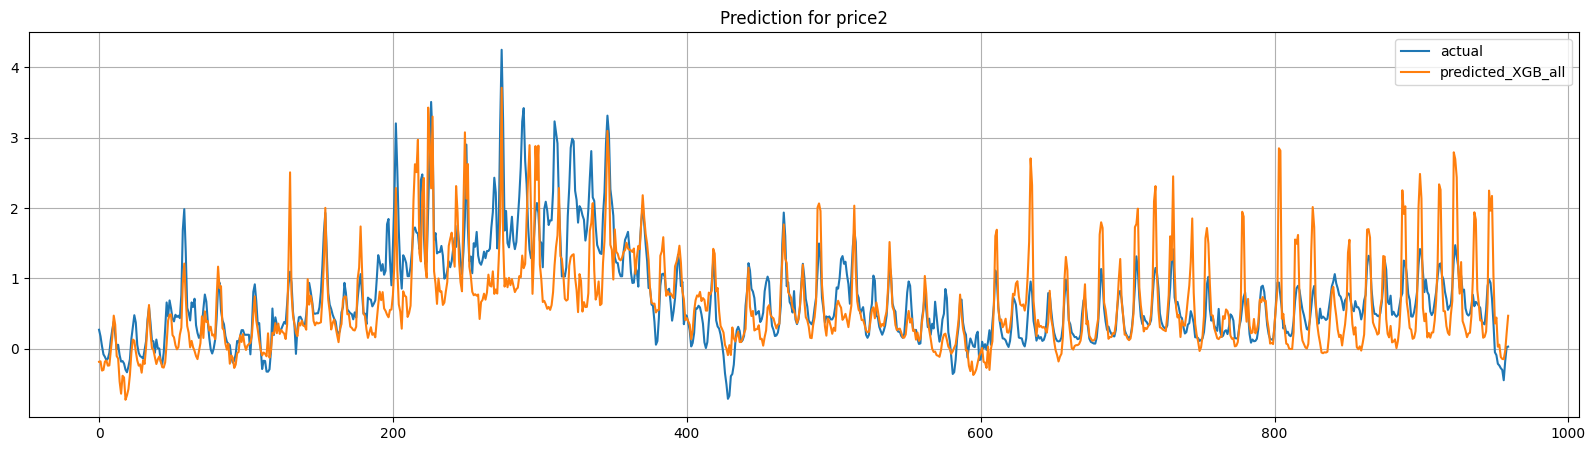

In [86]:
X_test=cv_folds[3][2]
y_test=cv_folds[3][3]
price1_pred_XGB=trained_models_price1['XGBoost'][3].predict(X_test)
price2_pred_XGB=trained_models_price2['XGBoost'][3].predict(X_test)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['price1'][0:960].values), label='actual')
plt.plot(price1_pred_XGB[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for price1')
plt.show()

plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['price2'][0:960].values), label='actual')
plt.plot(price2_pred_XGB[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for price2')
plt.show()

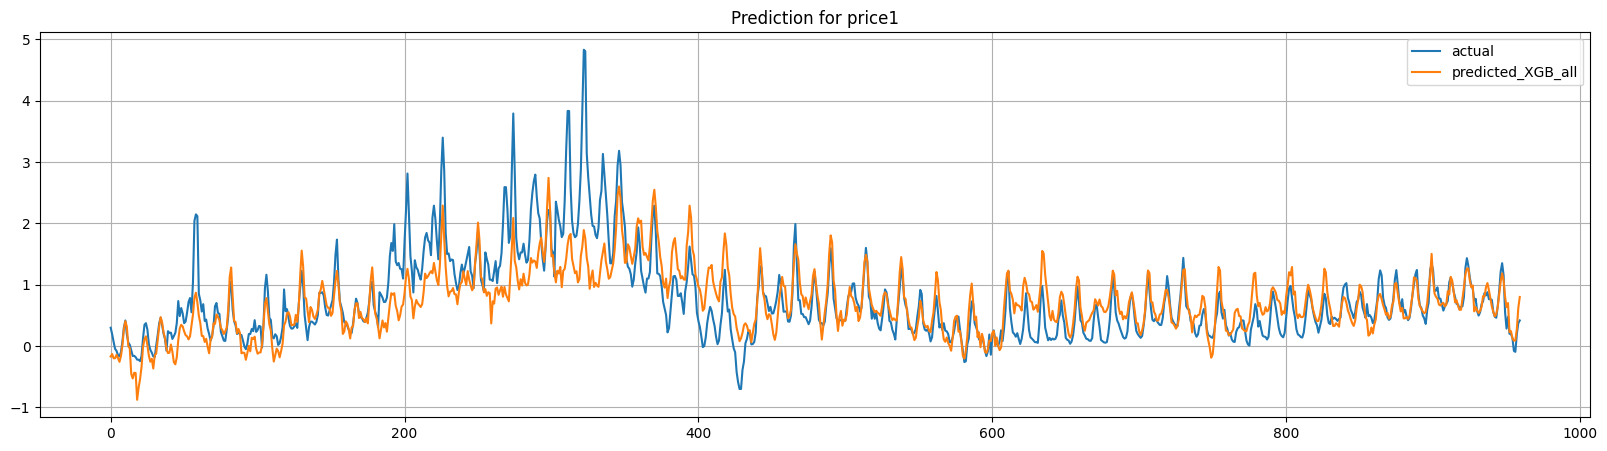

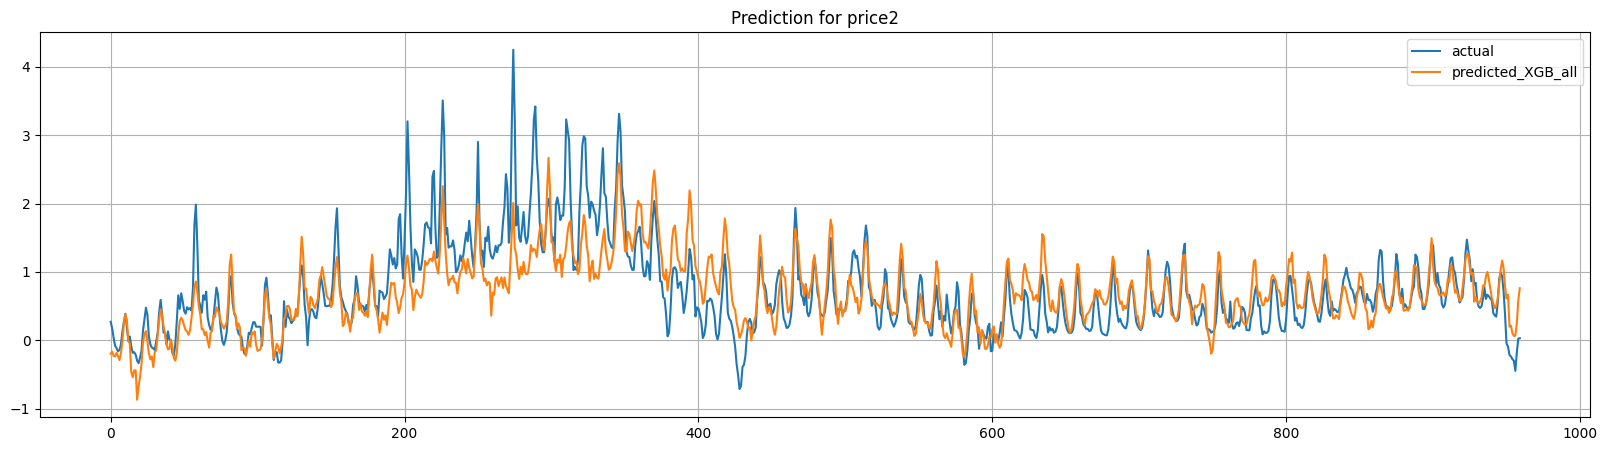

In [87]:
X_test=cv_folds[3][2]
y_test=cv_folds[3][3]
price1_pred_LR=trained_models_price1['LinearRegression'][3].predict(X_test)
price2_pred_LR=trained_models_price2['LinearRegression'][3].predict(X_test)
plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['price1'][0:960].values), label='actual')
plt.plot(price1_pred_LR[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for price1')
plt.show()

plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['price2'][0:960].values), label='actual')
plt.plot(price2_pred_LR[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for price2')
plt.show()

In [88]:
coeffs

mean         std
col                               
price1      157.848524  112.804623
price2      157.359473  114.770582
price3      151.901235  145.256654
log_price1    5.481051    0.362057
log_price2    5.478114    0.364371
log_price3    5.436039    0.414497
spread1      -0.489051   23.870942
spread2      -5.947289  120.629952

In [89]:
def unstandardize_data(data, feature_names, standardise_coeffs):
    for col in feature_names:
        data.loc[:, col] = data.loc[:, col] * standardise_coeffs.loc[col, 'std'] + standardise_coeffs.loc[col, 'mean']
    return data

def map_log_price_to_price(data, feature_names, standardise_coeffs):
    data_orig = unstandardize_data(data, feature_names, standardise_coeffs)
    for col in feature_names:
        data_orig[col] = np.exp(data_orig[col]) - 100
    return data

In [90]:
auction_spread_data=auction_data['price_second_auction']-auction_data['price_first_auction']
spread_target=auction_spread_data[cv_folds_all[3][3].index]
spread_target

date
2022-02-23 08:00:00    -3.42
2022-02-23 09:00:00    -2.40
2022-02-23 10:00:00    -4.11
2022-02-23 11:00:00    -4.70
2022-02-23 12:00:00    -5.11
                       ...  
2022-06-03 23:00:00   -10.20
2022-06-04 00:00:00    -4.73
2022-06-04 01:00:00    -4.34
2022-06-04 02:00:00     0.85
2022-06-04 03:00:00     4.11
Freq: h, Length: 2420, dtype: float64

In [91]:
second_price_prediction = unstandardize_data(
    pd.DataFrame(price2_pred_LR, columns=['price2'], index=spread_target.index),
    ['price2'],
    coeffs
)
first_price_prediction = unstandardize_data(
    pd.DataFrame(price1_pred_LR, columns=['price1'], index=spread_target.index),
    ['price1'],
    coeffs
)
spread_prediction = second_price_prediction['price2'] - first_price_prediction['price1']


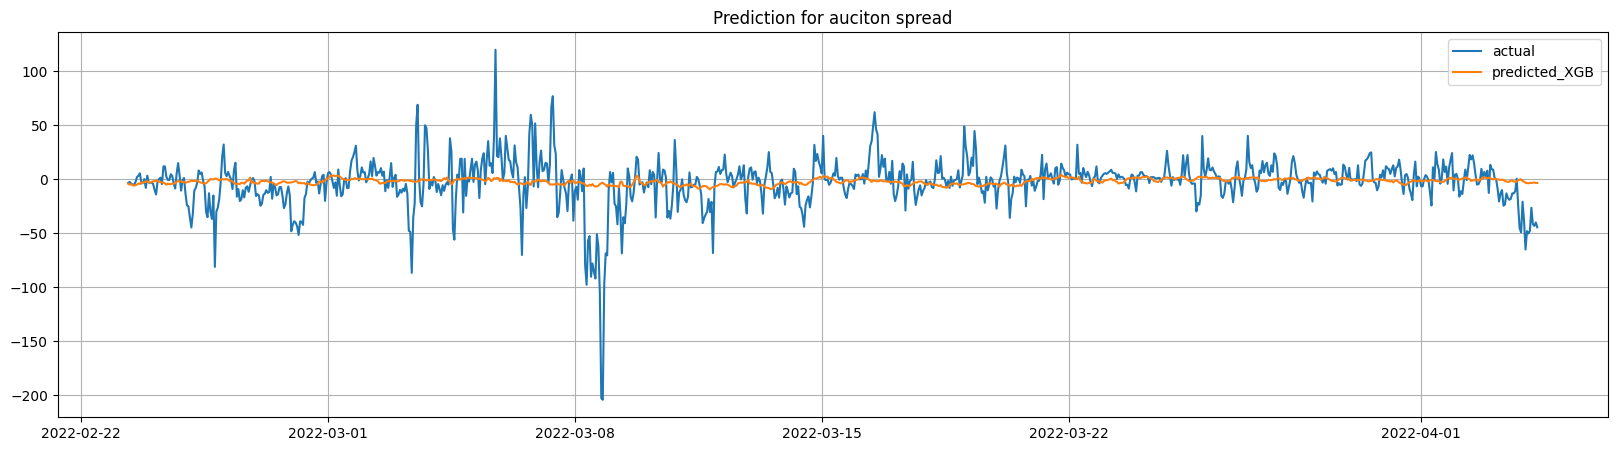

In [92]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(spread_target[0:960], label='actual')
plt.plot(spread_prediction[0:960], label='predicted_XGB')
plt.legend(loc='best')
plt.title('Prediction for auciton spread')
plt.show()

ALSO NOT ABLE TO LEARN SPREADS VIA PRICES EVEN WITH ALL FEATURES AND REGULAIRSAATION TO AVOID OVERFITTING

try agina to learn spread directly with all features and regularisation to avoid overfitting

In [93]:
trained_models_spread1_all, evals_spread1_all=compare_models(model_config, cv_folds_all, 'spread1')

Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:
Model: LinearRegression
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:


Text(0.5, 1.0, 'XGBoost RMSE for spread1 train and test across the folds')

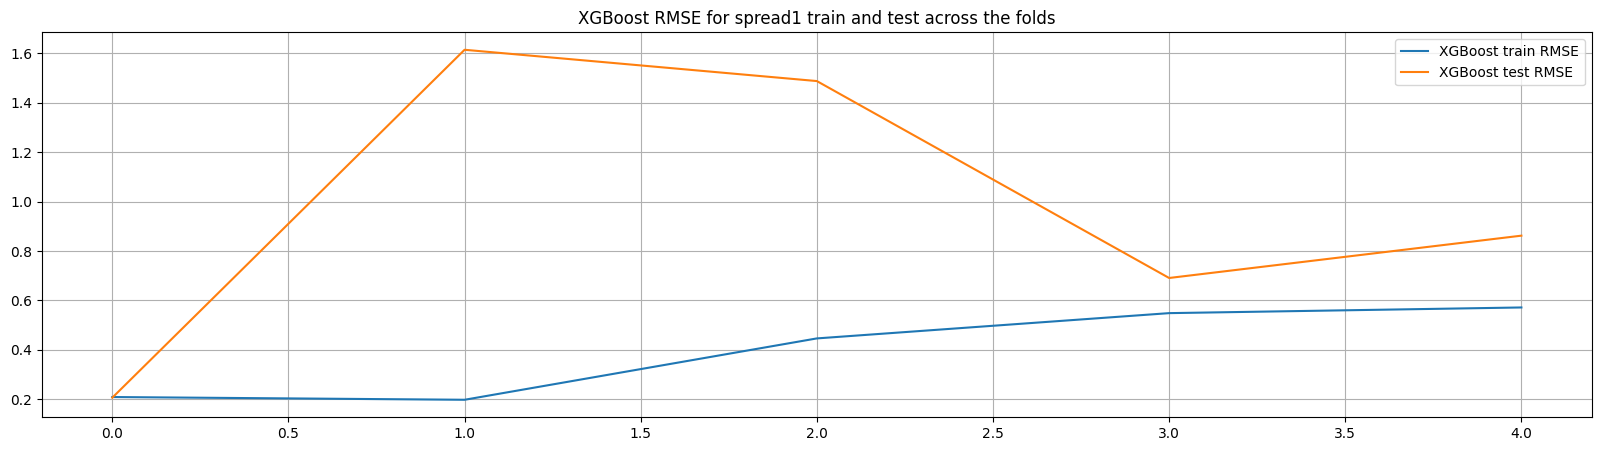

In [94]:
# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_spread1_all['XGBoost']['RMSE_train'], label='XGBoost train RMSE')
plt.plot(evals_spread1_all['XGBoost']['RMSE_test'], label='XGBoost test RMSE')
plt.legend(loc='best')
plt.title('XGBoost RMSE for spread1 train and test across the folds')

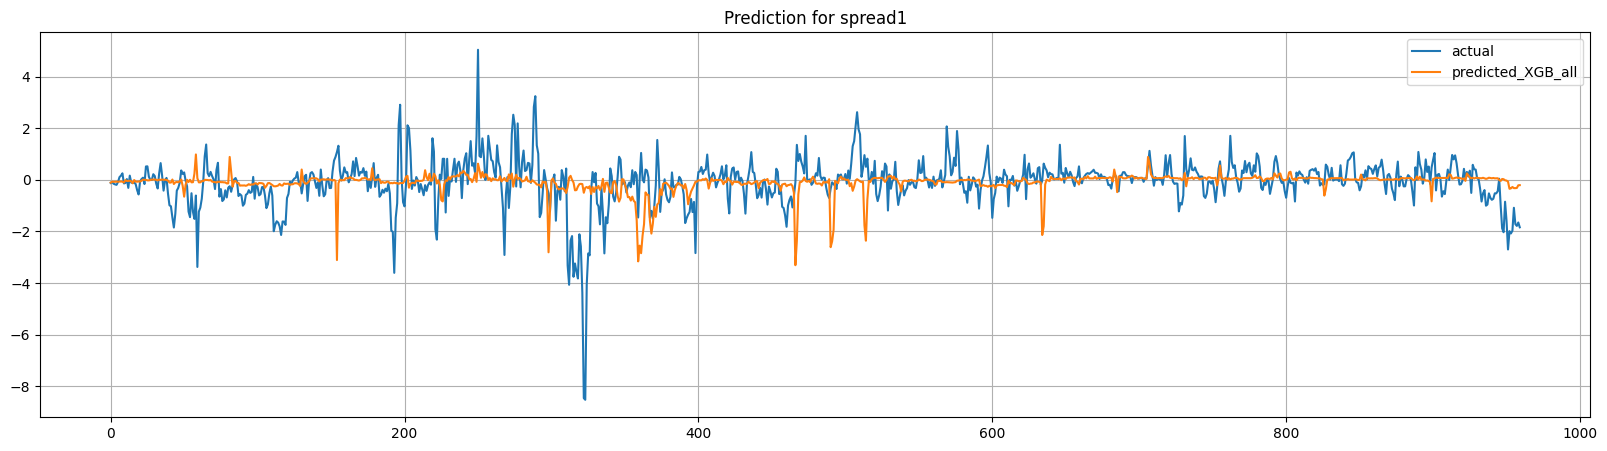

In [95]:
X_test=cv_folds_all[3][2]
y_test=cv_folds_all[3][3]

spread1_pred_XGB_all=trained_models_spread1_all['XGBoost'][3].predict(X_test)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['spread1'][0:960].values), label='actual')
plt.plot(spread1_pred_XGB_all[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for spread1')
plt.show()

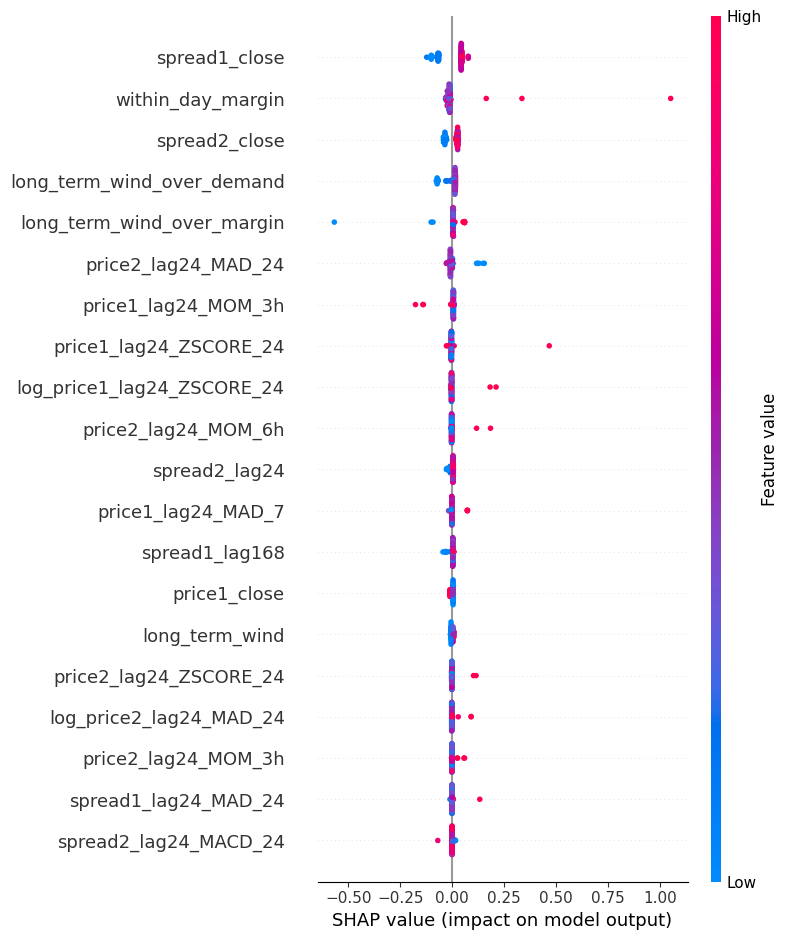

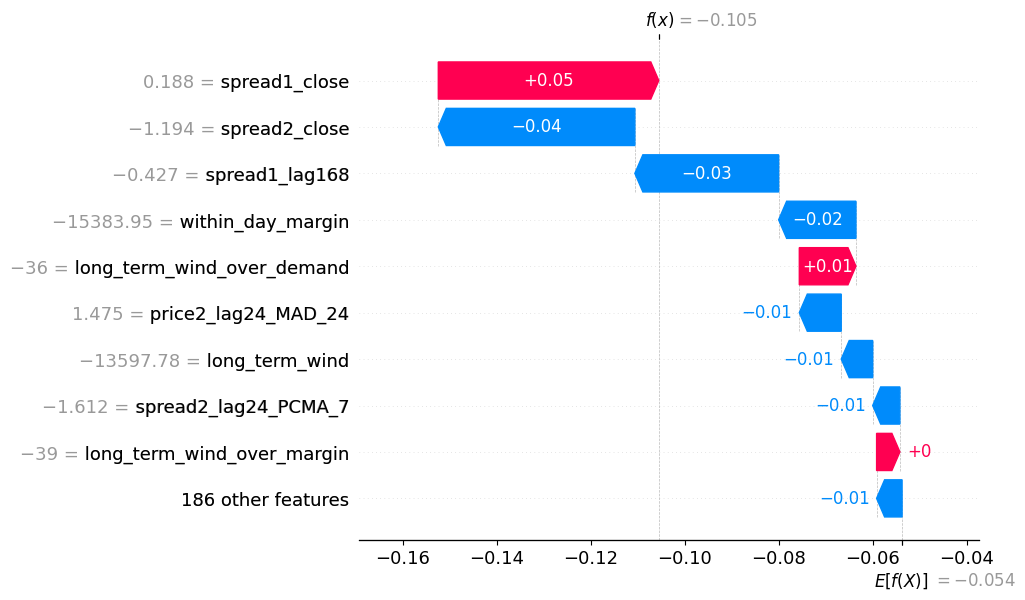

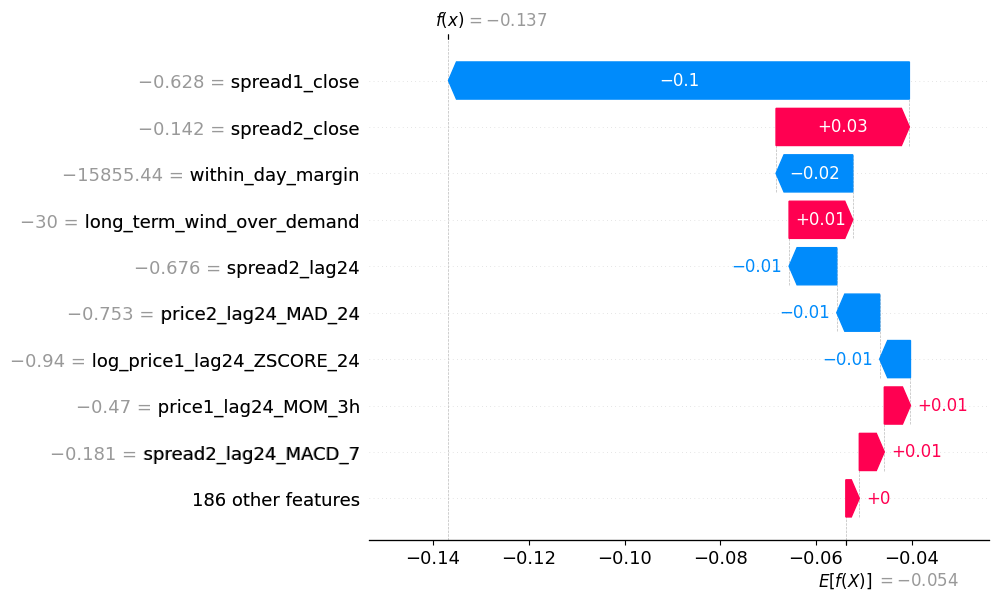

In [97]:
import shap

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(trained_models_spread1_all['XGBoost'][3], X_test[0:100])
shap_values = explainer(X_test[0:100])

# Visualize
shap.summary_plot(shap_values, X_test[0:100])  # global impact
shap.plots.waterfall(shap_values[0])        # individual prediction
shap.plots.waterfall(shap_values[-1])      # individual prediction


In [98]:
study = optuna.create_study(direction='minimize')
objective = lambda x : make_XGB_objective(target='log_price1', cv_folds=cv_folds_all, trial=x)
study.optimize(objective, n_trials=50)
print(study.best_params)

[I 2025-05-21 11:18:00,247] A new study created in memory with name: no-name-ee657960-f0ba-4b79-a65a-b8b50b1be814
[I 2025-05-21 11:18:15,760] Trial 0 finished with value: 0.19111728691693972 and parameters: {'max_depth': 6, 'learning_rate': 0.02745575618190184, 'subsample': 0.6478580672275807, 'colsample_bytree': 0.7606044439717211, 'n_estimators': 406}. Best is trial 0 with value: 0.19111728691693972.
[I 2025-05-21 11:18:22,122] Trial 1 finished with value: 0.17714777580578883 and parameters: {'max_depth': 4, 'learning_rate': 0.028284770179591103, 'subsample': 0.9196092321213353, 'colsample_bytree': 0.5431018522567193, 'n_estimators': 444}. Best is trial 1 with value: 0.17714777580578883.
[I 2025-05-21 11:18:38,301] Trial 2 finished with value: 0.1784467841948688 and parameters: {'max_depth': 7, 'learning_rate': 0.019669606370578362, 'subsample': 0.8402110942537353, 'colsample_bytree': 0.5337158057387721, 'n_estimators': 320}. Best is trial 1 with value: 0.17714777580578883.
[I 2025-0

{'max_depth': 3, 'learning_rate': 0.07274128872177585, 'subsample': 0.5652493143159698, 'colsample_bytree': 0.6958782522842898, 'n_estimators': 215}


the price in the two day ahead markets are very strongly correlated

In [99]:
# correlation of price in day ahead auctions
auction_data['price_first_auction'].corr(auction_data['price_second_auction'])

np.float64(0.9781427322621407)

Therefore we can confidently open a position (short or long) in the second auction almost surely knowing the price we will recieve based on the first auctions price on the same day! (plus any other price information from all auctions in the previous day). We can aim to make a profitable trade simply by predicting the system price in relation to the second auction price, we then open a short position if the system is long (prices are depressed in the blaancing markeyt) or a long position if the system is short (prices are elevated in the balancing market).

In [100]:
cv_folds_pa1=timeseries_train_test_split(X_pa1_pca, y_post_auction1, 5)

Fold 0:
  Train: index=[   0    1    2 ... 2418 2419 2420]
  Test:  index=[2421 2422 2423 ... 4838 4839 4840]
Fold 1:
  Train: index=[   0    1    2 ... 4838 4839 4840]
  Test:  index=[4841 4842 4843 ... 7258 7259 7260]
Fold 2:
  Train: index=[   0    1    2 ... 7258 7259 7260]
  Test:  index=[7261 7262 7263 ... 9678 9679 9680]
Fold 3:
  Train: index=[   0    1    2 ... 9678 9679 9680]
  Test:  index=[ 9681  9682  9683 ... 12098 12099 12100]
Fold 4:
  Train: index=[    0     1     2 ... 12098 12099 12100]
  Test:  index=[12101 12102 12103 ... 14518 14519 14520]


In [ ]:
{'max_depth': 3, 'learning_rate': 0.07274128872177585, 'subsample': 0.5652493143159698, 'colsample_bytree': 0.6958782522842898, 'n_estimators': 215}

In [101]:
model_config=[('XGBoost', {'max_depth': 3, 
                           'learning_rate': 0.06672302343658705, 
                           'subsample': 0.5572324324534429, 
                           'colsample_bytree': 0.6738662526816873, 
                           'n_estimators': 445})]

In [105]:
model_config=[('XGBoost', {'max_depth': 3, 'learning_rate': 0.07274128872177585, 'subsample': 0.5652493143159698, 'colsample_bytree': 0.6958782522842898, 'n_estimators': 215})]

In [106]:
trained_models_spread1_pa1, evals_spread1_pa1=compare_models(model_config, cv_folds_pa1, 'spread1')

Model: XGBoost
Validating Fold 1 of 5:
Validating Fold 2 of 5:
Validating Fold 3 of 5:
Validating Fold 4 of 5:
Validating Fold 5 of 5:


Text(0.5, 1.0, 'XGBoost RMSE for spread1 train and test across the folds')

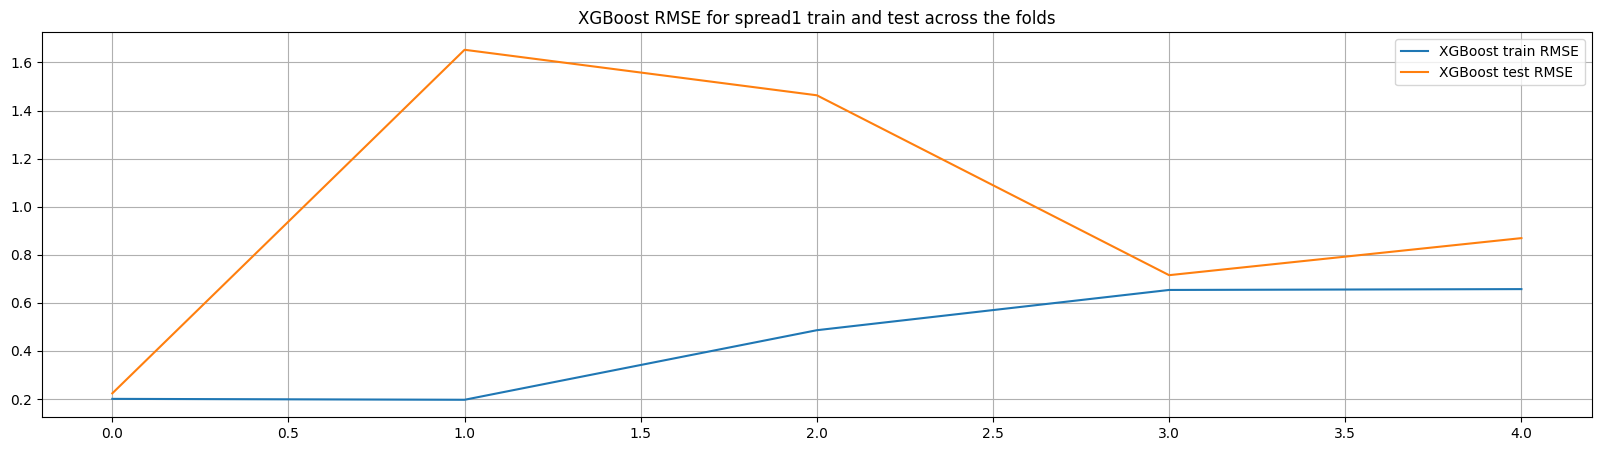

In [107]:
# plot the XGBoost RMSE for test and train accros the fold
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(evals_spread1_pa1['XGBoost']['RMSE_train'], label='XGBoost train RMSE')
plt.plot(evals_spread1_pa1['XGBoost']['RMSE_test'], label='XGBoost test RMSE')
plt.legend(loc='best')
plt.title('XGBoost RMSE for spread1 train and test across the folds')

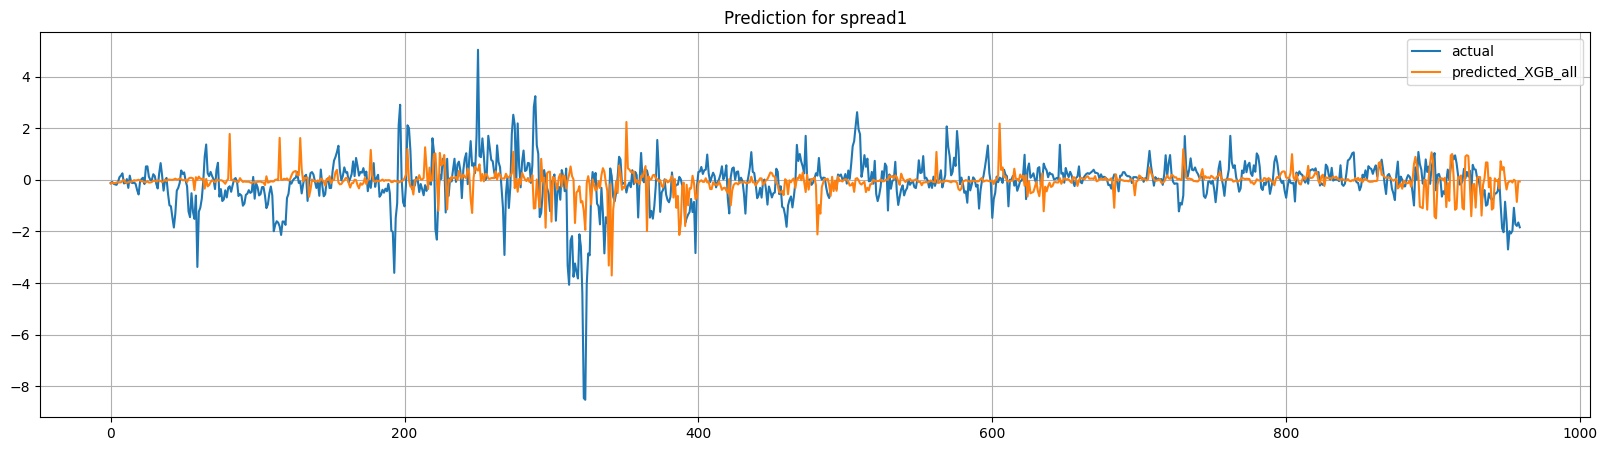

In [108]:
X_test=cv_folds_pa1[3][2]
y_test=cv_folds_pa1[3][3]

spread1_pred_XGB_pa1=trained_models_spread1_pa1['XGBoost'][3].predict(X_test)

plt.figure(figsize=(20,5))
plt.grid()
plt.plot((y_test['spread1'][0:960].values), label='actual')
plt.plot(spread1_pred_XGB_pa1[0:960], label='predicted_XGB_all')
plt.legend(loc='best')
plt.title('Prediction for spread1')
plt.show()

In [113]:
y_test_sign=y_test['spread1']/y_test['spread1'].abs()
y_pred_sign=spread1_pred_XGB_pa1/np.abs(spread1_pred_XGB_pa1)

print(y_test_sign.value_counts())
print((y_test_sign==y_pred_sign).sum()/y_test_sign.shape[0])

spread1
-1.0    1229
 1.0    1191
Name: count, dtype: int64
0.49297520661157024


Does worse than random on a balanced dataset. AKA the mdoel completely fails to predict the sign of the spread.

## Spread Direction Classifier

We build a classifier which predicts the spread direction between the auctions

In [114]:
signals_data=auction_data.copy()
signals_data['auction_spread_dir']=(signals_data['auction_price_spread']>0).astype(int)
signals_data['system_spread_dir']=(signals_data['system_price_spread']>0).astype(int)

In [115]:
signals_data.columns

Index(['price_first_auction', 'price_second_auction',
       'traded_volume_first_auction', 'traded_volume_second_auction',
       'system_price', 'auction_price_spread', 'system_price_spread',
       'auction_spread_dir', 'system_spread_dir'],
      dtype='object')

Generate indicators

In [116]:
signals=signals_data.columns

signals_data=generate_lag_timeseries(signals_data, signals, 24)
signals_data=generate_lag_timeseries(signals_data, signals, 72)
signals_data=generate_lag_timeseries(signals_data, signals, 24*7)
signals_data=generate_close_timeseries(signals_data, signals)

indicator_methods=[
                   ('ATR_24', 'calculate_ATR', {'window': 24, 'lag': 24}),
                   ('ATR_7', 'calculate_ATR', {'window': 24, 'lag': 7*24}),
                   ('MAD_24', 'calculate_MAD', {'window': 24}),
                   ('MAD_7', 'calculate_MAD', {'window': 7*24}),
                   ('RSTDEV_24', 'calculate_RSTDEV', {'window': 24}),
                   ('RSTDEV_7', 'calculate_RSTDEV', {'window': 7*24}),
                   ('ZSCORE_24', 'calculate_ZSCORE', {'window': 24}),
                   ('ZSCORE_7', 'calculate_ZSCORE', {'window': 7*24}),
                   ('ADX_24', 'calculate_ADX', {'window': 24}),
                   ('ADX_7', 'calculate_ADX', {'window': 7*24}),
                   ('PR_24', 'calculate_PR', {'window': 24}),
                   ('PR_7', 'calculate_PR', {'window': 7*24}),
                   ('RSI_24', 'calculate_RSI', {'window': 24}),
                   ('RSI_7', 'calculate_RSI', {'window': 7*24}),
                   ('MACD_24', 'calculate_MACD', {'window_smaller': 12, 'window_larger': 24}),
                   ('MACD_7', 'calculate_MACD', {'window_smaller': 7*12, 'window_larger': 7*24}),
                   ('MOM_1h', 'calculate_MOM', {'lag':1}),
                   ('MOM_3h', 'calculate_MOM', {'lag':3}),
                   ('MOM_6h', 'calculate_MOM', {'lag':6}),
                      
]           

timeseries=['auction_price_spread_lag24', 'system_price_spread_lag24', 'price_first_auction_lag24', 
            'price_second_auction_lag24',
       'traded_volume_first_auction_lag24', 'traded_volume_second_auction_lag24',
       'system_price_lag24']
signals_data=make_new_price_indicators(signals_data, 
                                       timeseries, 
                                       indicator_methods)

signals_data=pd.concat([signals_data, forecasts], axis=1)

signals_data=signals_data.dropna(axis=0, how='any')

Some indicators are partial predicators e.g. the system_price_spread at previous days close and may help with the model

Text(0.5, 1.0, 'Distribution of system price spread at previous day close for positve or nagative spread that day')

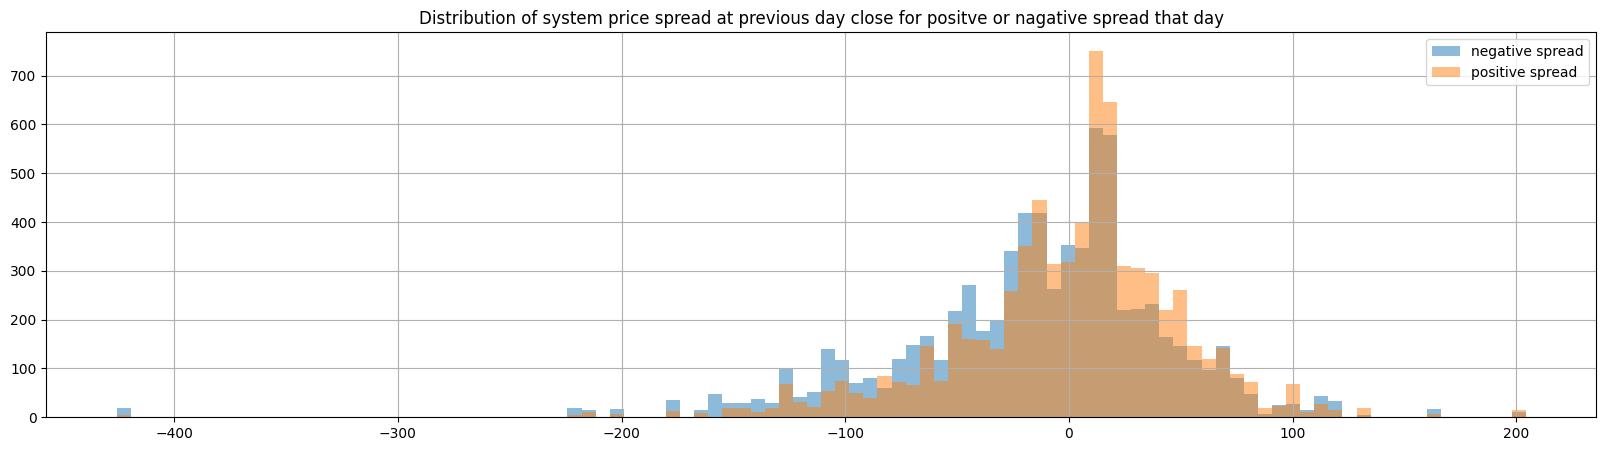

In [134]:
# plot the distribution of inbdicator from the lagged signal for next day positive or negative spread
# to see if the lagged signal is a good predictor of the target
plt.figure(figsize=(20,5))
plt.grid()
plt.hist(signals_data[signals_data['system_spread_dir']==0]['system_price_spread_close'], bins=100, alpha=0.5, label='negative spread')
plt.hist(signals_data[signals_data['system_spread_dir']==1]['system_price_spread_close'], bins=100, alpha=0.5, label='positive spread')
plt.legend(loc='best')
plt.title('Distribution of system price spread at previous day close for positve or nagative spread that day')


In [185]:
X=signals_data.drop(columns=['auction_spread_dir', 'system_spread_dir', 'price_second_auction', 'system_price', 'traded_volume_second_auction', 'auction_price_spread','system_price_spread'])

In [186]:
# scale data with a standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

### System price spread

In [ ]:
y=signals_data[['system_spread_dir']]


In [120]:
cv_folds=timeseries_train_test_split(X_scaled, y, 5)

Fold 0:
  Train: index=[   0    1    2 ... 2418 2419 2420]
  Test:  index=[2421 2422 2423 ... 4838 4839 4840]
Fold 1:
  Train: index=[   0    1    2 ... 4838 4839 4840]
  Test:  index=[4841 4842 4843 ... 7258 7259 7260]
Fold 2:
  Train: index=[   0    1    2 ... 7258 7259 7260]
  Test:  index=[7261 7262 7263 ... 9678 9679 9680]
Fold 3:
  Train: index=[   0    1    2 ... 9678 9679 9680]
  Test:  index=[ 9681  9682  9683 ... 12098 12099 12100]
Fold 4:
  Train: index=[    0     1     2 ... 12098 12099 12100]
  Test:  index=[12101 12102 12103 ... 14518 14519 14520]


Accuracy: 0.5628099173553719
F1 Score: 0.3961187214611872
ROC AUC: 0.5995459820163311


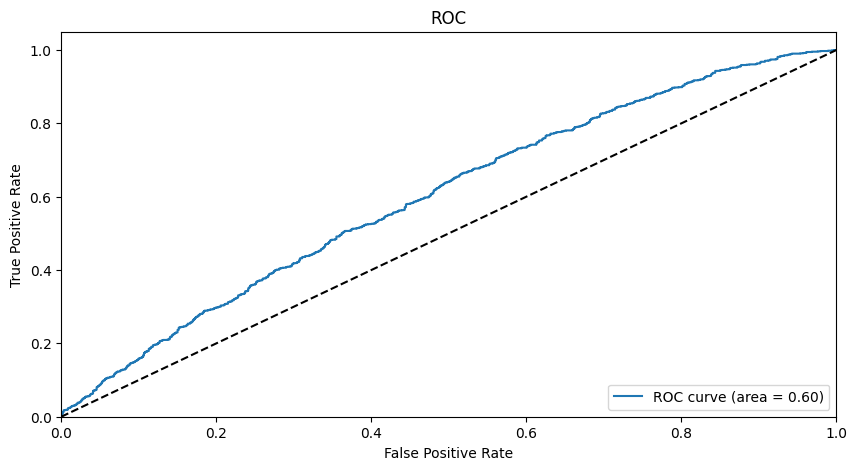

In [ ]:
# logistic regression classifier

(X_train, y_train, X_test, y_test) = cv_folds[4]
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train['system_spread_dir'])
y_pred_LR = log_reg.predict(X_test)
y_pred_proba_LR = log_reg.predict_proba(X_test)[:, 1]


print(f'Accuracy: {accuracy_score(y_test["system_spread_dir"], y_pred_LR)}')
print(f'F1 Score: {f1_score(y_test["system_spread_dir"], y_pred_LR)}')
print(f'ROC AUC: {roc_auc_score(y_test["system_spread_dir"], y_pred_proba_LR)}')

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test['system_spread_dir'], y_pred_proba_LR)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.5537190082644629
F1 Score: 0.25517241379310346
ROC AUC: 0.6044227637589888


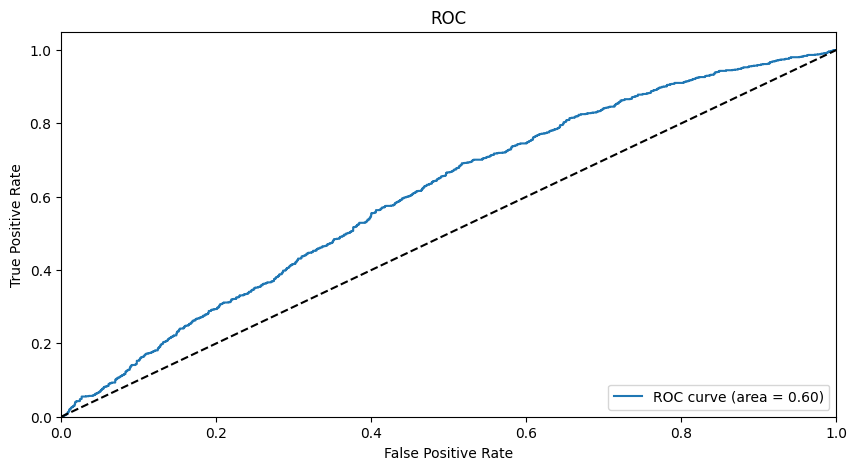

In [ ]:
# XGB classifier
model_config={'learning_rate' :0.005,
                            'n_estimators':2000,   # increase since learning is slower
                            'max_depth': 3, 
                            'min_child_weight': 3, 
                            'gamma': 0.1, 
                            'subsample': 0.7, 
                            'colsample_bytree': 0.7, 
                            'reg_alpha': 0.5, 
                            'reg_lambda': 2}
xgb_clf = XGBClassifier(**model_config)
xgb_clf.fit(X_train, y_train['system_spread_dir'])
y_pred_XGB = xgb_clf.predict(X_test)
y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]
print(f'Accuracy: {accuracy_score(y_test["system_spread_dir"], y_pred_XGB)}')
print(f'F1 Score: {f1_score(y_test["system_spread_dir"], y_pred_XGB)}')
print(f'ROC AUC: {roc_auc_score(y_test["system_spread_dir"], y_pred_proba_XGB)}')

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test['system_spread_dir'], y_pred_proba_XGB)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

Take average ensemble of the two models

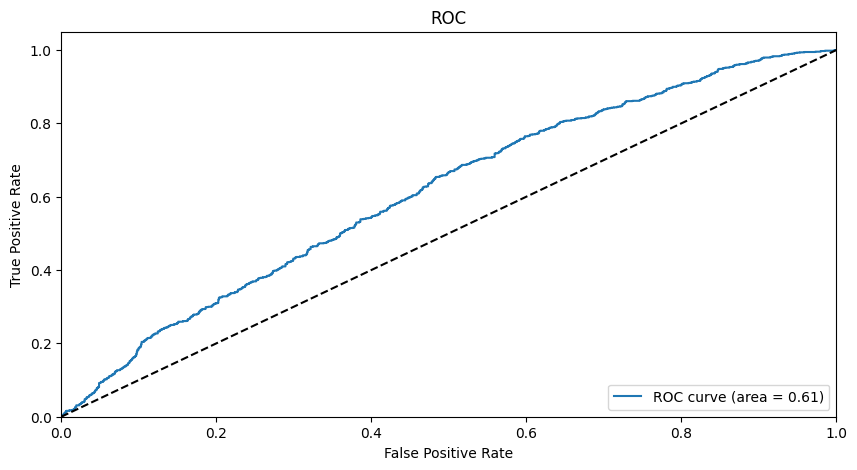

In [123]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test['system_spread_dir'], (y_pred_proba_LR + y_pred_proba_XGB)/2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [124]:
# Logistic Regression
train_pred_LR = log_reg.predict(X_train)
train_pred_proba_LR = log_reg.predict_proba(X_train)[:, 1]

print("Logistic Regression:")
print(f"Train Accuracy: {accuracy_score(y_train['system_spread_dir'], train_pred_LR)}")
print(f"Test Accuracy: {accuracy_score(y_test['system_spread_dir'], y_pred_LR)}")
print(f"Train ROC AUC: {roc_auc_score(y_train['system_spread_dir'], train_pred_proba_LR)}")
print(f"Test ROC AUC: {roc_auc_score(y_test['system_spread_dir'], y_pred_proba_LR)}")

Logistic Regression:
Train Accuracy: 0.6116849847120073
Test Accuracy: 0.5628099173553719
Train ROC AUC: 0.65638308101378
Test ROC AUC: 0.5995459820163311


In [125]:
# XGBoost
train_pred_XGB = xgb_clf.predict(X_train)
train_pred_proba_XGB = xgb_clf.predict_proba(X_train)[:, 1]

print("XGBoost:")
print(f"Train Accuracy: {accuracy_score(y_train['system_spread_dir'], train_pred_XGB)}")
print(f"Test Accuracy: {accuracy_score(y_test['system_spread_dir'], y_pred_XGB)}")
print(f"Train ROC AUC: {roc_auc_score(y_train['system_spread_dir'], train_pred_proba_XGB)}")
print(f"Test ROC AUC: {roc_auc_score(y_test['system_spread_dir'], y_pred_proba_XGB)}")

XGBoost:
Train Accuracy: 0.7237418395173952
Test Accuracy: 0.5537190082644629
Train ROC AUC: 0.7960012663780984
Test ROC AUC: 0.6044227637589888


In [126]:
# Get feature importance from Logistic Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': log_reg.coef_[0]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                                 Feature  Importance
152            system_price_lag24_ATR_24    1.178954
58       system_price_spread_lag24_ATR_7    0.997812
177                      long_term_solar    0.957761
76      price_first_auction_lag24_ATR_24    0.811804
100  price_second_auction_lag24_RSTDEV_7    0.672334
..                                   ...         ...
175                    within_day_margin   -0.551785
82   price_first_auction_lag24_ZSCORE_24   -0.553541
86       price_first_auction_lag24_PR_24   -0.562031
153             system_price_lag24_ATR_7   -0.918062
57      system_price_spread_lag24_ATR_24   -1.195375

[187 rows x 2 columns]

                                Feature  Importance
31            system_price_spread_close       368.0
28   traded_volume_second_auction_close       304.0
167             within_day_availability       250.0
30           auction_price_spread_close       250.0
166                              demand       226.0
..                                  ...         ...
68     system_price_spread_lag24_MOM_1h        16.0
71     price_first_auction_lag24_ATR_24        15.0
9               system_spread_dir_lag24         8.0
32             auction_spread_dir_close         2.0
24             system_spread_dir_lag168         1.0

[181 rows x 2 columns]


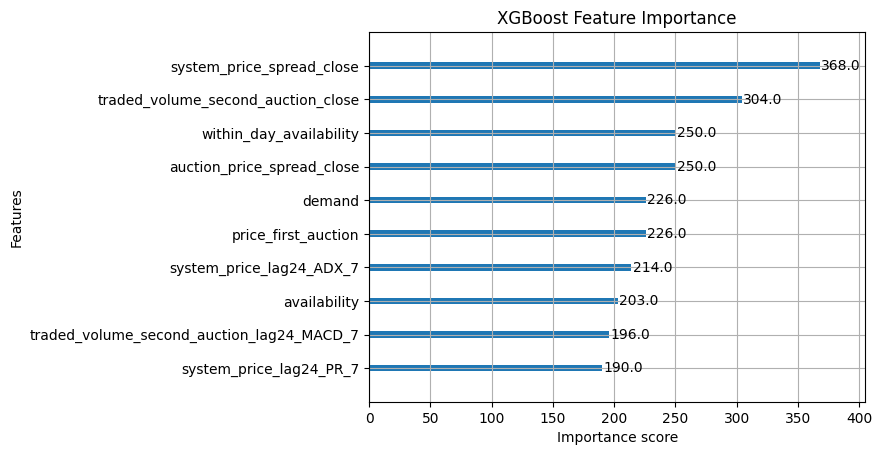

In [127]:
# Get feature importance from XGBoost
xgb_importance = xgb_clf.get_booster().get_score(importance_type='weight')
xgb_importance_df = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Importance': list(xgb_importance.values())
}).sort_values(by='Importance', ascending=False)

print(xgb_importance_df)

# Plot feature importance
import xgboost as xgb
xgb.plot_importance(xgb_clf, importance_type='weight', max_num_features=10, title='XGBoost Feature Importance')
plt.show()

### Auction Spread

In [128]:
y2=signals_data[['auction_spread_dir']]

In [129]:
cv_folds2=timeseries_train_test_split(X_scaled, y2, 5)

Fold 0:
  Train: index=[   0    1    2 ... 2418 2419 2420]
  Test:  index=[2421 2422 2423 ... 4838 4839 4840]
Fold 1:
  Train: index=[   0    1    2 ... 4838 4839 4840]
  Test:  index=[4841 4842 4843 ... 7258 7259 7260]
Fold 2:
  Train: index=[   0    1    2 ... 7258 7259 7260]
  Test:  index=[7261 7262 7263 ... 9678 9679 9680]
Fold 3:
  Train: index=[   0    1    2 ... 9678 9679 9680]
  Test:  index=[ 9681  9682  9683 ... 12098 12099 12100]
Fold 4:
  Train: index=[    0     1     2 ... 12098 12099 12100]
  Test:  index=[12101 12102 12103 ... 14518 14519 14520]


#### Logistic Regression

Train basic model on folds to see improvements as more data is incorporated and gauge under/overfitting

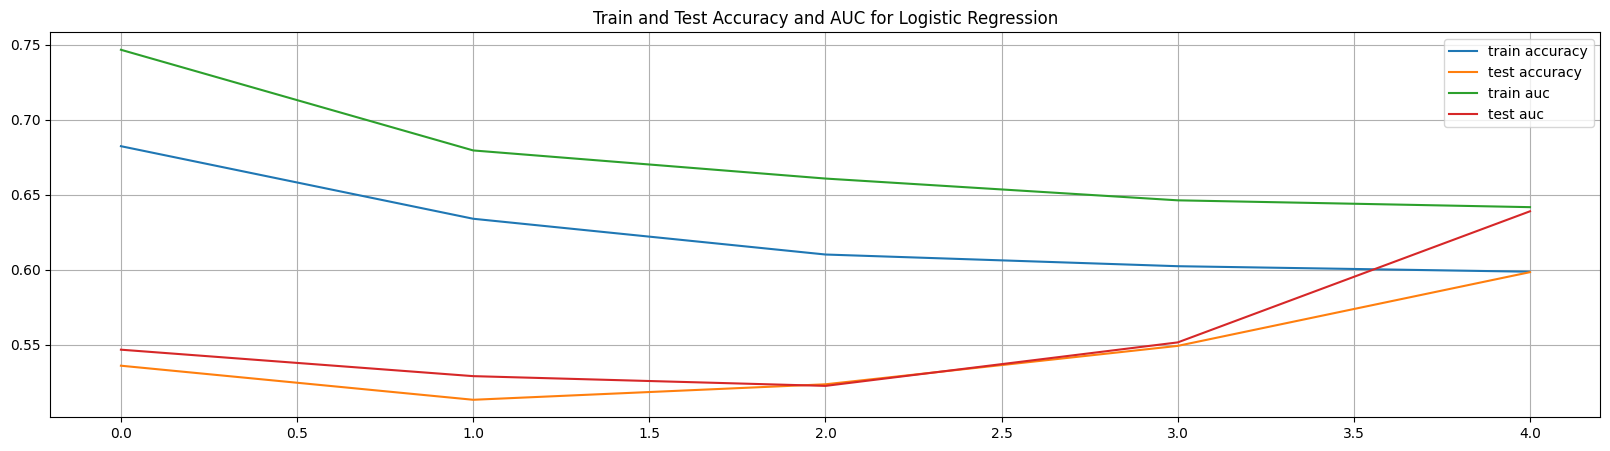

In [171]:
train_accuracies=[]
test_accuracies=[]
train_auc=[]
test_auc=[]
for i,fold in cv_folds2.items():
    (X_train, y_train, X_test, y_test) = fold
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train['auction_spread_dir'])
    y_pred_LR = log_reg.predict(X_test)
    y_pred_proba_LR = log_reg.predict_proba(X_test)[:, 1]
    train_pred_LR = log_reg.predict(X_train)
    train_pred_proba_LR = log_reg.predict_proba(X_train)[:, 1]
    
    train_accuracies.append(accuracy_score(y_train['auction_spread_dir'], train_pred_LR))
    test_accuracies.append(accuracy_score(y_test['auction_spread_dir'], y_pred_LR))
    train_auc.append(roc_auc_score(y_train['auction_spread_dir'], train_pred_proba_LR))
    test_auc.append(roc_auc_score(y_test['auction_spread_dir'], y_pred_proba_LR))

# plot accuracy and F1scores
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.plot(train_auc, label='train auc')
plt.plot(test_auc, label='test auc')
plt.legend(loc='best')
plt.title('Train and Test Accuracy and AUC for Logistic Regression')
plt.show()


The model is fitting nicely! Training accuracy decreases as the training dataset is made larger (mopdel is noit memoriesing the larger datasets). But test accuracy increases. So the model is able to generalise better given more data.

For the final fold the model accuracies and area under the ROC curve are the same on the test dataset and the train dataset.

We focus then on final fold.

ROC AUC: 0.6389470787329128


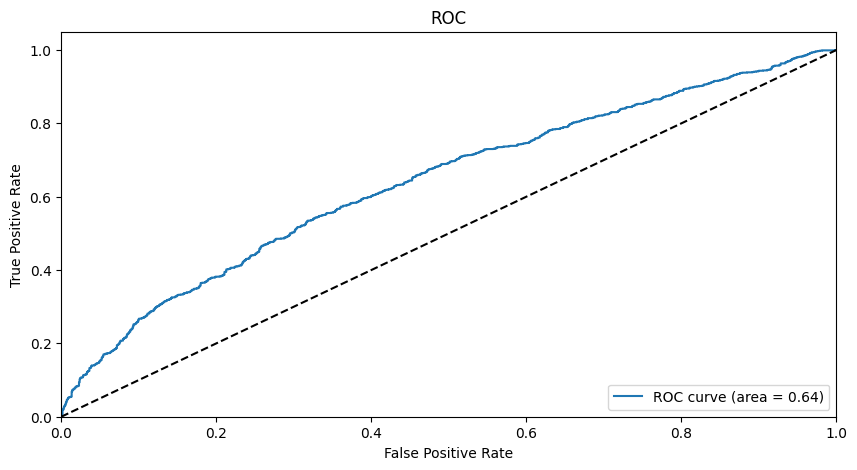

Best threshold: 0.4270548652210299
Threshold = 0.4270548652210299. Accuracy: 0.6115702479338843
Threshold = 0.4270548652210299. F1 Score: 0.5668202764976958


In [ ]:
# logistic regression classifier
(X_train, y_train, X_test, y_test) = cv_folds2[4]
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train['auction_spread_dir'])
y_pred_proba_LR = log_reg.predict_proba(X_test)[:, 1]


print(f'ROC AUC: {roc_auc_score(y_test["auction_spread_dir"], y_pred_proba_LR)}')

# plot the ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(y_test['auction_spread_dir'], y_pred_proba_LR)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

# use the Youden's J statistic to pick the threshold

j_scores = tpr - fpr
best_thresh_LR = thresholds[j_scores.argmax()]
print(f'Best threshold: {best_thresh_LR}')
y_pred_LR = (y_pred_proba_LR > best_thresh_LR).astype(int)
print(f'Threshold = {best_thresh_LR}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_LR)}')
print(f'Threshold = {best_thresh_LR}. F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_LR)}')

We have used the Youden's J statistic to pick the best threshold. This is the threshold that maximises the difference between the true positive rate and the false positive rate.

In [311]:
# Get feature importance from Logistic Regression
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': log_reg.coef_[0]
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                                Feature  Importance
39     auction_price_spread_lag24_ATR_7    0.670923
180         long_term_solar_over_demand    0.566224
76     price_first_auction_lag24_ATR_24    0.462360
176                      long_term_wind    0.450948
175                   within_day_margin    0.358474
..                                  ...         ...
81   price_first_auction_lag24_RSTDEV_7   -0.381311
96     price_second_auction_lag24_ATR_7   -0.417883
77      price_first_auction_lag24_ATR_7   -0.424761
177                     long_term_solar   -0.465994
38    auction_price_spread_lag24_ATR_24   -0.801081

[187 rows x 2 columns]


#### XGBoost Classifier

We try an XGboost classifier. First we test for overfitting with default params.

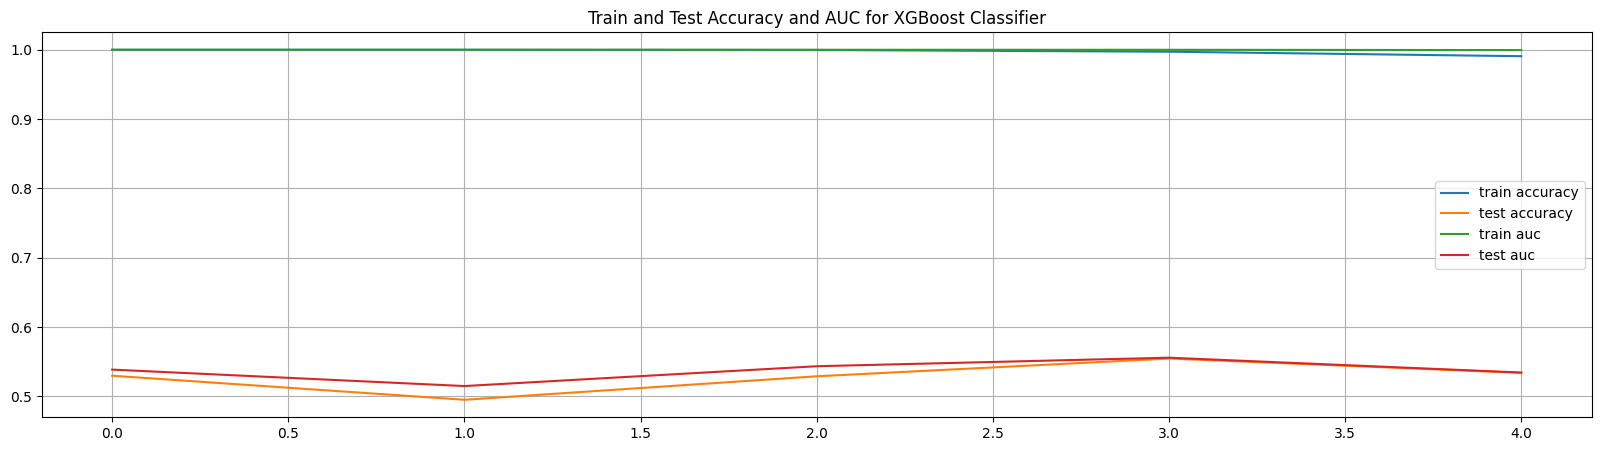

In [173]:
train_accuracies=[]
test_accuracies=[]
train_auc=[]
test_auc=[]
for i,fold in cv_folds2.items():
    (X_train, y_train, X_test, y_test) = fold
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train['auction_spread_dir'])
    y_pred_XGB = xgb_clf.predict(X_test)
    y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]
    train_pred_XGB = xgb_clf.predict(X_train)
    train_pred_proba_XGB = xgb_clf.predict_proba(X_train)[:, 1]
    
    train_accuracies.append(accuracy_score(y_train['auction_spread_dir'], train_pred_XGB))
    test_accuracies.append(accuracy_score(y_test['auction_spread_dir'], y_pred_XGB))
    train_auc.append(roc_auc_score(y_train['auction_spread_dir'], train_pred_proba_XGB))
    test_auc.append(roc_auc_score(y_test['auction_spread_dir'], y_pred_proba_XGB))

# plot accuracy and F1scores
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.plot(train_auc, label='train auc')
plt.plot(test_auc, label='test auc')
plt.legend(loc='best')
plt.title('Train and Test Accuracy and AUC for XGBoost Classifier')
plt.show()

Model needs regulairsing as currently it is heavily overfitting. Memorising training data and not generalising that well. We choose hyperparams to discourage overfitting.


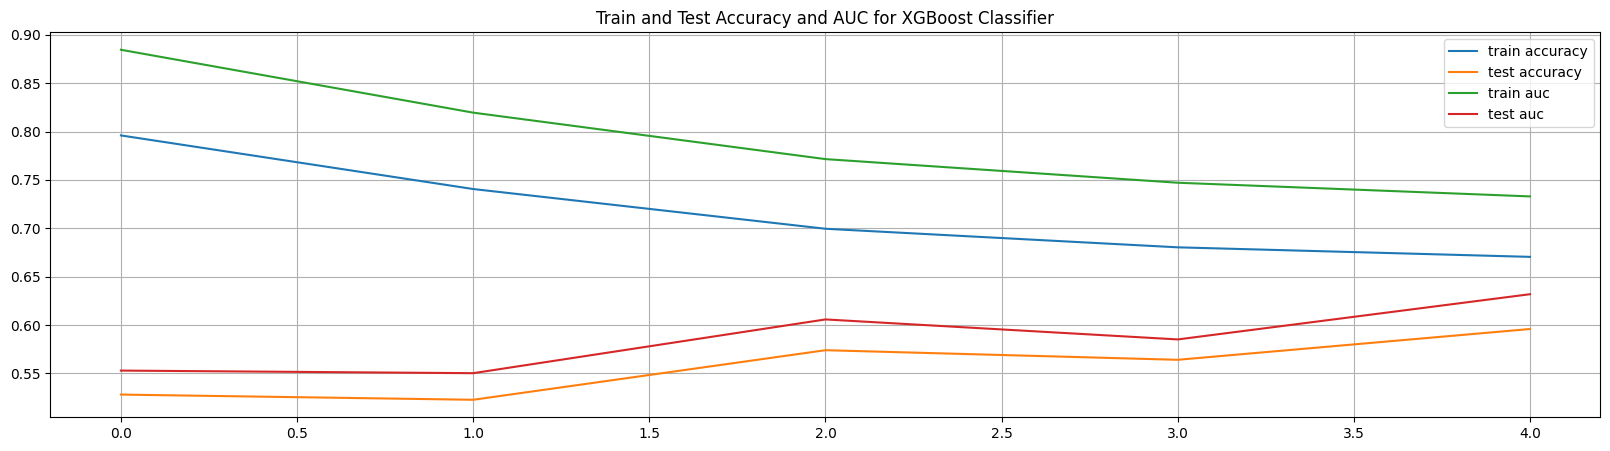

In [175]:
train_accuracies=[]
test_accuracies=[]
train_auc=[]
test_auc=[]
for i,fold in cv_folds2.items():
    (X_train, y_train, X_test, y_test) = fold
    # config to regularise model and avoid overfitting
    model_config={'learning_rate' :0.005,  # slower learning rate
                            'n_estimators':3000,   # increase since learning is slower
                            'max_depth': 2, # simple trees
                            'min_child_weight': 2, 
                            'gamma': 0.1, 
                            'subsample': 0.5, # randomly sample 50% of the data to regularise fitting
                            'colsample_bytree': 0.5, # randomly sample 50% of the data to regularise fitting
                            'reg_alpha': 0.5, # regularise param
                            'reg_lambda': 5} # regularise param
    xgb_clf = XGBClassifier(**model_config)
    xgb_clf.fit(X_train, y_train['auction_spread_dir'])
    y_pred_XGB = xgb_clf.predict(X_test)
    y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]
    train_pred_XGB = xgb_clf.predict(X_train)
    train_pred_proba_XGB = xgb_clf.predict_proba(X_train)[:, 1]
    
    train_accuracies.append(accuracy_score(y_train['auction_spread_dir'], train_pred_XGB))
    test_accuracies.append(accuracy_score(y_test['auction_spread_dir'], y_pred_XGB))
    train_auc.append(roc_auc_score(y_train['auction_spread_dir'], train_pred_proba_XGB))
    test_auc.append(roc_auc_score(y_test['auction_spread_dir'], y_pred_proba_XGB))

# plot accuracy and F1scores
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.plot(train_auc, label='train auc')
plt.plot(test_auc, label='test auc')
plt.legend(loc='best')
plt.title('Train and Test Accuracy and AUC for XGBoost Classifier')
plt.show()

That is better! The model is no longer overfitting. Perhaps these parameters can be improved tho! We use optuna to tune these hyper parameters to maximise performance on the test data. We maximise the AUC i.e. area under the ROC curve.

In [ ]:
# use optuna to fin best params for XGBoost classifier
def objective(target, cv_folds, trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 2),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "eval_metric": "logloss"
    }
    
    (X_train, y_train, X_test, y_test) = cv_folds
    model = XGBClassifier(**params)
    model.fit(X_train, y_train[target].values.ravel())
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test[target], y_pred)
    return auc

study = optuna.create_study(direction="maximize")
new_objective = lambda trial: objective(target='auction_spread_dir', cv_folds=cv_folds2[4], trial=trial)
study.optimize(new_objective, n_trials=50)
print("Best trial:", study.best_trial.params)


In [165]:
study.best_trial.params

{'learning_rate': 0.01177211003559059,
 'n_estimators': 1273,
 'max_depth': 2,
 'min_child_weight': 1,
 'gamma': 0.06803976355812102,
 'subsample': 0.5741777398848672,
 'colsample_bytree': 0.6725324255878418,
 'reg_alpha': 0.5437368326823249,
 'reg_lambda': 1.8092604183104135}

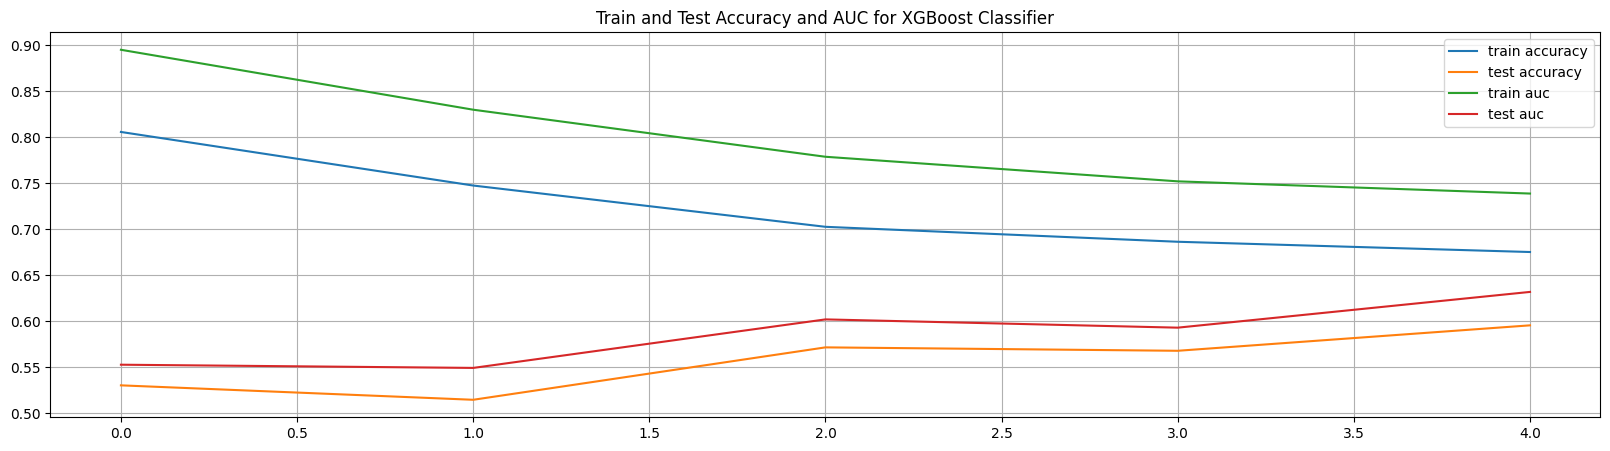

In [176]:
train_accuracies=[]
test_accuracies=[]
train_auc=[]
test_auc=[]
for i,fold in cv_folds2.items():
    (X_train, y_train, X_test, y_test) = fold
    model_config=study.best_trial.params
    xgb_clf = XGBClassifier(**model_config)
    xgb_clf.fit(X_train, y_train['auction_spread_dir'])
    y_pred_XGB = xgb_clf.predict(X_test)
    y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]
    train_pred_XGB = xgb_clf.predict(X_train)
    train_pred_proba_XGB = xgb_clf.predict_proba(X_train)[:, 1]
    
    train_accuracies.append(accuracy_score(y_train['auction_spread_dir'], train_pred_XGB))
    test_accuracies.append(accuracy_score(y_test['auction_spread_dir'], y_pred_XGB))
    train_auc.append(roc_auc_score(y_train['auction_spread_dir'], train_pred_proba_XGB))
    test_auc.append(roc_auc_score(y_test['auction_spread_dir'], y_pred_proba_XGB))

# plot accuracy and F1scores
plt.figure(figsize=(20, 5))
plt.grid()
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.plot(train_auc, label='train auc')
plt.plot(test_auc, label='test auc')
plt.legend(loc='best')
plt.title('Train and Test Accuracy and AUC for XGBoost Classifier')
plt.show()

Default Accuracy: 0.5954545454545455
Default F1 Score: 0.49562081401339514
ROC AUC: 0.6318232726515947


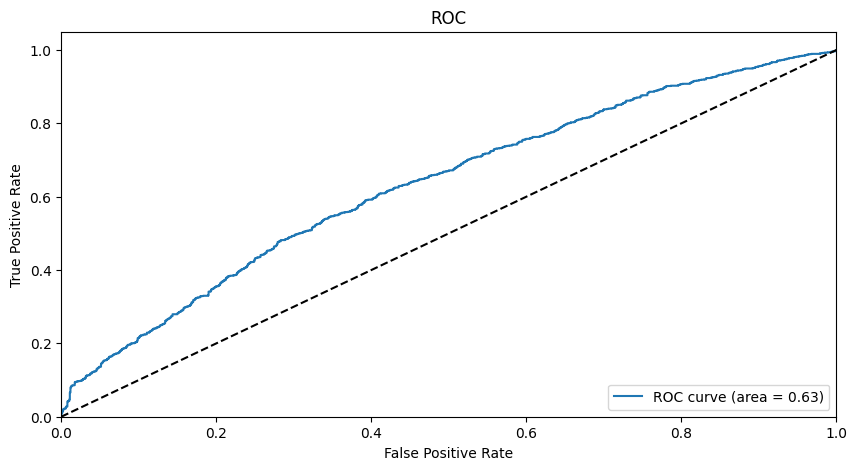

In [166]:
# XGB classifier
from xgboost import XGBClassifier

model_config=study.best_trial.params
xgb_clf = XGBClassifier(**model_config)
xgb_clf.fit(X_train, y_train['auction_spread_dir'])
y_pred_XGB = xgb_clf.predict(X_test)
y_pred_proba_XGB = xgb_clf.predict_proba(X_test)[:, 1]
print(f'Default Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_XGB)}')
print(f'Default F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_XGB)}')
print(f'ROC AUC: {roc_auc_score(y_test["auction_spread_dir"], y_pred_proba_XGB)}')

# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test['auction_spread_dir'], y_pred_proba_XGB)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [177]:
j_scores = tpr - fpr
best_thresh_XGB = thresholds[j_scores.argmax()]
print(f'Best threshold: {best_thresh_XGB}')
y_pred_XGB = (y_pred_proba_XGB > best_thresh_XGB).astype(int)
print(f'Threshold = {best_thresh_XGB}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_XGB)}')
print(f'Threshold = {best_thresh_XGB}. F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_XGB)}')

Best threshold: 0.4270548652210299
Threshold = 0.4270548652210299. Accuracy: 0.5900826446280992
Threshold = 0.4270548652210299. F1 Score: 0.5996771589991929


We have used the Youden's J statistic to pick the best threshold. This is the threshold that maximises the difference between the true positive rate and the false positive rate.

                                      Feature  Importance
31                 auction_price_spread_close       199.0
29         traded_volume_second_auction_close        99.0
23                auction_price_spread_lag168        84.0
170                         within_day_margin        84.0
89           price_first_auction_lag24_MOM_3h        81.0
..                                        ...         ...
25                  auction_spread_dir_lag168         1.0
69           system_price_spread_lag24_MOM_1h         1.0
138  traded_volume_second_auction_lag24_PR_24         1.0
79         price_first_auction_lag24_ZSCORE_7         1.0
17                    system_spread_dir_lag72         1.0

[182 rows x 2 columns]


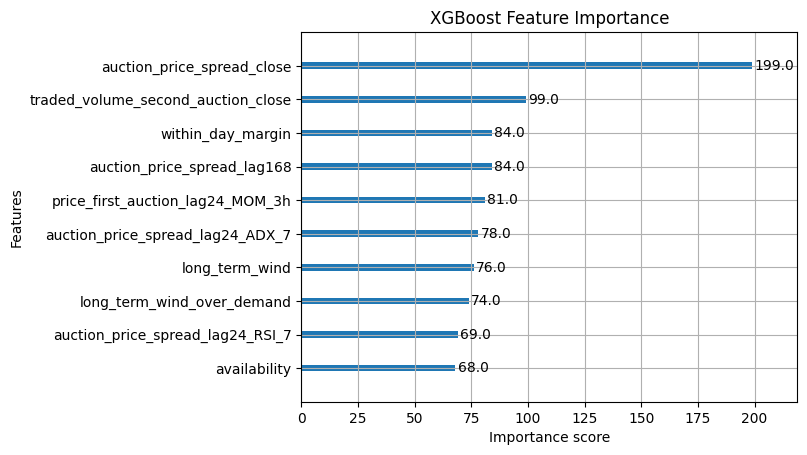

In [312]:
# Get feature importance from XGBoost
xgb_importance = xgb_clf.get_booster().get_score(importance_type='weight')
xgb_importance_df = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Importance': list(xgb_importance.values())
}).sort_values(by='Importance', ascending=False)

print(xgb_importance_df)

# Plot feature importance
import xgboost as xgb
xgb.plot_importance(xgb_clf, importance_type='weight', max_num_features=10, title='XGBoost Feature Importance')
plt.show()

#### Average Ensemble

Note the datasets are balanced

In [265]:
print(f"Overall class balance: {signals_data['auction_spread_dir'].value_counts(normalize=True)}")
print(f"Train class balance: {y_train['auction_spread_dir'].value_counts(normalize=True)}")
print(f"Test class balance: {y_test['auction_spread_dir'].value_counts(normalize=True)}")

Overall class balance: auction_spread_dir
0    0.510709
1    0.489291
Name: proportion, dtype: float64
Train class balance: auction_spread_dir
0    0.508057
1    0.491943
Name: proportion, dtype: float64
Test class balance: auction_spread_dir
0    0.523967
1    0.476033
Name: proportion, dtype: float64


We try an ensemble model by taking the average probability predicted from the Logistic Regression and XGBoost Classifier models

In [240]:
y_pred_proba_ens=(y_pred_proba_LR + y_pred_proba_XGB)/2

In [272]:
print(f"mean {y_pred_proba_ens.mean()}")
print(f"median {np.median(y_pred_proba_ens)}")

mean 0.4258284721939615
median 0.42042550797283684


the mean probability is less than 0.5. Suggesting the model 'expects' negative spreads more than positive even tho the dataset is balanced. In reality the probability output is not always a reliably scaled probability and can be biased. It only serves to allocate higher probs towards one target and lower towards another. Rather the model gives its optimised target predicitons only when paired with a threshold which can be chosen independently. This threshold should be close to the mean to give the most accurate predictions on both classes (i.e. best predictions assuming that the targets themeselves are of equal importance).

So our model exhibits bias towards negative spreads but this bias can be ammeliorated with a good threshold arounf 0.42

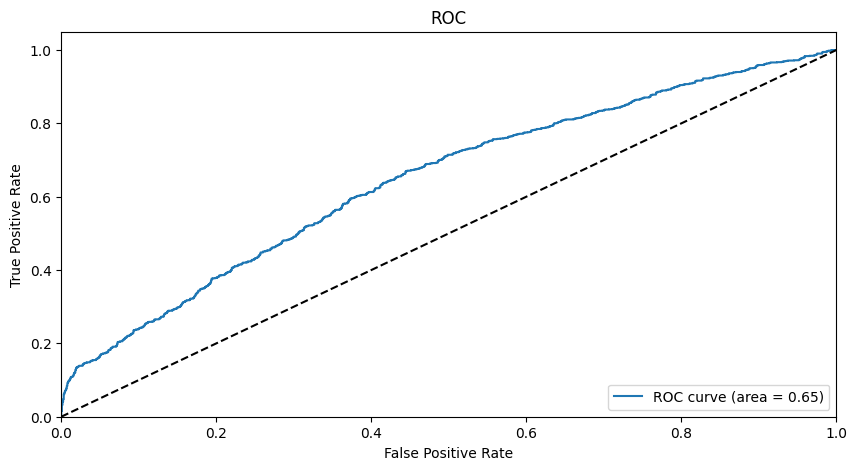

In [241]:
# plot the ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test['auction_spread_dir'], y_pred_proba_ens)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

The AUC has improved by 0.01 over just LR and 0.02 over just XGBoost. We is the optimal threshold for binary predcition?

In [242]:
j_scores = tpr - fpr
best_thresh_roc = thresholds_roc[j_scores.argmax()]
print(f'Best threshold: {best_thresh_roc}')

y_pred_ens = (y_pred_proba_ens > best_thresh_roc).astype(int)
print(f'Threshold = {best_thresh_roc}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_ens)}')
print(f'Threshold = {best_thresh_roc}. F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_ens)}')

Best threshold: 0.4038661719135693
Threshold = 0.4038661719135693. Accuracy: 0.6090909090909091
Threshold = 0.4038661719135693. F1 Score: 0.6200803212851406


We have used the Youden's J statistic to pick the best threshold. This is the threshold that maximises the difference between the true positive rate and the false positive rate.

The threshold for prediction is at 0.4 interestingly! So less than 0.5. This is expected as the mean probabilty was not 0.5. I.e. the model is biased in probability but this bias can be removed by setting the threshold for target prdicition at roughly the mean.

Lets look at precision recall (this is less relevant since the dataset is balanced, we only care about accuracy rather than precission vs recall)

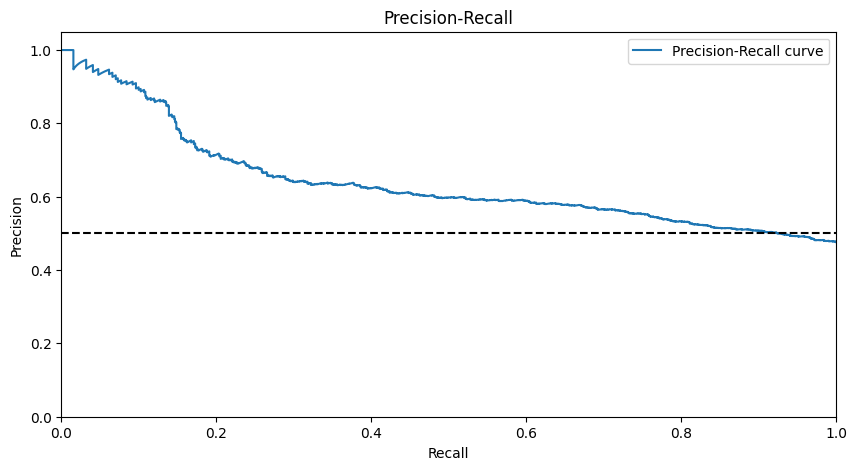

Best threshold: 0.2817934941020961


In [245]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test['auction_spread_dir'], y_pred_proba_ens)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh_pr = thresholds_pr[f1_scores.argmax()]
# plot the precision-recall curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.plot([0, 1], [0.5, 0.5], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc='best')
plt.show()
print(f'Best threshold: {best_thresh_pr}')

In [246]:
y_pred_ens_pr = (y_pred_proba_ens > best_thresh_pr).astype(int)
print(f'Threshold = {best_thresh_pr}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_ens_pr)}')
print(f'Threshold = {best_thresh_pr}. F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_ens_pr)}')

Threshold = 0.2817934941020961. Accuracy: 0.5289256198347108
Threshold = 0.2817934941020961. F1 Score: 0.6507352941176471


This maximises F1 score but reduces accuracy. SSince our dataset is balanced and we care equally about predicting positive and negative spread. We follow the reccomendation of the AUC and TPR vs FPR analysis rather than the precision, recall and F1 analysis.

We are actually intetested most in accuracy since our dataset is balanced and there is no distinction between positive and negative spread.

In [248]:
accuracies = []
thresholds_acc = np.linspace(0, 1, 200)

for thresh in thresholds_acc:
    y_pred_ens_acc = (y_pred_proba_ens >= thresh).astype(int)
    acc = accuracy_score(y_test['auction_spread_dir'], y_pred_ens_acc)
    accuracies.append(acc)

best_thresh_acc = thresholds_acc[np.argmax(accuracies)]
best_acc = accuracies[np.argmax(accuracies)]
print(f"Best threshold: {best_thresh_acc}, Best accuracy: {best_acc}")

Best threshold: 0.4271356783919598, Best accuracy: 0.6099173553719008


very close to the mean as expected

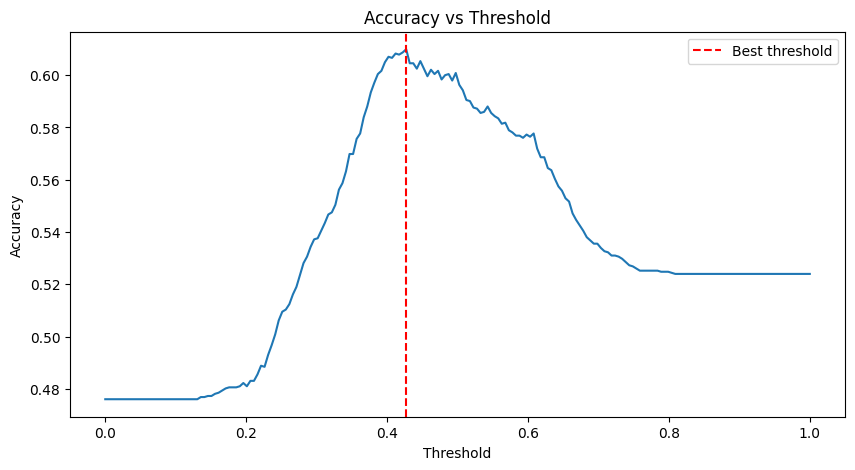

In [249]:
# plot the accuracy vs threshold
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, 200), accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.axvline(x=best_thresh_acc, color='r', linestyle='--', label='Best threshold')
plt.legend()
plt.show()

In [276]:
y_pred_ens_acc = (y_pred_proba_ens > best_thresh_acc).astype(int)
print(f'Threshold = {best_thresh_acc}. Accuracy: {accuracy_score(y_test["auction_spread_dir"], y_pred_ens_acc)}')
print(f'Threshold = {best_thresh_acc}. F1 Score: {f1_score(y_test["auction_spread_dir"], y_pred_ens_acc)}')

Threshold = 0.4271356783919598. Accuracy: 0.6099173553719008
Threshold = 0.4271356783919598. F1 Score: 0.5899218071242398


roughly same as the threshold which gives the maximum AUC! wqhich is same as mean

#### QUESTION: When does the model guess correctly?

As we ssaw, the best performing threshold on the test set leads to predictions with the same class balance as the test set

In [292]:
y_pred_ens_acc.sum()/y_pred_ens_acc.shape[0]

np.float64(0.47520661157024796)

on the entire dataset this balance may be different. The threshold should also be cross validated going forward.

We now investigate whether having predictions for class 0 and class 1 at different thresholds and having a no prediction option in between them.

On the test dataset the correctness of the predicitons is evenly distributed (both temporally and across sizes of spread) see below

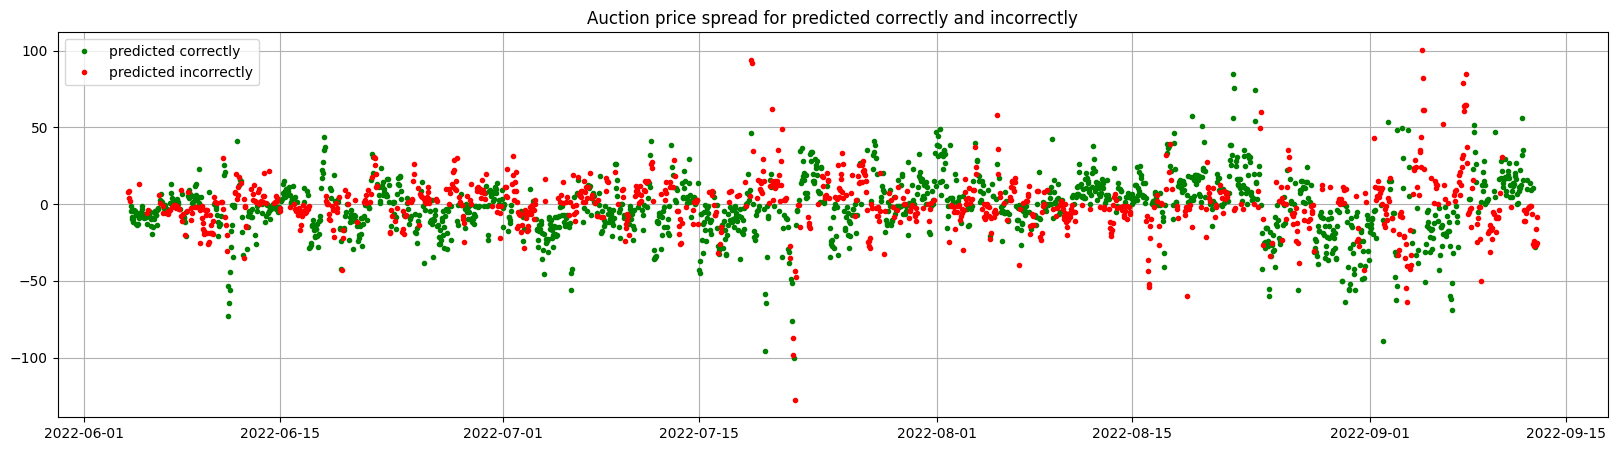

In [299]:
# bar plot the auction spread sperated according to whether the direction of the spread was predicted correctly or not
pred_correctornot = y_test['auction_spread_dir'] == y_pred_ens_acc

spreads=signals_data.loc[y_test['auction_spread_dir'].index, 'auction_price_spread']

correct_spreads=spreads[pred_correctornot]
incorrect_spreads=spreads[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than
plt.plot(correct_spreads, label='predicted correctly', linestyle='None', marker='o', markersize=3, color='green')
plt.plot(incorrect_spreads, label='predicted incorrectly', linestyle='None', marker='o', markersize=3, color='red')
plt.legend(loc='best')
plt.title('Auction price spread for predicted correctly and incorrectly')
plt.show()

plot the model probabilities sperated according to whether the direction of the spread was predicted correctly or not


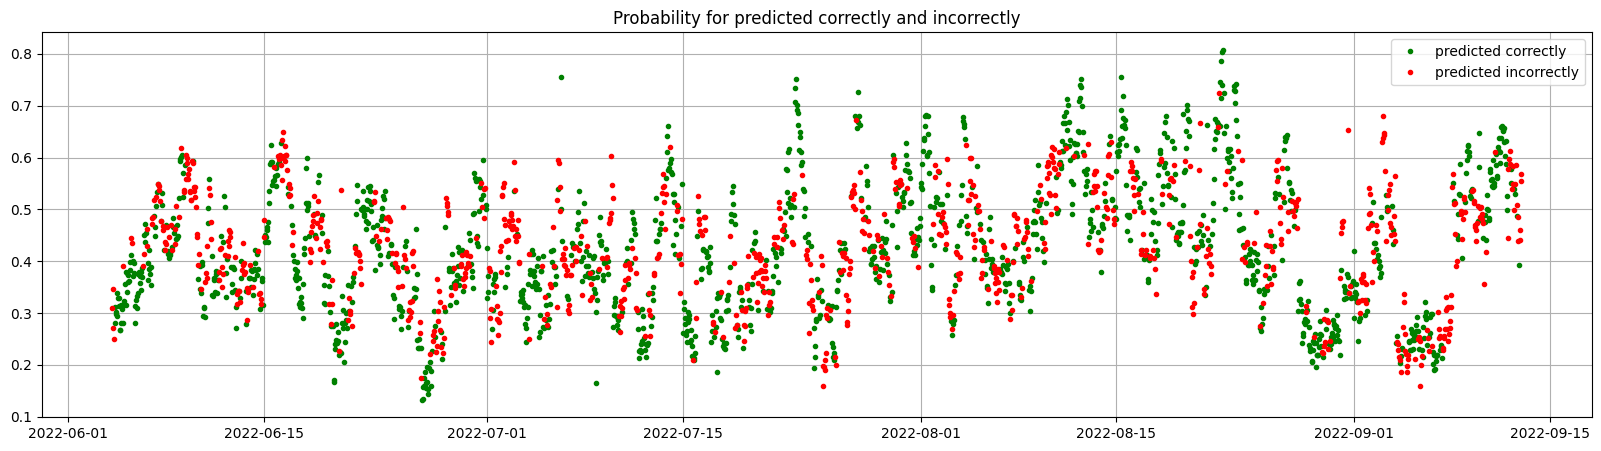

In [302]:
y_pred_proba_df=pd.DataFrame(y_pred_proba_ens, columns=['predicted_prob'], index=y_test['auction_spread_dir'].index)

prob_when_correct=y_pred_proba_df[pred_correctornot]
prob_when_incorrect=y_pred_proba_df[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than 
plt.plot(prob_when_correct, label='predicted correctly', linestyle='None', marker='o', markersize=3, color='green')
plt.plot(prob_when_incorrect, label='predicted incorrectly', linestyle='None', marker='o', markersize=3, color='red')
plt.legend(loc='best')
plt.title('Probability for predicted correctly and incorrectly')
plt.show()

We obsevre the expected trend that when probabilities are extreme then the model is more confident and tends to make a better prediction!

Select periods where predicted probability is high or low (outside [0.4, 0.6])


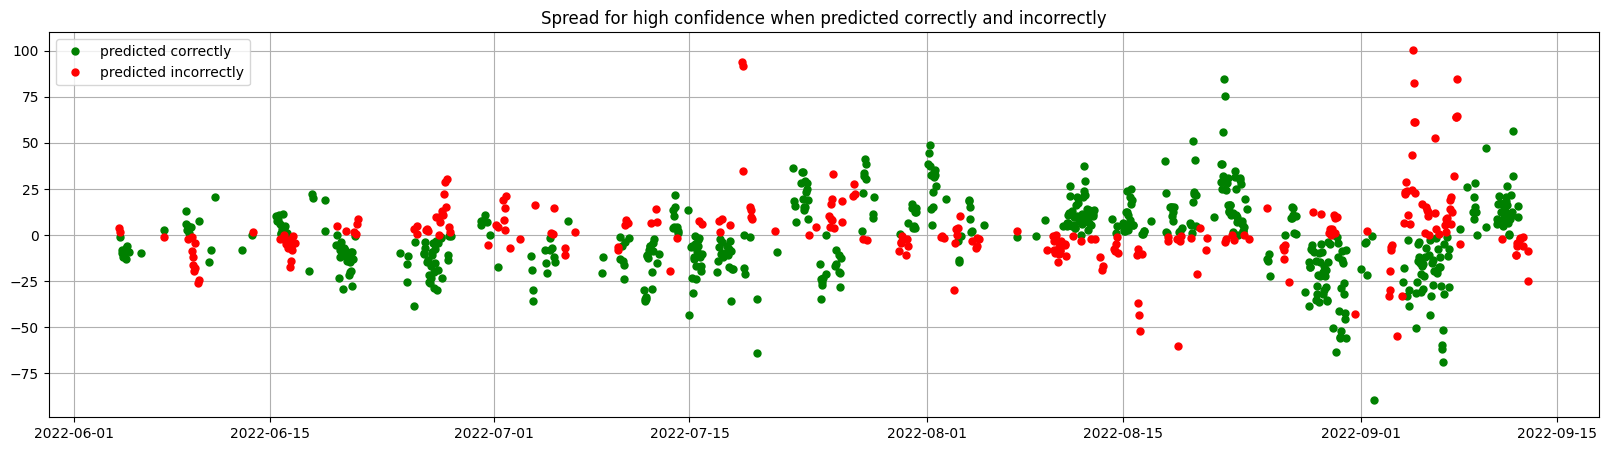

In [307]:
thresh_high_proba=y_pred_proba_df['predicted_prob'].mean()+y_pred_proba_df['predicted_prob'].std()
thresh_low_proba=y_pred_proba_df['predicted_prob'].mean()-y_pred_proba_df['predicted_prob'].std()

spread_high_proba = spreads[(y_pred_proba_df['predicted_prob'] > thresh_high_proba) | (y_pred_proba_df['predicted_prob'] < thresh_low_proba)]

spread_high_proba_when_correct=spread_high_proba[pred_correctornot]
spread_high_proba_when_incorrect=spread_high_proba[~pred_correctornot]

plt.figure(figsize=(20,5))
plt.grid()
# plot the spreads with date less than 
plt.plot(spread_high_proba_when_correct, label='predicted correctly', linestyle='None', marker='o', markersize=5, color='green')
plt.plot(spread_high_proba_when_incorrect, label='predicted incorrectly', linestyle='None', marker='o', markersize=5, color='red')
plt.legend(loc='best')
plt.title('Spread for high confidence when predicted correctly and incorrectly')
plt.show()

In [308]:
pred_correctornot[(y_pred_proba_df['predicted_prob'] > thresh_high_proba) | (y_pred_proba_df['predicted_prob'] < thresh_low_proba)].value_counts(normalize=True)

auction_spread_dir
True     0.684274
False    0.315726
Name: proportion, dtype: float64

## Deep Learning Classifiers

We define a LSTM (Long Short-Term Memory) model a type of recurrent neural network. It works by 

### Tensor Flow

We start with a LSTM model in keras tensor flow. LSTM is defined with a memory or look back window the size is set below

In [113]:
T = 100 

In [114]:
# define overlapping sequences of entries
def make_sequences(X, y, T):
    X=X.values
    y=y.values
    N, F = X.shape
    Xs, ys = [], []
    for i in range(N - T):
        Xs.append(X[i : i + T])
        ys.append(y[i + T])      # label is the move after the last bar in the window (so first T labels are not used)
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X, y2, T)
# X_seq.shape = (N-T, T, F), y_seq.shape = (N-T,)

In [115]:
from sklearn.model_selection import train_test_split

# we dont shuffle the data since we want to keep the time order
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

build LSTM model with tensorflow

Key points

return_sequences=False — we only need the final output to feed into Dense.
Dropout for regularization.
Binary crossentropy and sigmoid for 2-class.

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

N_train, _, F = X_train.shape

model = Sequential([
    LSTM(64, input_shape=(T, F), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

/Users/joshgowdy/GitHub/GB-energy-trading/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        64,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[  # optional: early stopping
        EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
    ]
)

Epoch 1/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4966 - loss: 0.7006 - val_accuracy: 0.4818 - val_loss: 0.6937
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5019 - loss: 0.6957 - val_accuracy: 0.4818 - val_loss: 0.6937
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5017 - loss: 0.6951 - val_accuracy: 0.4818 - val_loss: 0.6935
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5027 - loss: 0.6940 - val_accuracy: 0.4827 - val_loss: 0.6932
Epoch 5/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5023 - loss: 0.6930 - val_accuracy: 0.5182 - val_loss: 0.6928
Epoch 6/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5055 - loss: 0.6934 - val_accuracy: 0.4827 - val_loss: 0.6932
Epoch 7/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5073 - loss: 0.6932 - val_accuracy: 0.5182 - val_loss: 0.6931
Epoch 8/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5134 - loss: 0.6929 - val_accu

In [118]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# # Confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# y_pred = (model.predict(X_test) > 0.5).astype(int)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5845 - loss: 0.6911
Test Accuracy: 0.5383


In [119]:
model.predict(X_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


TypeError: python object must be callable or have a callable write method

In [120]:
print(type(model))

<class 'keras.src.models.sequential.Sequential'>


In [ ]:
# plot the ROC curve
y_pred_prob_deep=model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_deep)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

### pytorch

In [122]:
import torch
import torch.nn as nn

class PriceLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(PriceLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]  # last time step
        out = self.fc(last_out)
        return self.sigmoid(out)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = PriceLSTMClassifier(input_size=X_train.shape[2], hidden_size=64)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for batch_x, batch_y in loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    preds = model(X_test_t)
    preds_class = (preds > 0.5).int()
    
    accuracy = (preds_class.squeeze() == y_test_t.squeeze().int()).float().mean()
    print(f"Test Accuracy: {accuracy:.2f}")